# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

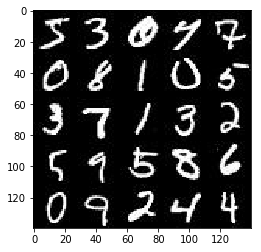

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

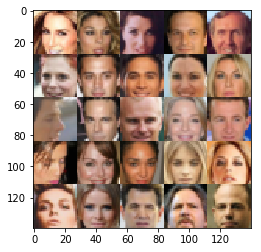

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128

        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
            
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(16, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescaling the batch image (recommandation of the review)
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, tf.convert_to_tensor(sample_z, dtype=np.float32), data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 0.8667... Generator Loss: 0.6668
Epoch 1/10... Discriminator Loss: 0.5380... Generator Loss: 1.0574
Epoch 1/10... Discriminator Loss: 0.4760... Generator Loss: 1.3244
Epoch 1/10... Discriminator Loss: 0.4825... Generator Loss: 1.2564
Epoch 1/10... Discriminator Loss: 0.7211... Generator Loss: 0.8764
Epoch 1/10... Discriminator Loss: 0.3571... Generator Loss: 1.8947
Epoch 1/10... Discriminator Loss: 0.3758... Generator Loss: 1.6570
Epoch 1/10... Discriminator Loss: 0.3896... Generator Loss: 2.0335
Epoch 1/10... Discriminator Loss: 0.5135... Generator Loss: 1.3126
Epoch 1/10... Discriminator Loss: 0.4716... Generator Loss: 2.4707


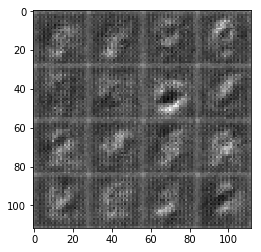

Epoch 1/10... Discriminator Loss: 0.6207... Generator Loss: 1.0974
Epoch 1/10... Discriminator Loss: 0.5586... Generator Loss: 1.2199
Epoch 1/10... Discriminator Loss: 0.6618... Generator Loss: 1.0085
Epoch 1/10... Discriminator Loss: 0.7442... Generator Loss: 1.1253
Epoch 1/10... Discriminator Loss: 0.7851... Generator Loss: 1.8385
Epoch 1/10... Discriminator Loss: 0.5792... Generator Loss: 1.3311
Epoch 1/10... Discriminator Loss: 1.1286... Generator Loss: 0.5050
Epoch 1/10... Discriminator Loss: 0.6691... Generator Loss: 1.4742
Epoch 1/10... Discriminator Loss: 0.6724... Generator Loss: 0.9931
Epoch 1/10... Discriminator Loss: 0.6579... Generator Loss: 1.2129


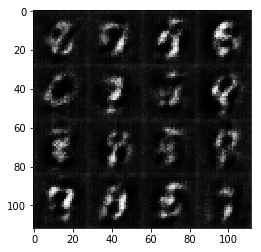

Epoch 1/10... Discriminator Loss: 0.7352... Generator Loss: 1.2424
Epoch 1/10... Discriminator Loss: 0.7253... Generator Loss: 1.1135
Epoch 1/10... Discriminator Loss: 0.7687... Generator Loss: 0.9677
Epoch 1/10... Discriminator Loss: 0.7823... Generator Loss: 1.0785
Epoch 1/10... Discriminator Loss: 0.8734... Generator Loss: 0.8185
Epoch 1/10... Discriminator Loss: 0.7093... Generator Loss: 1.6406
Epoch 1/10... Discriminator Loss: 0.8673... Generator Loss: 1.4321
Epoch 1/10... Discriminator Loss: 0.8273... Generator Loss: 0.9226
Epoch 1/10... Discriminator Loss: 0.8007... Generator Loss: 1.1425
Epoch 1/10... Discriminator Loss: 0.7516... Generator Loss: 1.2385


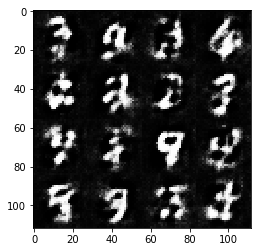

Epoch 1/10... Discriminator Loss: 0.7436... Generator Loss: 0.9961
Epoch 1/10... Discriminator Loss: 0.7904... Generator Loss: 1.0213
Epoch 1/10... Discriminator Loss: 0.8180... Generator Loss: 1.2475
Epoch 1/10... Discriminator Loss: 0.7967... Generator Loss: 0.9084
Epoch 1/10... Discriminator Loss: 0.9184... Generator Loss: 0.7323
Epoch 1/10... Discriminator Loss: 0.8097... Generator Loss: 1.5157
Epoch 1/10... Discriminator Loss: 0.9273... Generator Loss: 0.6754
Epoch 1/10... Discriminator Loss: 0.6660... Generator Loss: 1.3830
Epoch 1/10... Discriminator Loss: 0.5978... Generator Loss: 1.1796
Epoch 1/10... Discriminator Loss: 0.8467... Generator Loss: 0.8261


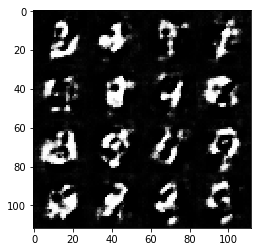

Epoch 1/10... Discriminator Loss: 0.8703... Generator Loss: 0.8562
Epoch 1/10... Discriminator Loss: 0.6094... Generator Loss: 1.1980
Epoch 1/10... Discriminator Loss: 0.7683... Generator Loss: 1.1689
Epoch 1/10... Discriminator Loss: 1.1914... Generator Loss: 0.6066
Epoch 1/10... Discriminator Loss: 0.8290... Generator Loss: 1.3567
Epoch 1/10... Discriminator Loss: 0.7213... Generator Loss: 1.6591
Epoch 1/10... Discriminator Loss: 0.6914... Generator Loss: 1.0367
Epoch 1/10... Discriminator Loss: 0.7548... Generator Loss: 1.5564
Epoch 1/10... Discriminator Loss: 0.7250... Generator Loss: 1.6371
Epoch 1/10... Discriminator Loss: 0.5852... Generator Loss: 1.2235


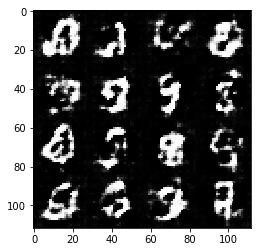

Epoch 1/10... Discriminator Loss: 0.7562... Generator Loss: 1.0822
Epoch 1/10... Discriminator Loss: 0.6541... Generator Loss: 1.2434
Epoch 1/10... Discriminator Loss: 0.7568... Generator Loss: 0.9469
Epoch 1/10... Discriminator Loss: 0.6320... Generator Loss: 1.2795
Epoch 1/10... Discriminator Loss: 0.5431... Generator Loss: 1.5747
Epoch 1/10... Discriminator Loss: 0.7259... Generator Loss: 1.8532
Epoch 1/10... Discriminator Loss: 0.5677... Generator Loss: 1.3901
Epoch 1/10... Discriminator Loss: 0.7553... Generator Loss: 1.5612
Epoch 1/10... Discriminator Loss: 0.6173... Generator Loss: 1.4810
Epoch 1/10... Discriminator Loss: 0.5844... Generator Loss: 1.2798


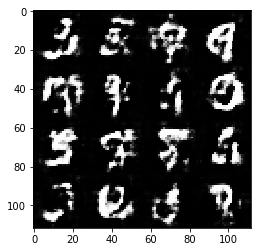

Epoch 1/10... Discriminator Loss: 0.5052... Generator Loss: 1.3669
Epoch 1/10... Discriminator Loss: 0.5805... Generator Loss: 1.3602
Epoch 1/10... Discriminator Loss: 0.6622... Generator Loss: 1.7071
Epoch 1/10... Discriminator Loss: 0.6857... Generator Loss: 1.2159
Epoch 1/10... Discriminator Loss: 0.5849... Generator Loss: 1.2608
Epoch 1/10... Discriminator Loss: 0.5242... Generator Loss: 1.5027
Epoch 1/10... Discriminator Loss: 0.6929... Generator Loss: 2.0829
Epoch 1/10... Discriminator Loss: 0.7124... Generator Loss: 1.2986
Epoch 1/10... Discriminator Loss: 0.5666... Generator Loss: 1.3960
Epoch 1/10... Discriminator Loss: 0.4750... Generator Loss: 1.6137


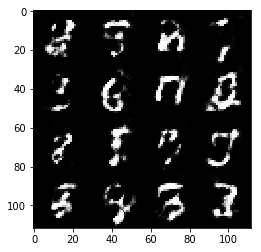

Epoch 1/10... Discriminator Loss: 0.5878... Generator Loss: 1.3254
Epoch 1/10... Discriminator Loss: 0.5106... Generator Loss: 1.5013
Epoch 1/10... Discriminator Loss: 0.4627... Generator Loss: 1.7987
Epoch 1/10... Discriminator Loss: 0.4533... Generator Loss: 1.7670
Epoch 1/10... Discriminator Loss: 0.5228... Generator Loss: 1.4764
Epoch 1/10... Discriminator Loss: 0.3929... Generator Loss: 2.0473
Epoch 1/10... Discriminator Loss: 0.5753... Generator Loss: 1.8884
Epoch 1/10... Discriminator Loss: 0.5194... Generator Loss: 1.4549
Epoch 1/10... Discriminator Loss: 0.5699... Generator Loss: 1.2002
Epoch 1/10... Discriminator Loss: 0.7795... Generator Loss: 0.9656


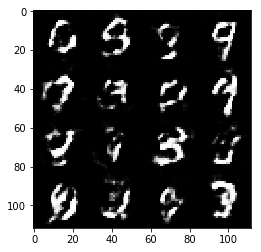

Epoch 1/10... Discriminator Loss: 0.5489... Generator Loss: 1.1358
Epoch 1/10... Discriminator Loss: 0.5880... Generator Loss: 1.1713
Epoch 1/10... Discriminator Loss: 0.8092... Generator Loss: 0.8658
Epoch 1/10... Discriminator Loss: 0.3790... Generator Loss: 2.3222
Epoch 1/10... Discriminator Loss: 0.5622... Generator Loss: 1.3437
Epoch 1/10... Discriminator Loss: 0.4905... Generator Loss: 1.4109
Epoch 1/10... Discriminator Loss: 0.9327... Generator Loss: 0.6260
Epoch 1/10... Discriminator Loss: 0.7911... Generator Loss: 0.7515
Epoch 1/10... Discriminator Loss: 0.6791... Generator Loss: 1.4070
Epoch 1/10... Discriminator Loss: 0.3161... Generator Loss: 1.9707


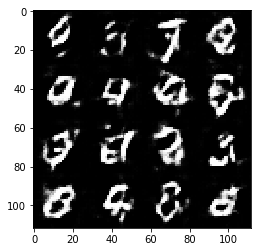

Epoch 1/10... Discriminator Loss: 0.4697... Generator Loss: 1.7218
Epoch 1/10... Discriminator Loss: 0.4444... Generator Loss: 1.5870
Epoch 1/10... Discriminator Loss: 0.6883... Generator Loss: 1.2282
Epoch 1/10... Discriminator Loss: 0.6222... Generator Loss: 1.0054
Epoch 1/10... Discriminator Loss: 0.5872... Generator Loss: 1.4001
Epoch 1/10... Discriminator Loss: 0.3612... Generator Loss: 1.7646
Epoch 1/10... Discriminator Loss: 0.5835... Generator Loss: 1.6439
Epoch 1/10... Discriminator Loss: 0.4248... Generator Loss: 1.9297
Epoch 1/10... Discriminator Loss: 0.5392... Generator Loss: 1.2192
Epoch 1/10... Discriminator Loss: 0.5562... Generator Loss: 1.4058


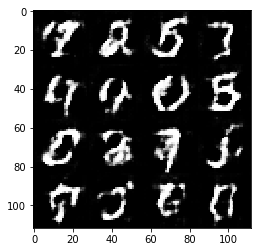

Epoch 1/10... Discriminator Loss: 0.9643... Generator Loss: 0.6029
Epoch 1/10... Discriminator Loss: 0.6065... Generator Loss: 1.8203
Epoch 1/10... Discriminator Loss: 0.5357... Generator Loss: 1.3282
Epoch 1/10... Discriminator Loss: 0.5459... Generator Loss: 1.4449
Epoch 1/10... Discriminator Loss: 0.5280... Generator Loss: 1.2142
Epoch 1/10... Discriminator Loss: 0.5429... Generator Loss: 1.4064
Epoch 1/10... Discriminator Loss: 0.4341... Generator Loss: 1.7100
Epoch 1/10... Discriminator Loss: 0.4463... Generator Loss: 1.6228
Epoch 1/10... Discriminator Loss: 0.4053... Generator Loss: 1.7938
Epoch 1/10... Discriminator Loss: 0.5543... Generator Loss: 1.2350


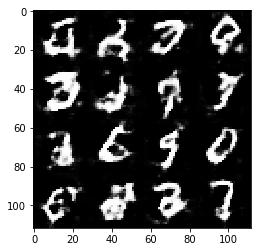

Epoch 1/10... Discriminator Loss: 0.7079... Generator Loss: 1.4555
Epoch 1/10... Discriminator Loss: 0.8540... Generator Loss: 2.4614
Epoch 1/10... Discriminator Loss: 0.4540... Generator Loss: 1.5425
Epoch 1/10... Discriminator Loss: 0.6946... Generator Loss: 1.6668
Epoch 1/10... Discriminator Loss: 0.5119... Generator Loss: 1.2241
Epoch 1/10... Discriminator Loss: 0.4807... Generator Loss: 1.5247
Epoch 1/10... Discriminator Loss: 0.6445... Generator Loss: 1.2264
Epoch 1/10... Discriminator Loss: 0.4936... Generator Loss: 1.6555
Epoch 1/10... Discriminator Loss: 0.5189... Generator Loss: 1.6546
Epoch 1/10... Discriminator Loss: 0.5895... Generator Loss: 1.2844


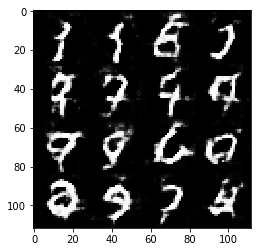

Epoch 1/10... Discriminator Loss: 0.5345... Generator Loss: 1.8790
Epoch 1/10... Discriminator Loss: 0.4844... Generator Loss: 2.3323
Epoch 1/10... Discriminator Loss: 0.6088... Generator Loss: 1.8463
Epoch 1/10... Discriminator Loss: 0.6184... Generator Loss: 1.5758
Epoch 1/10... Discriminator Loss: 0.6620... Generator Loss: 1.4022
Epoch 1/10... Discriminator Loss: 0.4840... Generator Loss: 1.5706
Epoch 1/10... Discriminator Loss: 0.6886... Generator Loss: 1.0369
Epoch 1/10... Discriminator Loss: 0.6078... Generator Loss: 2.1287
Epoch 1/10... Discriminator Loss: 0.5554... Generator Loss: 1.4836
Epoch 1/10... Discriminator Loss: 0.7998... Generator Loss: 0.9399


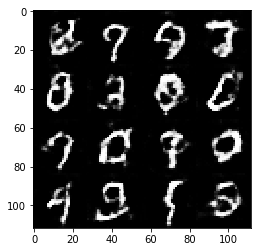

Epoch 1/10... Discriminator Loss: 0.5412... Generator Loss: 2.1786
Epoch 1/10... Discriminator Loss: 0.9113... Generator Loss: 0.8451
Epoch 1/10... Discriminator Loss: 0.6581... Generator Loss: 1.7190
Epoch 1/10... Discriminator Loss: 0.5324... Generator Loss: 1.5757
Epoch 1/10... Discriminator Loss: 0.8518... Generator Loss: 0.8293
Epoch 1/10... Discriminator Loss: 0.9816... Generator Loss: 0.8328
Epoch 1/10... Discriminator Loss: 0.6268... Generator Loss: 1.4515
Epoch 1/10... Discriminator Loss: 0.4585... Generator Loss: 1.5805
Epoch 1/10... Discriminator Loss: 0.4922... Generator Loss: 1.8687
Epoch 1/10... Discriminator Loss: 0.6616... Generator Loss: 1.1099


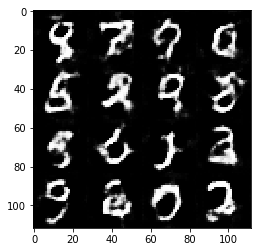

Epoch 1/10... Discriminator Loss: 0.6287... Generator Loss: 1.1929
Epoch 1/10... Discriminator Loss: 0.7695... Generator Loss: 1.0958
Epoch 1/10... Discriminator Loss: 0.9081... Generator Loss: 0.8865
Epoch 1/10... Discriminator Loss: 0.8154... Generator Loss: 0.8240
Epoch 1/10... Discriminator Loss: 0.6464... Generator Loss: 1.0685
Epoch 1/10... Discriminator Loss: 0.7315... Generator Loss: 1.6182
Epoch 1/10... Discriminator Loss: 0.8803... Generator Loss: 0.7878
Epoch 1/10... Discriminator Loss: 0.6227... Generator Loss: 1.1618
Epoch 1/10... Discriminator Loss: 0.8927... Generator Loss: 1.1813
Epoch 1/10... Discriminator Loss: 0.7192... Generator Loss: 1.2840


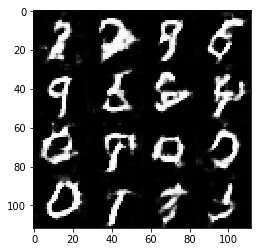

Epoch 1/10... Discriminator Loss: 0.8606... Generator Loss: 0.7778
Epoch 1/10... Discriminator Loss: 0.6175... Generator Loss: 1.7131
Epoch 1/10... Discriminator Loss: 0.8007... Generator Loss: 0.8328
Epoch 1/10... Discriminator Loss: 0.6633... Generator Loss: 1.3850
Epoch 1/10... Discriminator Loss: 0.7270... Generator Loss: 0.9517
Epoch 1/10... Discriminator Loss: 0.7676... Generator Loss: 1.0423
Epoch 1/10... Discriminator Loss: 0.7298... Generator Loss: 1.4513
Epoch 1/10... Discriminator Loss: 0.6868... Generator Loss: 1.0795
Epoch 1/10... Discriminator Loss: 0.5490... Generator Loss: 1.8061
Epoch 1/10... Discriminator Loss: 1.2139... Generator Loss: 0.4465


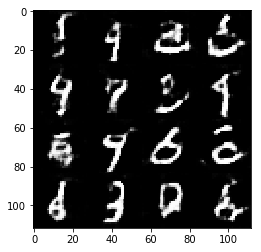

Epoch 1/10... Discriminator Loss: 0.7575... Generator Loss: 1.1066
Epoch 1/10... Discriminator Loss: 0.6031... Generator Loss: 1.2853
Epoch 1/10... Discriminator Loss: 0.8071... Generator Loss: 0.8251
Epoch 1/10... Discriminator Loss: 0.7541... Generator Loss: 1.0102
Epoch 1/10... Discriminator Loss: 0.5882... Generator Loss: 1.3484
Epoch 1/10... Discriminator Loss: 0.4836... Generator Loss: 1.9059
Epoch 1/10... Discriminator Loss: 0.7634... Generator Loss: 0.9126
Epoch 1/10... Discriminator Loss: 0.5960... Generator Loss: 1.7549
Epoch 1/10... Discriminator Loss: 0.8603... Generator Loss: 1.8990
Epoch 1/10... Discriminator Loss: 0.5520... Generator Loss: 1.3883


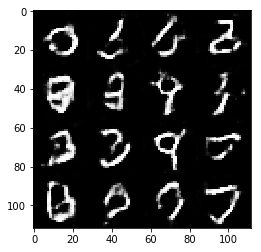

Epoch 1/10... Discriminator Loss: 0.7629... Generator Loss: 1.3857
Epoch 1/10... Discriminator Loss: 1.1526... Generator Loss: 1.7422
Epoch 1/10... Discriminator Loss: 1.2339... Generator Loss: 0.5150
Epoch 1/10... Discriminator Loss: 0.7271... Generator Loss: 1.2722
Epoch 1/10... Discriminator Loss: 0.5350... Generator Loss: 1.7856
Epoch 1/10... Discriminator Loss: 0.7487... Generator Loss: 0.8631
Epoch 1/10... Discriminator Loss: 0.6456... Generator Loss: 1.3945
Epoch 1/10... Discriminator Loss: 0.6059... Generator Loss: 1.6669
Epoch 1/10... Discriminator Loss: 0.5746... Generator Loss: 1.7683
Epoch 1/10... Discriminator Loss: 0.5877... Generator Loss: 1.2379


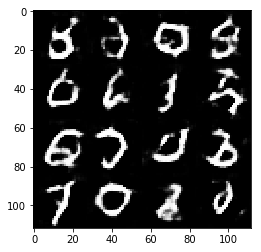

Epoch 1/10... Discriminator Loss: 1.1237... Generator Loss: 0.5510
Epoch 1/10... Discriminator Loss: 0.5999... Generator Loss: 1.2614
Epoch 1/10... Discriminator Loss: 1.0207... Generator Loss: 1.8547
Epoch 1/10... Discriminator Loss: 0.5882... Generator Loss: 1.6645
Epoch 1/10... Discriminator Loss: 0.7929... Generator Loss: 0.9276
Epoch 1/10... Discriminator Loss: 0.8874... Generator Loss: 0.8251
Epoch 1/10... Discriminator Loss: 0.6157... Generator Loss: 1.3633
Epoch 2/10... Discriminator Loss: 0.6314... Generator Loss: 1.7736
Epoch 2/10... Discriminator Loss: 0.6464... Generator Loss: 1.1312
Epoch 2/10... Discriminator Loss: 0.7120... Generator Loss: 1.3643


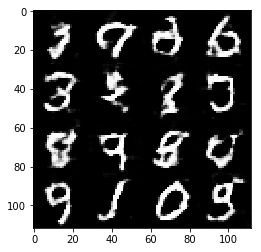

Epoch 2/10... Discriminator Loss: 0.7193... Generator Loss: 1.7151
Epoch 2/10... Discriminator Loss: 0.5623... Generator Loss: 1.5150
Epoch 2/10... Discriminator Loss: 0.7151... Generator Loss: 0.9593
Epoch 2/10... Discriminator Loss: 0.6742... Generator Loss: 1.1324
Epoch 2/10... Discriminator Loss: 0.5524... Generator Loss: 1.5092
Epoch 2/10... Discriminator Loss: 0.6717... Generator Loss: 1.5919
Epoch 2/10... Discriminator Loss: 0.7238... Generator Loss: 1.2410
Epoch 2/10... Discriminator Loss: 0.6590... Generator Loss: 1.4779
Epoch 2/10... Discriminator Loss: 0.4599... Generator Loss: 1.8252
Epoch 2/10... Discriminator Loss: 0.6563... Generator Loss: 1.6784


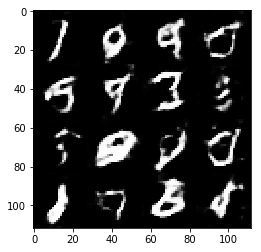

Epoch 2/10... Discriminator Loss: 0.7333... Generator Loss: 1.3222
Epoch 2/10... Discriminator Loss: 0.5068... Generator Loss: 1.7575
Epoch 2/10... Discriminator Loss: 0.9053... Generator Loss: 0.7309
Epoch 2/10... Discriminator Loss: 0.4582... Generator Loss: 1.5208
Epoch 2/10... Discriminator Loss: 0.7670... Generator Loss: 1.0772
Epoch 2/10... Discriminator Loss: 0.6874... Generator Loss: 1.1985
Epoch 2/10... Discriminator Loss: 0.6317... Generator Loss: 1.5038
Epoch 2/10... Discriminator Loss: 0.6770... Generator Loss: 1.3226
Epoch 2/10... Discriminator Loss: 0.8596... Generator Loss: 0.8885
Epoch 2/10... Discriminator Loss: 0.5288... Generator Loss: 1.3957


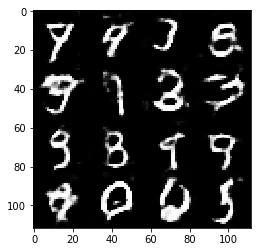

Epoch 2/10... Discriminator Loss: 0.7640... Generator Loss: 1.1635
Epoch 2/10... Discriminator Loss: 0.9175... Generator Loss: 1.8146
Epoch 2/10... Discriminator Loss: 0.5556... Generator Loss: 1.5607
Epoch 2/10... Discriminator Loss: 0.5646... Generator Loss: 1.5871
Epoch 2/10... Discriminator Loss: 0.8812... Generator Loss: 0.8640
Epoch 2/10... Discriminator Loss: 0.6955... Generator Loss: 1.2773
Epoch 2/10... Discriminator Loss: 0.6206... Generator Loss: 1.0082
Epoch 2/10... Discriminator Loss: 0.8280... Generator Loss: 0.8842
Epoch 2/10... Discriminator Loss: 0.6582... Generator Loss: 1.0254
Epoch 2/10... Discriminator Loss: 0.7733... Generator Loss: 2.0581


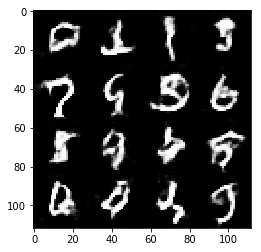

Epoch 2/10... Discriminator Loss: 0.8383... Generator Loss: 2.0323
Epoch 2/10... Discriminator Loss: 0.4870... Generator Loss: 1.3829
Epoch 2/10... Discriminator Loss: 0.7475... Generator Loss: 1.0507
Epoch 2/10... Discriminator Loss: 0.8082... Generator Loss: 0.9239
Epoch 2/10... Discriminator Loss: 0.9223... Generator Loss: 0.7554
Epoch 2/10... Discriminator Loss: 0.6738... Generator Loss: 1.9100
Epoch 2/10... Discriminator Loss: 0.6576... Generator Loss: 1.2085
Epoch 2/10... Discriminator Loss: 0.6235... Generator Loss: 1.3520
Epoch 2/10... Discriminator Loss: 1.2075... Generator Loss: 0.4961
Epoch 2/10... Discriminator Loss: 0.6294... Generator Loss: 1.3940


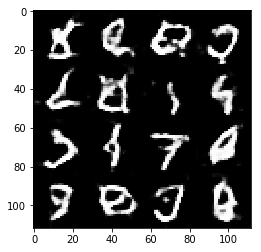

Epoch 2/10... Discriminator Loss: 0.6328... Generator Loss: 1.4610
Epoch 2/10... Discriminator Loss: 0.7053... Generator Loss: 1.7487
Epoch 2/10... Discriminator Loss: 0.9519... Generator Loss: 0.6522
Epoch 2/10... Discriminator Loss: 0.8171... Generator Loss: 0.7657
Epoch 2/10... Discriminator Loss: 0.6221... Generator Loss: 1.2847
Epoch 2/10... Discriminator Loss: 0.5107... Generator Loss: 1.4295
Epoch 2/10... Discriminator Loss: 0.9264... Generator Loss: 2.4719
Epoch 2/10... Discriminator Loss: 0.6048... Generator Loss: 1.3756
Epoch 2/10... Discriminator Loss: 0.6017... Generator Loss: 1.2932
Epoch 2/10... Discriminator Loss: 0.6042... Generator Loss: 1.2704


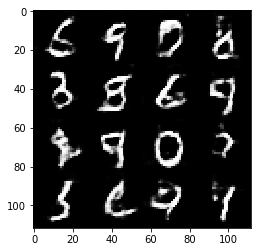

Epoch 2/10... Discriminator Loss: 0.6281... Generator Loss: 1.6618
Epoch 2/10... Discriminator Loss: 0.4891... Generator Loss: 1.5162
Epoch 2/10... Discriminator Loss: 0.6818... Generator Loss: 1.1081
Epoch 2/10... Discriminator Loss: 0.6531... Generator Loss: 1.2655
Epoch 2/10... Discriminator Loss: 0.8090... Generator Loss: 1.5183
Epoch 2/10... Discriminator Loss: 0.6481... Generator Loss: 1.4627
Epoch 2/10... Discriminator Loss: 0.7254... Generator Loss: 1.0167
Epoch 2/10... Discriminator Loss: 0.8197... Generator Loss: 1.7082
Epoch 2/10... Discriminator Loss: 0.4781... Generator Loss: 1.6225
Epoch 2/10... Discriminator Loss: 0.6468... Generator Loss: 1.4019


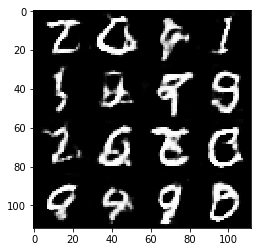

Epoch 2/10... Discriminator Loss: 0.6799... Generator Loss: 1.3903
Epoch 2/10... Discriminator Loss: 0.6827... Generator Loss: 1.0454
Epoch 2/10... Discriminator Loss: 0.4814... Generator Loss: 1.5535
Epoch 2/10... Discriminator Loss: 0.5707... Generator Loss: 1.7849
Epoch 2/10... Discriminator Loss: 0.6877... Generator Loss: 1.3928
Epoch 2/10... Discriminator Loss: 0.5648... Generator Loss: 1.2457
Epoch 2/10... Discriminator Loss: 0.5123... Generator Loss: 1.3755
Epoch 2/10... Discriminator Loss: 0.6550... Generator Loss: 1.1661
Epoch 2/10... Discriminator Loss: 0.5146... Generator Loss: 1.5738
Epoch 2/10... Discriminator Loss: 0.8227... Generator Loss: 0.7825


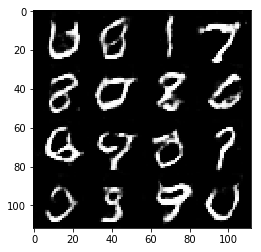

Epoch 2/10... Discriminator Loss: 0.6828... Generator Loss: 0.9366
Epoch 2/10... Discriminator Loss: 0.5416... Generator Loss: 1.6463
Epoch 2/10... Discriminator Loss: 0.6474... Generator Loss: 1.8758
Epoch 2/10... Discriminator Loss: 1.3955... Generator Loss: 0.3910
Epoch 2/10... Discriminator Loss: 0.5657... Generator Loss: 1.2359
Epoch 2/10... Discriminator Loss: 0.6111... Generator Loss: 1.2853
Epoch 2/10... Discriminator Loss: 0.6631... Generator Loss: 1.1639
Epoch 2/10... Discriminator Loss: 0.5161... Generator Loss: 1.4654
Epoch 2/10... Discriminator Loss: 0.4803... Generator Loss: 1.5558
Epoch 2/10... Discriminator Loss: 0.4936... Generator Loss: 1.7429


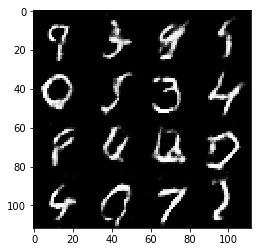

Epoch 2/10... Discriminator Loss: 0.5040... Generator Loss: 1.4817
Epoch 2/10... Discriminator Loss: 0.8841... Generator Loss: 0.7323
Epoch 2/10... Discriminator Loss: 0.7479... Generator Loss: 1.0774
Epoch 2/10... Discriminator Loss: 0.4737... Generator Loss: 1.5587
Epoch 2/10... Discriminator Loss: 0.4750... Generator Loss: 1.6990
Epoch 2/10... Discriminator Loss: 0.4786... Generator Loss: 1.7549
Epoch 2/10... Discriminator Loss: 0.6455... Generator Loss: 1.3294
Epoch 2/10... Discriminator Loss: 0.4732... Generator Loss: 1.8724
Epoch 2/10... Discriminator Loss: 1.0282... Generator Loss: 0.6823
Epoch 2/10... Discriminator Loss: 1.4345... Generator Loss: 0.3830


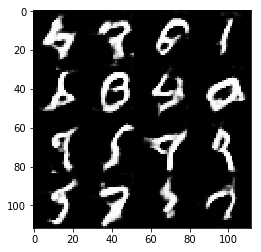

Epoch 2/10... Discriminator Loss: 0.6411... Generator Loss: 2.2013
Epoch 2/10... Discriminator Loss: 0.6188... Generator Loss: 1.7537
Epoch 2/10... Discriminator Loss: 0.5527... Generator Loss: 1.2885
Epoch 2/10... Discriminator Loss: 0.5136... Generator Loss: 1.4222
Epoch 2/10... Discriminator Loss: 0.6356... Generator Loss: 1.1567
Epoch 2/10... Discriminator Loss: 0.5865... Generator Loss: 1.7971
Epoch 2/10... Discriminator Loss: 0.5296... Generator Loss: 1.2875
Epoch 2/10... Discriminator Loss: 0.5490... Generator Loss: 1.6709
Epoch 2/10... Discriminator Loss: 0.5198... Generator Loss: 1.7722
Epoch 2/10... Discriminator Loss: 0.4985... Generator Loss: 1.8971


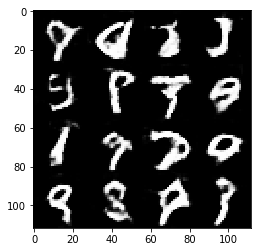

Epoch 2/10... Discriminator Loss: 0.3484... Generator Loss: 1.8919
Epoch 2/10... Discriminator Loss: 0.7980... Generator Loss: 0.9749
Epoch 2/10... Discriminator Loss: 0.4143... Generator Loss: 1.6809
Epoch 2/10... Discriminator Loss: 0.6660... Generator Loss: 1.0062
Epoch 2/10... Discriminator Loss: 0.6149... Generator Loss: 1.7586
Epoch 2/10... Discriminator Loss: 0.5226... Generator Loss: 1.4221
Epoch 2/10... Discriminator Loss: 0.9099... Generator Loss: 0.7625
Epoch 2/10... Discriminator Loss: 0.5233... Generator Loss: 1.5036
Epoch 2/10... Discriminator Loss: 0.6095... Generator Loss: 1.0960
Epoch 2/10... Discriminator Loss: 0.5778... Generator Loss: 2.3312


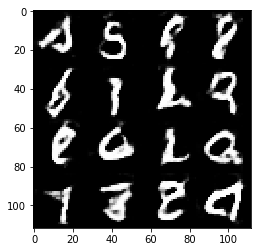

Epoch 2/10... Discriminator Loss: 0.8914... Generator Loss: 0.8234
Epoch 2/10... Discriminator Loss: 0.4599... Generator Loss: 1.5722
Epoch 2/10... Discriminator Loss: 0.7629... Generator Loss: 0.9748
Epoch 2/10... Discriminator Loss: 0.6161... Generator Loss: 1.1503
Epoch 2/10... Discriminator Loss: 0.4492... Generator Loss: 1.5173
Epoch 2/10... Discriminator Loss: 0.4258... Generator Loss: 1.4987
Epoch 2/10... Discriminator Loss: 0.4468... Generator Loss: 1.5738
Epoch 2/10... Discriminator Loss: 0.4520... Generator Loss: 1.9016
Epoch 2/10... Discriminator Loss: 0.6695... Generator Loss: 1.3503
Epoch 2/10... Discriminator Loss: 0.7094... Generator Loss: 0.9506


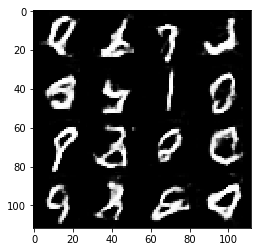

Epoch 2/10... Discriminator Loss: 0.4842... Generator Loss: 2.1072
Epoch 2/10... Discriminator Loss: 0.6608... Generator Loss: 1.0304
Epoch 2/10... Discriminator Loss: 0.6481... Generator Loss: 1.5034
Epoch 2/10... Discriminator Loss: 0.6466... Generator Loss: 0.9940
Epoch 2/10... Discriminator Loss: 0.5997... Generator Loss: 1.1974
Epoch 2/10... Discriminator Loss: 0.6008... Generator Loss: 1.1949
Epoch 2/10... Discriminator Loss: 0.5328... Generator Loss: 1.4488
Epoch 2/10... Discriminator Loss: 0.5414... Generator Loss: 1.3638
Epoch 2/10... Discriminator Loss: 1.1108... Generator Loss: 0.4845
Epoch 2/10... Discriminator Loss: 0.5491... Generator Loss: 1.4261


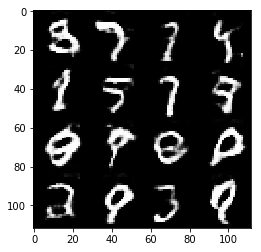

Epoch 2/10... Discriminator Loss: 0.6792... Generator Loss: 1.8678
Epoch 2/10... Discriminator Loss: 0.6418... Generator Loss: 1.6422
Epoch 2/10... Discriminator Loss: 0.5526... Generator Loss: 1.5013
Epoch 2/10... Discriminator Loss: 0.5592... Generator Loss: 1.8831
Epoch 2/10... Discriminator Loss: 0.4272... Generator Loss: 1.9347
Epoch 2/10... Discriminator Loss: 0.3726... Generator Loss: 1.7135
Epoch 2/10... Discriminator Loss: 0.5653... Generator Loss: 1.1891
Epoch 2/10... Discriminator Loss: 0.4983... Generator Loss: 1.5422
Epoch 2/10... Discriminator Loss: 0.7046... Generator Loss: 0.9017
Epoch 2/10... Discriminator Loss: 0.6577... Generator Loss: 0.9245


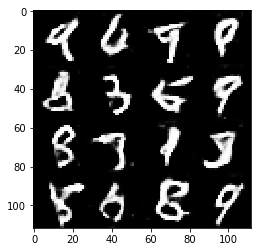

Epoch 2/10... Discriminator Loss: 0.4888... Generator Loss: 2.1177
Epoch 2/10... Discriminator Loss: 0.4603... Generator Loss: 1.9315
Epoch 2/10... Discriminator Loss: 0.9787... Generator Loss: 0.5884
Epoch 2/10... Discriminator Loss: 0.3952... Generator Loss: 2.4786
Epoch 2/10... Discriminator Loss: 0.5271... Generator Loss: 1.7224
Epoch 2/10... Discriminator Loss: 0.3614... Generator Loss: 1.7934
Epoch 2/10... Discriminator Loss: 0.5698... Generator Loss: 1.1344
Epoch 2/10... Discriminator Loss: 0.4302... Generator Loss: 1.4328
Epoch 2/10... Discriminator Loss: 0.3755... Generator Loss: 1.7589
Epoch 2/10... Discriminator Loss: 0.6627... Generator Loss: 1.0552


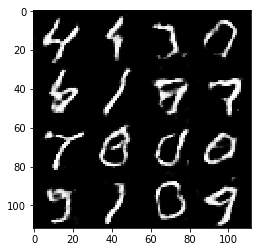

Epoch 2/10... Discriminator Loss: 0.6073... Generator Loss: 1.1136
Epoch 2/10... Discriminator Loss: 2.5910... Generator Loss: 0.1846
Epoch 2/10... Discriminator Loss: 0.7304... Generator Loss: 1.1844
Epoch 2/10... Discriminator Loss: 0.5431... Generator Loss: 1.7341
Epoch 2/10... Discriminator Loss: 0.8409... Generator Loss: 0.7277
Epoch 2/10... Discriminator Loss: 0.5636... Generator Loss: 1.3700
Epoch 2/10... Discriminator Loss: 0.3752... Generator Loss: 1.8791
Epoch 2/10... Discriminator Loss: 0.4166... Generator Loss: 1.7327
Epoch 2/10... Discriminator Loss: 0.4290... Generator Loss: 1.3852
Epoch 2/10... Discriminator Loss: 0.5352... Generator Loss: 1.7927


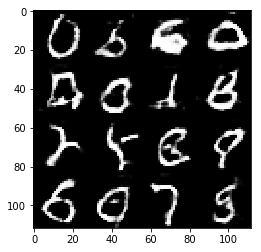

Epoch 2/10... Discriminator Loss: 0.3954... Generator Loss: 1.6552
Epoch 2/10... Discriminator Loss: 0.4371... Generator Loss: 1.8118
Epoch 2/10... Discriminator Loss: 0.5121... Generator Loss: 1.4195
Epoch 2/10... Discriminator Loss: 0.4510... Generator Loss: 1.8967
Epoch 2/10... Discriminator Loss: 0.4047... Generator Loss: 1.6949
Epoch 2/10... Discriminator Loss: 0.4805... Generator Loss: 1.4516
Epoch 2/10... Discriminator Loss: 0.3857... Generator Loss: 1.6522
Epoch 2/10... Discriminator Loss: 0.4220... Generator Loss: 1.4757
Epoch 2/10... Discriminator Loss: 0.4122... Generator Loss: 2.2532
Epoch 2/10... Discriminator Loss: 0.5241... Generator Loss: 1.3075


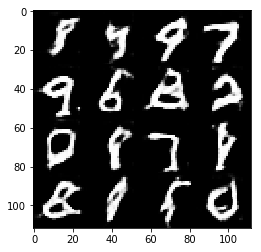

Epoch 2/10... Discriminator Loss: 0.2323... Generator Loss: 2.4025
Epoch 2/10... Discriminator Loss: 0.8283... Generator Loss: 2.6011
Epoch 2/10... Discriminator Loss: 0.4210... Generator Loss: 1.6790
Epoch 2/10... Discriminator Loss: 0.8979... Generator Loss: 0.7084
Epoch 2/10... Discriminator Loss: 0.3658... Generator Loss: 1.7673
Epoch 2/10... Discriminator Loss: 0.5723... Generator Loss: 1.2780
Epoch 2/10... Discriminator Loss: 0.4701... Generator Loss: 1.4056
Epoch 2/10... Discriminator Loss: 0.6435... Generator Loss: 1.2584
Epoch 2/10... Discriminator Loss: 0.8423... Generator Loss: 0.7480
Epoch 2/10... Discriminator Loss: 0.6191... Generator Loss: 1.6318


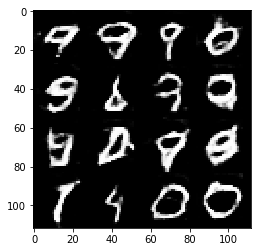

Epoch 2/10... Discriminator Loss: 0.4667... Generator Loss: 1.8035
Epoch 2/10... Discriminator Loss: 0.4455... Generator Loss: 1.5603
Epoch 2/10... Discriminator Loss: 0.4448... Generator Loss: 1.8274
Epoch 2/10... Discriminator Loss: 0.4889... Generator Loss: 1.6056
Epoch 2/10... Discriminator Loss: 0.3891... Generator Loss: 1.5752
Epoch 3/10... Discriminator Loss: 0.8784... Generator Loss: 0.9665
Epoch 3/10... Discriminator Loss: 0.8265... Generator Loss: 0.7347
Epoch 3/10... Discriminator Loss: 0.7753... Generator Loss: 0.9053
Epoch 3/10... Discriminator Loss: 0.4676... Generator Loss: 1.6965
Epoch 3/10... Discriminator Loss: 0.5570... Generator Loss: 1.2511


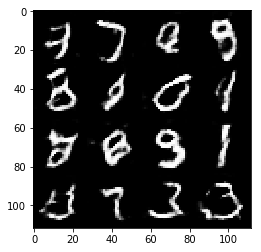

Epoch 3/10... Discriminator Loss: 0.5439... Generator Loss: 1.3876
Epoch 3/10... Discriminator Loss: 0.9367... Generator Loss: 0.6731
Epoch 3/10... Discriminator Loss: 0.3935... Generator Loss: 1.5553
Epoch 3/10... Discriminator Loss: 0.2915... Generator Loss: 2.9174
Epoch 3/10... Discriminator Loss: 0.3051... Generator Loss: 2.3200
Epoch 3/10... Discriminator Loss: 0.5341... Generator Loss: 1.4912
Epoch 3/10... Discriminator Loss: 0.4327... Generator Loss: 2.1071
Epoch 3/10... Discriminator Loss: 0.6064... Generator Loss: 1.0548
Epoch 3/10... Discriminator Loss: 1.1566... Generator Loss: 0.5083
Epoch 3/10... Discriminator Loss: 0.4544... Generator Loss: 1.4141


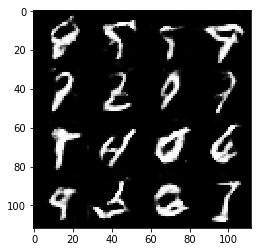

Epoch 3/10... Discriminator Loss: 0.4100... Generator Loss: 1.7089
Epoch 3/10... Discriminator Loss: 0.7225... Generator Loss: 0.9236
Epoch 3/10... Discriminator Loss: 0.2819... Generator Loss: 2.0205
Epoch 3/10... Discriminator Loss: 0.4117... Generator Loss: 1.5808
Epoch 3/10... Discriminator Loss: 0.5473... Generator Loss: 1.2440
Epoch 3/10... Discriminator Loss: 0.6234... Generator Loss: 1.1454
Epoch 3/10... Discriminator Loss: 0.3853... Generator Loss: 1.7880
Epoch 3/10... Discriminator Loss: 0.3860... Generator Loss: 1.7586
Epoch 3/10... Discriminator Loss: 0.3950... Generator Loss: 1.9405
Epoch 3/10... Discriminator Loss: 0.5788... Generator Loss: 1.2450


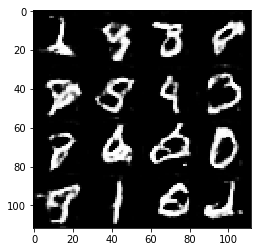

Epoch 3/10... Discriminator Loss: 0.3618... Generator Loss: 1.6488
Epoch 3/10... Discriminator Loss: 0.4358... Generator Loss: 1.7646
Epoch 3/10... Discriminator Loss: 0.3981... Generator Loss: 1.8466
Epoch 3/10... Discriminator Loss: 0.7399... Generator Loss: 0.8786
Epoch 3/10... Discriminator Loss: 0.8128... Generator Loss: 0.7681
Epoch 3/10... Discriminator Loss: 0.3818... Generator Loss: 1.5858
Epoch 3/10... Discriminator Loss: 0.7362... Generator Loss: 0.8935
Epoch 3/10... Discriminator Loss: 0.4765... Generator Loss: 1.4323
Epoch 3/10... Discriminator Loss: 0.6761... Generator Loss: 3.2686
Epoch 3/10... Discriminator Loss: 0.4521... Generator Loss: 1.4423


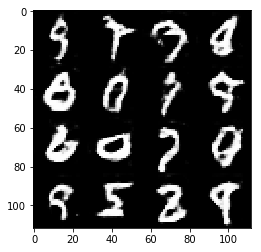

Epoch 3/10... Discriminator Loss: 0.4581... Generator Loss: 1.4286
Epoch 3/10... Discriminator Loss: 0.5356... Generator Loss: 1.3127
Epoch 3/10... Discriminator Loss: 1.4807... Generator Loss: 0.3402
Epoch 3/10... Discriminator Loss: 0.3876... Generator Loss: 1.9408
Epoch 3/10... Discriminator Loss: 0.5652... Generator Loss: 1.1715
Epoch 3/10... Discriminator Loss: 0.9828... Generator Loss: 0.7978
Epoch 3/10... Discriminator Loss: 0.3400... Generator Loss: 1.6654
Epoch 3/10... Discriminator Loss: 0.2609... Generator Loss: 2.1207
Epoch 3/10... Discriminator Loss: 0.6781... Generator Loss: 1.1916
Epoch 3/10... Discriminator Loss: 0.4209... Generator Loss: 2.0032


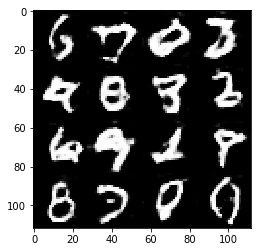

Epoch 3/10... Discriminator Loss: 0.6765... Generator Loss: 1.0624
Epoch 3/10... Discriminator Loss: 0.3682... Generator Loss: 1.8763
Epoch 3/10... Discriminator Loss: 0.5245... Generator Loss: 1.3483
Epoch 3/10... Discriminator Loss: 0.4963... Generator Loss: 1.3824
Epoch 3/10... Discriminator Loss: 0.3995... Generator Loss: 1.4833
Epoch 3/10... Discriminator Loss: 0.4611... Generator Loss: 1.8183
Epoch 3/10... Discriminator Loss: 0.2988... Generator Loss: 2.7282
Epoch 3/10... Discriminator Loss: 0.4985... Generator Loss: 1.3390
Epoch 3/10... Discriminator Loss: 0.4514... Generator Loss: 1.5783
Epoch 3/10... Discriminator Loss: 0.2930... Generator Loss: 2.0414


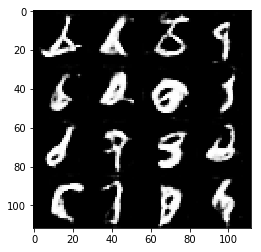

Epoch 3/10... Discriminator Loss: 0.5701... Generator Loss: 1.6666
Epoch 3/10... Discriminator Loss: 0.4161... Generator Loss: 1.8917
Epoch 3/10... Discriminator Loss: 0.4111... Generator Loss: 2.1557
Epoch 3/10... Discriminator Loss: 0.3529... Generator Loss: 1.6739
Epoch 3/10... Discriminator Loss: 0.6011... Generator Loss: 1.2251
Epoch 3/10... Discriminator Loss: 0.4942... Generator Loss: 1.3678
Epoch 3/10... Discriminator Loss: 0.3919... Generator Loss: 1.4691
Epoch 3/10... Discriminator Loss: 0.4105... Generator Loss: 2.5929
Epoch 3/10... Discriminator Loss: 0.5009... Generator Loss: 2.3364
Epoch 3/10... Discriminator Loss: 0.3329... Generator Loss: 2.1882


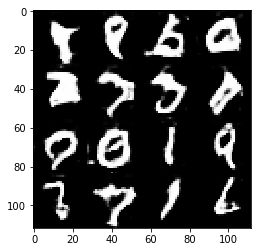

Epoch 3/10... Discriminator Loss: 0.4309... Generator Loss: 1.6127
Epoch 3/10... Discriminator Loss: 0.5025... Generator Loss: 1.7136
Epoch 3/10... Discriminator Loss: 0.5722... Generator Loss: 1.2309
Epoch 3/10... Discriminator Loss: 0.3370... Generator Loss: 1.8338
Epoch 3/10... Discriminator Loss: 0.3510... Generator Loss: 1.7979
Epoch 3/10... Discriminator Loss: 0.3509... Generator Loss: 2.0869
Epoch 3/10... Discriminator Loss: 0.4229... Generator Loss: 1.3740
Epoch 3/10... Discriminator Loss: 0.5685... Generator Loss: 1.1908
Epoch 3/10... Discriminator Loss: 0.3369... Generator Loss: 1.8138
Epoch 3/10... Discriminator Loss: 0.2766... Generator Loss: 2.0839


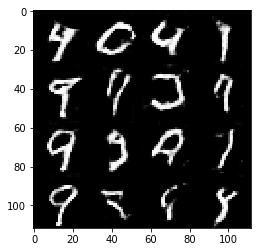

Epoch 3/10... Discriminator Loss: 0.2502... Generator Loss: 2.3308
Epoch 3/10... Discriminator Loss: 1.2242... Generator Loss: 1.7685
Epoch 3/10... Discriminator Loss: 0.8837... Generator Loss: 3.5543
Epoch 3/10... Discriminator Loss: 0.7876... Generator Loss: 1.0547
Epoch 3/10... Discriminator Loss: 0.8682... Generator Loss: 0.9541
Epoch 3/10... Discriminator Loss: 0.3453... Generator Loss: 2.2397
Epoch 3/10... Discriminator Loss: 0.5297... Generator Loss: 1.2108
Epoch 3/10... Discriminator Loss: 0.6268... Generator Loss: 1.2750
Epoch 3/10... Discriminator Loss: 0.2534... Generator Loss: 2.3775
Epoch 3/10... Discriminator Loss: 0.4230... Generator Loss: 1.8397


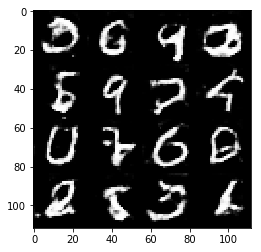

Epoch 3/10... Discriminator Loss: 0.3695... Generator Loss: 1.8917
Epoch 3/10... Discriminator Loss: 0.4439... Generator Loss: 1.5009
Epoch 3/10... Discriminator Loss: 0.6846... Generator Loss: 0.9456
Epoch 3/10... Discriminator Loss: 0.5678... Generator Loss: 1.1730
Epoch 3/10... Discriminator Loss: 0.2864... Generator Loss: 2.1068
Epoch 3/10... Discriminator Loss: 0.5261... Generator Loss: 2.1108
Epoch 3/10... Discriminator Loss: 0.3797... Generator Loss: 1.9303
Epoch 3/10... Discriminator Loss: 0.5527... Generator Loss: 1.9918
Epoch 3/10... Discriminator Loss: 0.6232... Generator Loss: 1.0930
Epoch 3/10... Discriminator Loss: 0.3939... Generator Loss: 1.6712


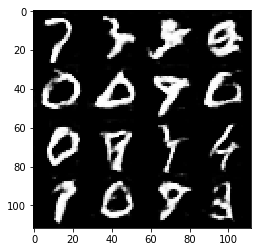

Epoch 3/10... Discriminator Loss: 0.3870... Generator Loss: 1.7167
Epoch 3/10... Discriminator Loss: 0.4162... Generator Loss: 1.7871
Epoch 3/10... Discriminator Loss: 0.3686... Generator Loss: 1.7740
Epoch 3/10... Discriminator Loss: 0.5170... Generator Loss: 1.1811
Epoch 3/10... Discriminator Loss: 0.3987... Generator Loss: 1.5534
Epoch 3/10... Discriminator Loss: 0.6361... Generator Loss: 0.9663
Epoch 3/10... Discriminator Loss: 0.6106... Generator Loss: 1.0833
Epoch 3/10... Discriminator Loss: 0.4075... Generator Loss: 1.8426
Epoch 3/10... Discriminator Loss: 0.3044... Generator Loss: 2.0937
Epoch 3/10... Discriminator Loss: 0.2904... Generator Loss: 2.0634


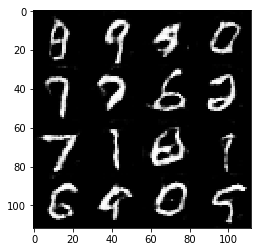

Epoch 3/10... Discriminator Loss: 0.5511... Generator Loss: 1.2139
Epoch 3/10... Discriminator Loss: 0.3225... Generator Loss: 1.8083
Epoch 3/10... Discriminator Loss: 0.3367... Generator Loss: 1.7516
Epoch 3/10... Discriminator Loss: 0.3847... Generator Loss: 1.7399
Epoch 3/10... Discriminator Loss: 0.3090... Generator Loss: 2.1942
Epoch 3/10... Discriminator Loss: 0.5922... Generator Loss: 1.2528
Epoch 3/10... Discriminator Loss: 0.3689... Generator Loss: 1.9350
Epoch 3/10... Discriminator Loss: 0.2744... Generator Loss: 2.0414
Epoch 3/10... Discriminator Loss: 0.4368... Generator Loss: 1.5211
Epoch 3/10... Discriminator Loss: 0.2934... Generator Loss: 2.0615


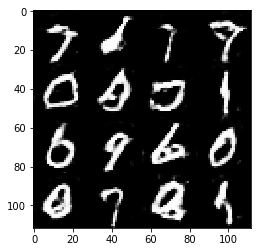

Epoch 3/10... Discriminator Loss: 0.4380... Generator Loss: 1.6178
Epoch 3/10... Discriminator Loss: 0.4159... Generator Loss: 1.5738
Epoch 3/10... Discriminator Loss: 0.3464... Generator Loss: 1.7734
Epoch 3/10... Discriminator Loss: 0.3095... Generator Loss: 1.7438
Epoch 3/10... Discriminator Loss: 0.6100... Generator Loss: 1.0394
Epoch 3/10... Discriminator Loss: 0.4928... Generator Loss: 2.6368
Epoch 3/10... Discriminator Loss: 0.4264... Generator Loss: 2.0780
Epoch 3/10... Discriminator Loss: 0.4866... Generator Loss: 1.4475
Epoch 3/10... Discriminator Loss: 0.4785... Generator Loss: 1.3559
Epoch 3/10... Discriminator Loss: 0.3767... Generator Loss: 2.7729


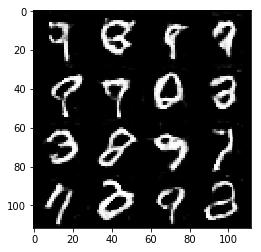

Epoch 3/10... Discriminator Loss: 0.3489... Generator Loss: 1.8582
Epoch 3/10... Discriminator Loss: 0.4084... Generator Loss: 1.6552
Epoch 3/10... Discriminator Loss: 0.2856... Generator Loss: 2.4242
Epoch 3/10... Discriminator Loss: 0.4120... Generator Loss: 1.5814
Epoch 3/10... Discriminator Loss: 0.5229... Generator Loss: 1.2994
Epoch 3/10... Discriminator Loss: 0.3159... Generator Loss: 2.5245
Epoch 3/10... Discriminator Loss: 0.9021... Generator Loss: 0.7068
Epoch 3/10... Discriminator Loss: 3.6173... Generator Loss: 0.0647
Epoch 3/10... Discriminator Loss: 0.4602... Generator Loss: 1.4985
Epoch 3/10... Discriminator Loss: 0.5508... Generator Loss: 2.7224


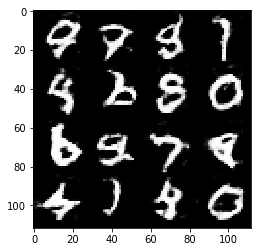

Epoch 3/10... Discriminator Loss: 0.8728... Generator Loss: 0.8101
Epoch 3/10... Discriminator Loss: 0.4189... Generator Loss: 1.5871
Epoch 3/10... Discriminator Loss: 0.3308... Generator Loss: 2.0474
Epoch 3/10... Discriminator Loss: 0.4387... Generator Loss: 1.5861
Epoch 3/10... Discriminator Loss: 0.3736... Generator Loss: 1.8403
Epoch 3/10... Discriminator Loss: 0.3485... Generator Loss: 1.7995
Epoch 3/10... Discriminator Loss: 0.4021... Generator Loss: 2.0989
Epoch 3/10... Discriminator Loss: 0.3726... Generator Loss: 1.8161
Epoch 3/10... Discriminator Loss: 0.4220... Generator Loss: 1.4399
Epoch 3/10... Discriminator Loss: 0.3290... Generator Loss: 1.7563


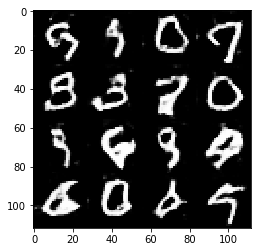

Epoch 3/10... Discriminator Loss: 0.5063... Generator Loss: 1.2883
Epoch 3/10... Discriminator Loss: 0.6972... Generator Loss: 0.9675
Epoch 3/10... Discriminator Loss: 0.2353... Generator Loss: 2.1288
Epoch 3/10... Discriminator Loss: 0.4848... Generator Loss: 1.6665
Epoch 3/10... Discriminator Loss: 0.2257... Generator Loss: 2.1333
Epoch 3/10... Discriminator Loss: 0.5665... Generator Loss: 1.1068
Epoch 3/10... Discriminator Loss: 0.2364... Generator Loss: 2.1749
Epoch 3/10... Discriminator Loss: 0.4393... Generator Loss: 1.3985
Epoch 3/10... Discriminator Loss: 0.2664... Generator Loss: 2.0861
Epoch 3/10... Discriminator Loss: 0.3024... Generator Loss: 2.0286


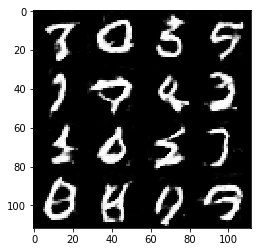

Epoch 3/10... Discriminator Loss: 0.4362... Generator Loss: 2.8206
Epoch 3/10... Discriminator Loss: 0.3827... Generator Loss: 1.8129
Epoch 3/10... Discriminator Loss: 0.3643... Generator Loss: 1.8021
Epoch 3/10... Discriminator Loss: 1.9937... Generator Loss: 0.4944
Epoch 3/10... Discriminator Loss: 1.1405... Generator Loss: 0.7336
Epoch 3/10... Discriminator Loss: 0.5775... Generator Loss: 1.9965
Epoch 3/10... Discriminator Loss: 0.3479... Generator Loss: 2.0308
Epoch 3/10... Discriminator Loss: 0.3897... Generator Loss: 1.6120
Epoch 3/10... Discriminator Loss: 0.3622... Generator Loss: 2.0870
Epoch 3/10... Discriminator Loss: 0.3820... Generator Loss: 1.8444


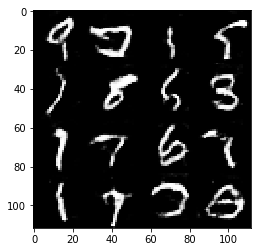

Epoch 3/10... Discriminator Loss: 0.2848... Generator Loss: 2.1253
Epoch 3/10... Discriminator Loss: 0.6229... Generator Loss: 1.0802
Epoch 3/10... Discriminator Loss: 0.2018... Generator Loss: 2.6519
Epoch 3/10... Discriminator Loss: 0.3718... Generator Loss: 1.7657
Epoch 3/10... Discriminator Loss: 0.4109... Generator Loss: 1.5754
Epoch 3/10... Discriminator Loss: 0.3396... Generator Loss: 1.9466
Epoch 3/10... Discriminator Loss: 0.6762... Generator Loss: 3.0957
Epoch 3/10... Discriminator Loss: 0.6097... Generator Loss: 1.1596
Epoch 3/10... Discriminator Loss: 0.7147... Generator Loss: 1.0873
Epoch 3/10... Discriminator Loss: 0.3345... Generator Loss: 1.9149


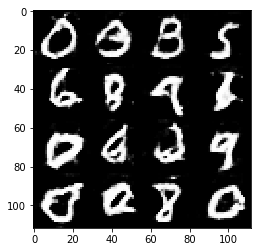

Epoch 3/10... Discriminator Loss: 0.3588... Generator Loss: 1.9841
Epoch 3/10... Discriminator Loss: 0.4823... Generator Loss: 1.3006
Epoch 3/10... Discriminator Loss: 0.3408... Generator Loss: 1.7829
Epoch 3/10... Discriminator Loss: 0.3416... Generator Loss: 2.1037
Epoch 3/10... Discriminator Loss: 0.2258... Generator Loss: 2.4967
Epoch 3/10... Discriminator Loss: 0.3610... Generator Loss: 1.8210
Epoch 3/10... Discriminator Loss: 0.3431... Generator Loss: 1.7019
Epoch 3/10... Discriminator Loss: 0.6592... Generator Loss: 1.0145
Epoch 3/10... Discriminator Loss: 0.2166... Generator Loss: 2.4931
Epoch 3/10... Discriminator Loss: 0.4999... Generator Loss: 1.1897


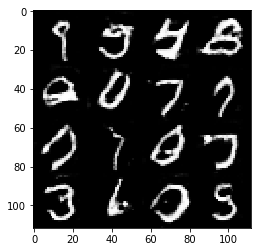

Epoch 3/10... Discriminator Loss: 0.4207... Generator Loss: 1.5967
Epoch 3/10... Discriminator Loss: 0.3061... Generator Loss: 2.5471
Epoch 4/10... Discriminator Loss: 0.3511... Generator Loss: 1.7307
Epoch 4/10... Discriminator Loss: 0.4366... Generator Loss: 1.4105
Epoch 4/10... Discriminator Loss: 0.2410... Generator Loss: 2.3320
Epoch 4/10... Discriminator Loss: 0.4755... Generator Loss: 1.3981
Epoch 4/10... Discriminator Loss: 0.3869... Generator Loss: 1.5559
Epoch 4/10... Discriminator Loss: 0.4523... Generator Loss: 1.4654
Epoch 4/10... Discriminator Loss: 0.3060... Generator Loss: 2.1173
Epoch 4/10... Discriminator Loss: 0.3269... Generator Loss: 2.4759


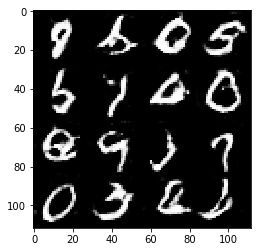

Epoch 4/10... Discriminator Loss: 0.3423... Generator Loss: 2.1666
Epoch 4/10... Discriminator Loss: 0.6775... Generator Loss: 0.9585
Epoch 4/10... Discriminator Loss: 0.4882... Generator Loss: 1.5721
Epoch 4/10... Discriminator Loss: 0.2568... Generator Loss: 2.2695
Epoch 4/10... Discriminator Loss: 0.4582... Generator Loss: 1.7298
Epoch 4/10... Discriminator Loss: 0.3731... Generator Loss: 1.6007
Epoch 4/10... Discriminator Loss: 0.3977... Generator Loss: 1.7153
Epoch 4/10... Discriminator Loss: 0.4366... Generator Loss: 1.3385
Epoch 4/10... Discriminator Loss: 0.2476... Generator Loss: 1.9775
Epoch 4/10... Discriminator Loss: 0.6383... Generator Loss: 1.4308


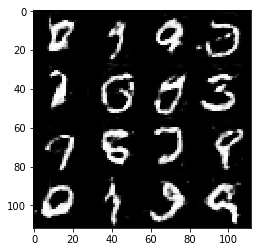

Epoch 4/10... Discriminator Loss: 0.3243... Generator Loss: 1.8156
Epoch 4/10... Discriminator Loss: 0.4116... Generator Loss: 2.7246
Epoch 4/10... Discriminator Loss: 0.5578... Generator Loss: 1.2221
Epoch 4/10... Discriminator Loss: 0.2989... Generator Loss: 2.2235
Epoch 4/10... Discriminator Loss: 0.3061... Generator Loss: 2.0961
Epoch 4/10... Discriminator Loss: 0.6521... Generator Loss: 0.9998
Epoch 4/10... Discriminator Loss: 0.4452... Generator Loss: 2.6507
Epoch 4/10... Discriminator Loss: 0.3227... Generator Loss: 2.0332
Epoch 4/10... Discriminator Loss: 0.3689... Generator Loss: 2.6404
Epoch 4/10... Discriminator Loss: 0.4110... Generator Loss: 1.4960


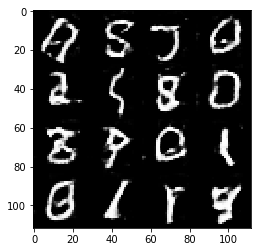

Epoch 4/10... Discriminator Loss: 0.3547... Generator Loss: 1.6748
Epoch 4/10... Discriminator Loss: 0.3416... Generator Loss: 1.8643
Epoch 4/10... Discriminator Loss: 0.3241... Generator Loss: 1.9204
Epoch 4/10... Discriminator Loss: 0.2615... Generator Loss: 2.0837
Epoch 4/10... Discriminator Loss: 0.3432... Generator Loss: 1.8744
Epoch 4/10... Discriminator Loss: 1.3829... Generator Loss: 4.6127
Epoch 4/10... Discriminator Loss: 0.2703... Generator Loss: 3.4786
Epoch 4/10... Discriminator Loss: 0.3485... Generator Loss: 1.9897
Epoch 4/10... Discriminator Loss: 0.2942... Generator Loss: 2.4370
Epoch 4/10... Discriminator Loss: 0.6427... Generator Loss: 2.6725


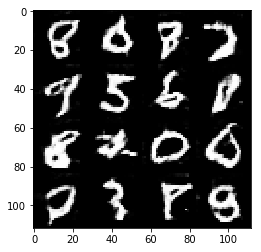

Epoch 4/10... Discriminator Loss: 0.2908... Generator Loss: 2.5193
Epoch 4/10... Discriminator Loss: 0.3551... Generator Loss: 2.4609
Epoch 4/10... Discriminator Loss: 0.3436... Generator Loss: 1.7463
Epoch 4/10... Discriminator Loss: 0.3973... Generator Loss: 1.7263
Epoch 4/10... Discriminator Loss: 0.2814... Generator Loss: 2.1711
Epoch 4/10... Discriminator Loss: 0.4509... Generator Loss: 1.3935
Epoch 4/10... Discriminator Loss: 0.4192... Generator Loss: 1.3987
Epoch 4/10... Discriminator Loss: 0.4720... Generator Loss: 1.8514
Epoch 4/10... Discriminator Loss: 0.5241... Generator Loss: 1.4112
Epoch 4/10... Discriminator Loss: 0.1486... Generator Loss: 2.9156


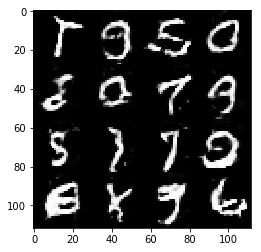

Epoch 4/10... Discriminator Loss: 0.4568... Generator Loss: 1.3958
Epoch 4/10... Discriminator Loss: 0.3815... Generator Loss: 2.0706
Epoch 4/10... Discriminator Loss: 0.4676... Generator Loss: 1.2454
Epoch 4/10... Discriminator Loss: 0.4264... Generator Loss: 1.5565
Epoch 4/10... Discriminator Loss: 0.3258... Generator Loss: 1.8598
Epoch 4/10... Discriminator Loss: 0.8234... Generator Loss: 2.1855
Epoch 4/10... Discriminator Loss: 0.4227... Generator Loss: 3.3518
Epoch 4/10... Discriminator Loss: 0.3920... Generator Loss: 1.6745
Epoch 4/10... Discriminator Loss: 0.4133... Generator Loss: 2.5306
Epoch 4/10... Discriminator Loss: 0.3054... Generator Loss: 2.1488


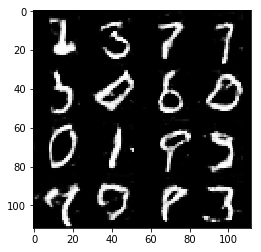

Epoch 4/10... Discriminator Loss: 0.3662... Generator Loss: 1.6104
Epoch 4/10... Discriminator Loss: 0.5020... Generator Loss: 1.6820
Epoch 4/10... Discriminator Loss: 0.3523... Generator Loss: 1.7268
Epoch 4/10... Discriminator Loss: 0.2958... Generator Loss: 2.3537
Epoch 4/10... Discriminator Loss: 0.4854... Generator Loss: 2.2952
Epoch 4/10... Discriminator Loss: 0.3966... Generator Loss: 1.7011
Epoch 4/10... Discriminator Loss: 0.3456... Generator Loss: 1.7234
Epoch 4/10... Discriminator Loss: 0.2129... Generator Loss: 2.5254
Epoch 4/10... Discriminator Loss: 0.4345... Generator Loss: 1.5120
Epoch 4/10... Discriminator Loss: 0.4917... Generator Loss: 1.4981


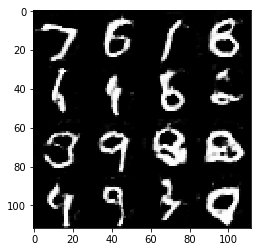

Epoch 4/10... Discriminator Loss: 0.4180... Generator Loss: 1.4476
Epoch 4/10... Discriminator Loss: 0.2137... Generator Loss: 2.3565
Epoch 4/10... Discriminator Loss: 0.4020... Generator Loss: 1.5054
Epoch 4/10... Discriminator Loss: 0.3586... Generator Loss: 1.9473
Epoch 4/10... Discriminator Loss: 0.3644... Generator Loss: 2.4072
Epoch 4/10... Discriminator Loss: 0.4712... Generator Loss: 1.3911
Epoch 4/10... Discriminator Loss: 0.2790... Generator Loss: 2.0299
Epoch 4/10... Discriminator Loss: 0.4060... Generator Loss: 2.7072
Epoch 4/10... Discriminator Loss: 0.7336... Generator Loss: 1.0310
Epoch 4/10... Discriminator Loss: 0.3586... Generator Loss: 1.6131


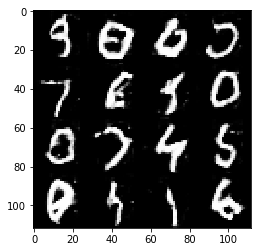

Epoch 4/10... Discriminator Loss: 0.3301... Generator Loss: 2.2268
Epoch 4/10... Discriminator Loss: 0.4606... Generator Loss: 1.4204
Epoch 4/10... Discriminator Loss: 0.3497... Generator Loss: 2.6010
Epoch 4/10... Discriminator Loss: 0.2324... Generator Loss: 2.0847
Epoch 4/10... Discriminator Loss: 0.5038... Generator Loss: 2.2523
Epoch 4/10... Discriminator Loss: 0.3190... Generator Loss: 2.0455
Epoch 4/10... Discriminator Loss: 0.4832... Generator Loss: 1.2899
Epoch 4/10... Discriminator Loss: 0.4019... Generator Loss: 1.9091
Epoch 4/10... Discriminator Loss: 0.4008... Generator Loss: 1.5328
Epoch 4/10... Discriminator Loss: 0.3209... Generator Loss: 2.1236


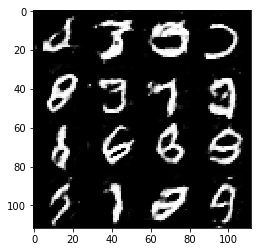

Epoch 4/10... Discriminator Loss: 0.3198... Generator Loss: 1.7699
Epoch 4/10... Discriminator Loss: 0.4102... Generator Loss: 1.6550
Epoch 4/10... Discriminator Loss: 0.2802... Generator Loss: 1.9842
Epoch 4/10... Discriminator Loss: 0.5692... Generator Loss: 1.3150
Epoch 4/10... Discriminator Loss: 0.3437... Generator Loss: 2.2384
Epoch 4/10... Discriminator Loss: 0.4200... Generator Loss: 2.6304
Epoch 4/10... Discriminator Loss: 0.6367... Generator Loss: 1.3181
Epoch 4/10... Discriminator Loss: 0.4013... Generator Loss: 1.8819
Epoch 4/10... Discriminator Loss: 0.6115... Generator Loss: 1.1257
Epoch 4/10... Discriminator Loss: 0.3724... Generator Loss: 2.0154


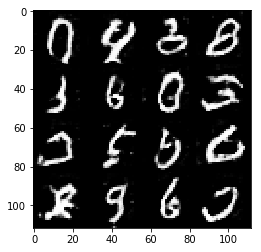

Epoch 4/10... Discriminator Loss: 0.3782... Generator Loss: 1.7564
Epoch 4/10... Discriminator Loss: 0.3039... Generator Loss: 2.3145
Epoch 4/10... Discriminator Loss: 0.3140... Generator Loss: 1.6983
Epoch 4/10... Discriminator Loss: 0.3358... Generator Loss: 1.9165
Epoch 4/10... Discriminator Loss: 0.3987... Generator Loss: 1.6070
Epoch 4/10... Discriminator Loss: 0.2108... Generator Loss: 2.4549
Epoch 4/10... Discriminator Loss: 0.5777... Generator Loss: 1.1653
Epoch 4/10... Discriminator Loss: 0.2023... Generator Loss: 2.6404
Epoch 4/10... Discriminator Loss: 0.3313... Generator Loss: 1.7880
Epoch 4/10... Discriminator Loss: 0.5049... Generator Loss: 1.1719


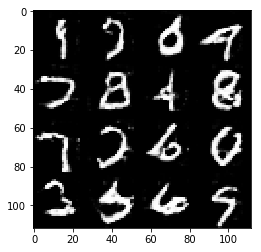

Epoch 4/10... Discriminator Loss: 0.6089... Generator Loss: 1.1650
Epoch 4/10... Discriminator Loss: 0.3396... Generator Loss: 1.8392
Epoch 4/10... Discriminator Loss: 0.4082... Generator Loss: 1.9542
Epoch 4/10... Discriminator Loss: 0.3510... Generator Loss: 1.9908
Epoch 4/10... Discriminator Loss: 0.3137... Generator Loss: 2.3257
Epoch 4/10... Discriminator Loss: 0.8446... Generator Loss: 0.8290
Epoch 4/10... Discriminator Loss: 0.2716... Generator Loss: 2.5031
Epoch 4/10... Discriminator Loss: 0.3799... Generator Loss: 1.9022
Epoch 4/10... Discriminator Loss: 0.4341... Generator Loss: 1.6568
Epoch 4/10... Discriminator Loss: 0.4997... Generator Loss: 1.3335


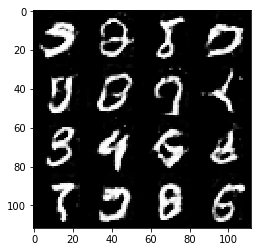

Epoch 4/10... Discriminator Loss: 0.3008... Generator Loss: 1.8800
Epoch 4/10... Discriminator Loss: 0.3761... Generator Loss: 1.5650
Epoch 4/10... Discriminator Loss: 0.3113... Generator Loss: 1.8130
Epoch 4/10... Discriminator Loss: 0.9445... Generator Loss: 0.7408
Epoch 4/10... Discriminator Loss: 0.6363... Generator Loss: 1.2870
Epoch 4/10... Discriminator Loss: 0.3368... Generator Loss: 2.1109
Epoch 4/10... Discriminator Loss: 0.3773... Generator Loss: 1.8398
Epoch 4/10... Discriminator Loss: 0.6674... Generator Loss: 1.0442
Epoch 4/10... Discriminator Loss: 0.4886... Generator Loss: 1.5833
Epoch 4/10... Discriminator Loss: 0.4394... Generator Loss: 1.5623


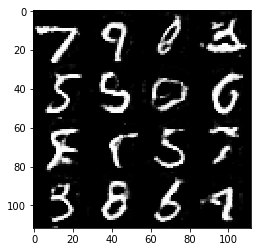

Epoch 4/10... Discriminator Loss: 0.3975... Generator Loss: 1.6296
Epoch 4/10... Discriminator Loss: 0.3235... Generator Loss: 1.9652
Epoch 4/10... Discriminator Loss: 0.5106... Generator Loss: 2.0269
Epoch 4/10... Discriminator Loss: 0.5196... Generator Loss: 1.3885
Epoch 4/10... Discriminator Loss: 0.5278... Generator Loss: 1.2770
Epoch 4/10... Discriminator Loss: 0.4080... Generator Loss: 1.8189
Epoch 4/10... Discriminator Loss: 1.3921... Generator Loss: 3.5754
Epoch 4/10... Discriminator Loss: 1.2215... Generator Loss: 0.7472
Epoch 4/10... Discriminator Loss: 0.5918... Generator Loss: 2.1121
Epoch 4/10... Discriminator Loss: 0.4958... Generator Loss: 2.5460


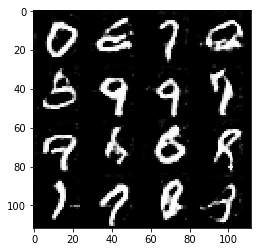

Epoch 4/10... Discriminator Loss: 0.3830... Generator Loss: 1.8274
Epoch 4/10... Discriminator Loss: 0.3512... Generator Loss: 1.7884
Epoch 4/10... Discriminator Loss: 0.3397... Generator Loss: 2.4998
Epoch 4/10... Discriminator Loss: 0.5925... Generator Loss: 1.3331
Epoch 4/10... Discriminator Loss: 0.3415... Generator Loss: 2.1761
Epoch 4/10... Discriminator Loss: 0.4200... Generator Loss: 1.7558
Epoch 4/10... Discriminator Loss: 0.3717... Generator Loss: 2.1671
Epoch 4/10... Discriminator Loss: 0.3648... Generator Loss: 1.8286
Epoch 4/10... Discriminator Loss: 0.2757... Generator Loss: 2.3086
Epoch 4/10... Discriminator Loss: 0.4435... Generator Loss: 1.6119


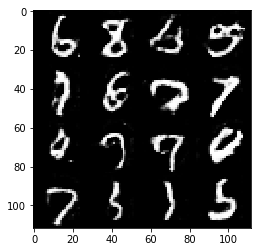

Epoch 4/10... Discriminator Loss: 0.3381... Generator Loss: 1.8575
Epoch 4/10... Discriminator Loss: 0.4112... Generator Loss: 1.9507
Epoch 4/10... Discriminator Loss: 0.3237... Generator Loss: 1.7265
Epoch 4/10... Discriminator Loss: 0.2575... Generator Loss: 2.7264
Epoch 4/10... Discriminator Loss: 0.4208... Generator Loss: 1.6182
Epoch 4/10... Discriminator Loss: 0.4794... Generator Loss: 1.4229
Epoch 4/10... Discriminator Loss: 0.5229... Generator Loss: 1.9683
Epoch 4/10... Discriminator Loss: 0.4856... Generator Loss: 1.6138
Epoch 4/10... Discriminator Loss: 0.4263... Generator Loss: 1.6097
Epoch 4/10... Discriminator Loss: 0.4714... Generator Loss: 1.6212


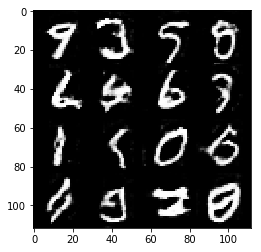

Epoch 4/10... Discriminator Loss: 0.4399... Generator Loss: 1.3705
Epoch 4/10... Discriminator Loss: 0.4666... Generator Loss: 2.4569
Epoch 4/10... Discriminator Loss: 0.3685... Generator Loss: 2.4689
Epoch 4/10... Discriminator Loss: 0.3284... Generator Loss: 1.9306
Epoch 4/10... Discriminator Loss: 0.5137... Generator Loss: 1.6322
Epoch 4/10... Discriminator Loss: 0.3872... Generator Loss: 1.6260
Epoch 4/10... Discriminator Loss: 0.3401... Generator Loss: 1.8886
Epoch 4/10... Discriminator Loss: 0.6905... Generator Loss: 1.0820
Epoch 4/10... Discriminator Loss: 0.3746... Generator Loss: 1.9115
Epoch 4/10... Discriminator Loss: 0.3229... Generator Loss: 2.1862


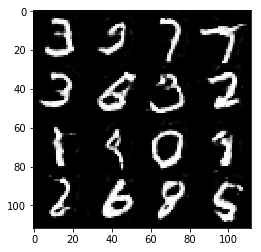

Epoch 4/10... Discriminator Loss: 0.6188... Generator Loss: 1.2084
Epoch 4/10... Discriminator Loss: 0.2836... Generator Loss: 2.0133
Epoch 4/10... Discriminator Loss: 0.4906... Generator Loss: 1.3629
Epoch 4/10... Discriminator Loss: 0.3956... Generator Loss: 1.8175
Epoch 4/10... Discriminator Loss: 0.2863... Generator Loss: 1.9363
Epoch 4/10... Discriminator Loss: 0.2065... Generator Loss: 2.6542
Epoch 4/10... Discriminator Loss: 0.4539... Generator Loss: 1.5479
Epoch 4/10... Discriminator Loss: 0.3059... Generator Loss: 1.8773
Epoch 4/10... Discriminator Loss: 0.4390... Generator Loss: 1.5533
Epoch 4/10... Discriminator Loss: 0.3854... Generator Loss: 2.0467


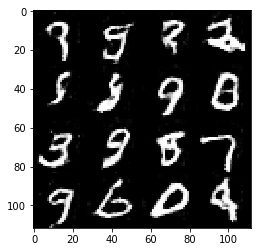

Epoch 4/10... Discriminator Loss: 0.4171... Generator Loss: 1.8960
Epoch 4/10... Discriminator Loss: 0.4483... Generator Loss: 1.7452
Epoch 4/10... Discriminator Loss: 0.6387... Generator Loss: 1.0408
Epoch 4/10... Discriminator Loss: 0.4035... Generator Loss: 1.8815
Epoch 4/10... Discriminator Loss: 0.4180... Generator Loss: 1.9768
Epoch 4/10... Discriminator Loss: 0.4084... Generator Loss: 2.3913
Epoch 4/10... Discriminator Loss: 0.4064... Generator Loss: 2.6607
Epoch 4/10... Discriminator Loss: 0.4243... Generator Loss: 1.6788
Epoch 4/10... Discriminator Loss: 0.3853... Generator Loss: 1.8293
Epoch 4/10... Discriminator Loss: 0.3120... Generator Loss: 2.0625


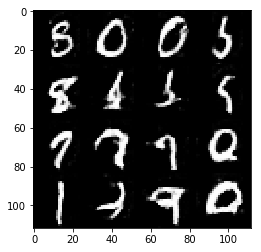

Epoch 5/10... Discriminator Loss: 0.2385... Generator Loss: 2.4456
Epoch 5/10... Discriminator Loss: 0.3846... Generator Loss: 1.7575
Epoch 5/10... Discriminator Loss: 0.4729... Generator Loss: 1.4781
Epoch 5/10... Discriminator Loss: 0.3720... Generator Loss: 1.7932
Epoch 5/10... Discriminator Loss: 0.3104... Generator Loss: 2.0363
Epoch 5/10... Discriminator Loss: 1.1702... Generator Loss: 0.5267
Epoch 5/10... Discriminator Loss: 3.7421... Generator Loss: 0.1296
Epoch 5/10... Discriminator Loss: 0.4407... Generator Loss: 1.8727
Epoch 5/10... Discriminator Loss: 0.3492... Generator Loss: 2.6797
Epoch 5/10... Discriminator Loss: 0.3107... Generator Loss: 2.0666


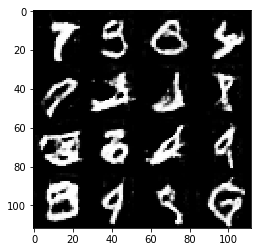

Epoch 5/10... Discriminator Loss: 0.3356... Generator Loss: 1.8648
Epoch 5/10... Discriminator Loss: 0.4055... Generator Loss: 1.6055
Epoch 5/10... Discriminator Loss: 0.5132... Generator Loss: 1.5610
Epoch 5/10... Discriminator Loss: 0.4836... Generator Loss: 1.5923
Epoch 5/10... Discriminator Loss: 0.4153... Generator Loss: 1.5963
Epoch 5/10... Discriminator Loss: 0.3100... Generator Loss: 2.0833
Epoch 5/10... Discriminator Loss: 0.6682... Generator Loss: 1.1268
Epoch 5/10... Discriminator Loss: 0.3929... Generator Loss: 1.9149
Epoch 5/10... Discriminator Loss: 0.2985... Generator Loss: 1.9788
Epoch 5/10... Discriminator Loss: 0.4280... Generator Loss: 2.0575


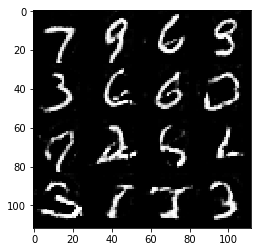

Epoch 5/10... Discriminator Loss: 0.4578... Generator Loss: 1.6412
Epoch 5/10... Discriminator Loss: 0.4217... Generator Loss: 1.4262
Epoch 5/10... Discriminator Loss: 0.2910... Generator Loss: 1.9021
Epoch 5/10... Discriminator Loss: 0.2222... Generator Loss: 2.6896
Epoch 5/10... Discriminator Loss: 0.4566... Generator Loss: 2.2678
Epoch 5/10... Discriminator Loss: 0.3056... Generator Loss: 2.2872
Epoch 5/10... Discriminator Loss: 0.3591... Generator Loss: 1.9923
Epoch 5/10... Discriminator Loss: 0.3783... Generator Loss: 1.7433
Epoch 5/10... Discriminator Loss: 0.6902... Generator Loss: 0.9966
Epoch 5/10... Discriminator Loss: 0.7291... Generator Loss: 0.9044


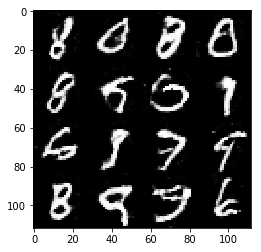

Epoch 5/10... Discriminator Loss: 0.3177... Generator Loss: 2.2932
Epoch 5/10... Discriminator Loss: 0.6690... Generator Loss: 0.9802
Epoch 5/10... Discriminator Loss: 0.4774... Generator Loss: 1.3436
Epoch 5/10... Discriminator Loss: 0.6212... Generator Loss: 1.3237
Epoch 5/10... Discriminator Loss: 0.3714... Generator Loss: 1.8146
Epoch 5/10... Discriminator Loss: 0.6470... Generator Loss: 1.0976
Epoch 5/10... Discriminator Loss: 0.6173... Generator Loss: 1.2044
Epoch 5/10... Discriminator Loss: 0.6948... Generator Loss: 0.9739
Epoch 5/10... Discriminator Loss: 0.2614... Generator Loss: 2.1168
Epoch 5/10... Discriminator Loss: 0.4394... Generator Loss: 1.4335


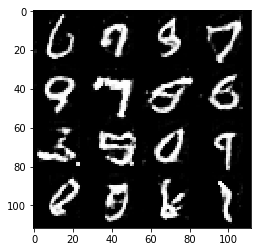

Epoch 5/10... Discriminator Loss: 0.7558... Generator Loss: 1.0180
Epoch 5/10... Discriminator Loss: 0.2337... Generator Loss: 2.3333
Epoch 5/10... Discriminator Loss: 0.2560... Generator Loss: 2.0864
Epoch 5/10... Discriminator Loss: 0.5803... Generator Loss: 1.1023
Epoch 5/10... Discriminator Loss: 0.3404... Generator Loss: 1.9612
Epoch 5/10... Discriminator Loss: 0.3546... Generator Loss: 1.7654
Epoch 5/10... Discriminator Loss: 0.2585... Generator Loss: 2.5202
Epoch 5/10... Discriminator Loss: 0.7425... Generator Loss: 0.9235
Epoch 5/10... Discriminator Loss: 0.4524... Generator Loss: 2.0910
Epoch 5/10... Discriminator Loss: 0.3310... Generator Loss: 1.9969


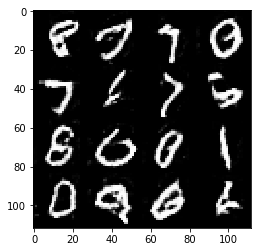

Epoch 5/10... Discriminator Loss: 0.4052... Generator Loss: 2.3245
Epoch 5/10... Discriminator Loss: 0.3203... Generator Loss: 2.1169
Epoch 5/10... Discriminator Loss: 0.3636... Generator Loss: 1.9651
Epoch 5/10... Discriminator Loss: 0.4788... Generator Loss: 1.4975
Epoch 5/10... Discriminator Loss: 0.2262... Generator Loss: 2.4796
Epoch 5/10... Discriminator Loss: 0.5144... Generator Loss: 2.2044
Epoch 5/10... Discriminator Loss: 0.3571... Generator Loss: 1.8914
Epoch 5/10... Discriminator Loss: 0.3515... Generator Loss: 2.0263
Epoch 5/10... Discriminator Loss: 0.3548... Generator Loss: 1.9422
Epoch 5/10... Discriminator Loss: 0.6503... Generator Loss: 1.1830


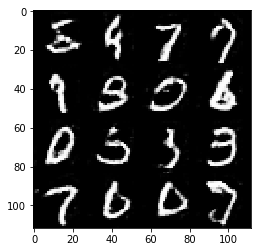

Epoch 5/10... Discriminator Loss: 0.4283... Generator Loss: 1.7092
Epoch 5/10... Discriminator Loss: 0.6138... Generator Loss: 1.2848
Epoch 5/10... Discriminator Loss: 0.3440... Generator Loss: 2.0636
Epoch 5/10... Discriminator Loss: 0.4310... Generator Loss: 1.7579
Epoch 5/10... Discriminator Loss: 0.2866... Generator Loss: 2.5243
Epoch 5/10... Discriminator Loss: 0.3171... Generator Loss: 2.0359
Epoch 5/10... Discriminator Loss: 1.2922... Generator Loss: 4.1052
Epoch 5/10... Discriminator Loss: 0.8998... Generator Loss: 0.7873
Epoch 5/10... Discriminator Loss: 0.2858... Generator Loss: 2.1229
Epoch 5/10... Discriminator Loss: 0.3012... Generator Loss: 2.6569


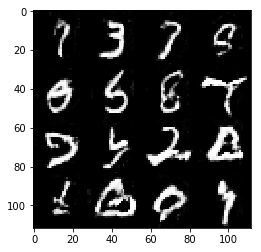

Epoch 5/10... Discriminator Loss: 0.4614... Generator Loss: 1.6138
Epoch 5/10... Discriminator Loss: 0.3606... Generator Loss: 2.2664
Epoch 5/10... Discriminator Loss: 0.3889... Generator Loss: 1.5915
Epoch 5/10... Discriminator Loss: 0.3068... Generator Loss: 2.1116
Epoch 5/10... Discriminator Loss: 0.2340... Generator Loss: 2.1058
Epoch 5/10... Discriminator Loss: 0.1852... Generator Loss: 2.3562
Epoch 5/10... Discriminator Loss: 0.3958... Generator Loss: 1.8923
Epoch 5/10... Discriminator Loss: 0.2797... Generator Loss: 2.1608
Epoch 5/10... Discriminator Loss: 0.3111... Generator Loss: 2.1583
Epoch 5/10... Discriminator Loss: 0.5311... Generator Loss: 1.2534


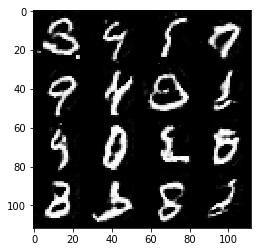

Epoch 5/10... Discriminator Loss: 0.2351... Generator Loss: 2.4069
Epoch 5/10... Discriminator Loss: 0.4978... Generator Loss: 1.3028
Epoch 5/10... Discriminator Loss: 0.4724... Generator Loss: 1.4378
Epoch 5/10... Discriminator Loss: 0.2609... Generator Loss: 2.1496
Epoch 5/10... Discriminator Loss: 0.2902... Generator Loss: 2.1198
Epoch 5/10... Discriminator Loss: 0.3822... Generator Loss: 2.2392
Epoch 5/10... Discriminator Loss: 0.5508... Generator Loss: 1.2223
Epoch 5/10... Discriminator Loss: 1.1596... Generator Loss: 0.5460
Epoch 5/10... Discriminator Loss: 0.2938... Generator Loss: 1.8191
Epoch 5/10... Discriminator Loss: 0.2506... Generator Loss: 2.5260


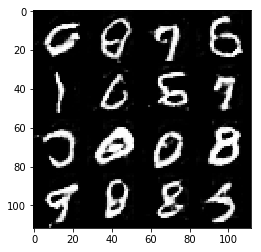

Epoch 5/10... Discriminator Loss: 0.4095... Generator Loss: 1.7043
Epoch 5/10... Discriminator Loss: 0.3538... Generator Loss: 1.8722
Epoch 5/10... Discriminator Loss: 0.5321... Generator Loss: 1.6115
Epoch 5/10... Discriminator Loss: 0.4072... Generator Loss: 1.5986
Epoch 5/10... Discriminator Loss: 0.3683... Generator Loss: 1.6630
Epoch 5/10... Discriminator Loss: 0.3663... Generator Loss: 1.6667
Epoch 5/10... Discriminator Loss: 0.4381... Generator Loss: 1.4503
Epoch 5/10... Discriminator Loss: 0.3681... Generator Loss: 2.2564
Epoch 5/10... Discriminator Loss: 0.4312... Generator Loss: 1.6496
Epoch 5/10... Discriminator Loss: 0.3159... Generator Loss: 2.4319


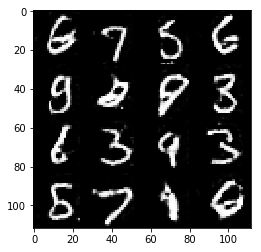

Epoch 5/10... Discriminator Loss: 0.3081... Generator Loss: 2.1480
Epoch 5/10... Discriminator Loss: 0.3962... Generator Loss: 1.7845
Epoch 5/10... Discriminator Loss: 0.2899... Generator Loss: 2.1567
Epoch 5/10... Discriminator Loss: 0.3607... Generator Loss: 1.7277
Epoch 5/10... Discriminator Loss: 0.2274... Generator Loss: 2.3965
Epoch 5/10... Discriminator Loss: 0.6502... Generator Loss: 1.0808
Epoch 5/10... Discriminator Loss: 0.3238... Generator Loss: 1.8198
Epoch 5/10... Discriminator Loss: 0.3976... Generator Loss: 1.6651
Epoch 5/10... Discriminator Loss: 0.2894... Generator Loss: 1.8281
Epoch 5/10... Discriminator Loss: 0.2245... Generator Loss: 2.4458


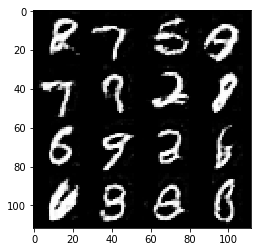

Epoch 5/10... Discriminator Loss: 1.0072... Generator Loss: 0.7395
Epoch 5/10... Discriminator Loss: 0.4960... Generator Loss: 1.5207
Epoch 5/10... Discriminator Loss: 0.3035... Generator Loss: 2.3727
Epoch 5/10... Discriminator Loss: 0.6223... Generator Loss: 1.1922
Epoch 5/10... Discriminator Loss: 0.3556... Generator Loss: 2.0814
Epoch 5/10... Discriminator Loss: 0.4838... Generator Loss: 1.4876
Epoch 5/10... Discriminator Loss: 0.4764... Generator Loss: 1.4846
Epoch 5/10... Discriminator Loss: 0.4398... Generator Loss: 1.5255
Epoch 5/10... Discriminator Loss: 0.2815... Generator Loss: 1.8268
Epoch 5/10... Discriminator Loss: 0.4557... Generator Loss: 1.6062


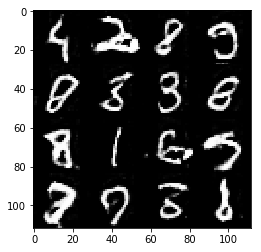

Epoch 5/10... Discriminator Loss: 0.3295... Generator Loss: 1.9316
Epoch 5/10... Discriminator Loss: 0.5728... Generator Loss: 1.5313
Epoch 5/10... Discriminator Loss: 0.4752... Generator Loss: 1.3853
Epoch 5/10... Discriminator Loss: 0.3267... Generator Loss: 1.9614
Epoch 5/10... Discriminator Loss: 0.2823... Generator Loss: 2.5691
Epoch 5/10... Discriminator Loss: 0.3879... Generator Loss: 1.8479
Epoch 5/10... Discriminator Loss: 0.3786... Generator Loss: 1.8080
Epoch 5/10... Discriminator Loss: 0.2861... Generator Loss: 2.1241
Epoch 5/10... Discriminator Loss: 0.4775... Generator Loss: 1.6636
Epoch 5/10... Discriminator Loss: 0.3680... Generator Loss: 1.7191


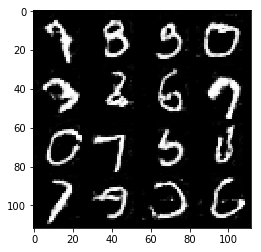

Epoch 5/10... Discriminator Loss: 0.2965... Generator Loss: 2.2758
Epoch 5/10... Discriminator Loss: 0.4509... Generator Loss: 1.7032
Epoch 5/10... Discriminator Loss: 0.4643... Generator Loss: 1.3367
Epoch 5/10... Discriminator Loss: 0.2780... Generator Loss: 2.5058
Epoch 5/10... Discriminator Loss: 0.3739... Generator Loss: 2.1241
Epoch 5/10... Discriminator Loss: 1.0529... Generator Loss: 0.6843
Epoch 5/10... Discriminator Loss: 0.5012... Generator Loss: 1.4838
Epoch 5/10... Discriminator Loss: 0.2139... Generator Loss: 2.2315
Epoch 5/10... Discriminator Loss: 0.3125... Generator Loss: 1.9552
Epoch 5/10... Discriminator Loss: 0.3908... Generator Loss: 2.2368


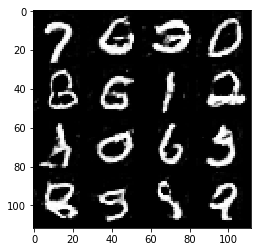

Epoch 5/10... Discriminator Loss: 0.2454... Generator Loss: 2.1415
Epoch 5/10... Discriminator Loss: 0.4833... Generator Loss: 1.4263
Epoch 5/10... Discriminator Loss: 0.2907... Generator Loss: 2.1490
Epoch 5/10... Discriminator Loss: 0.5316... Generator Loss: 1.6287
Epoch 5/10... Discriminator Loss: 0.3013... Generator Loss: 1.9948
Epoch 5/10... Discriminator Loss: 0.3178... Generator Loss: 1.8193
Epoch 5/10... Discriminator Loss: 0.5443... Generator Loss: 1.5257
Epoch 5/10... Discriminator Loss: 0.3037... Generator Loss: 1.9822
Epoch 5/10... Discriminator Loss: 0.6377... Generator Loss: 1.1561
Epoch 5/10... Discriminator Loss: 0.2830... Generator Loss: 2.1183


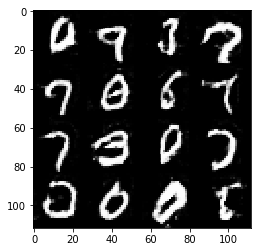

Epoch 5/10... Discriminator Loss: 0.4408... Generator Loss: 1.7130
Epoch 5/10... Discriminator Loss: 0.2117... Generator Loss: 2.8116
Epoch 5/10... Discriminator Loss: 0.4406... Generator Loss: 1.5091
Epoch 5/10... Discriminator Loss: 0.5214... Generator Loss: 1.2247
Epoch 5/10... Discriminator Loss: 0.3290... Generator Loss: 2.4500
Epoch 5/10... Discriminator Loss: 0.7291... Generator Loss: 3.3035
Epoch 5/10... Discriminator Loss: 0.3229... Generator Loss: 2.0098
Epoch 5/10... Discriminator Loss: 0.4513... Generator Loss: 1.5688
Epoch 5/10... Discriminator Loss: 0.2469... Generator Loss: 2.2675
Epoch 5/10... Discriminator Loss: 0.3243... Generator Loss: 2.1594


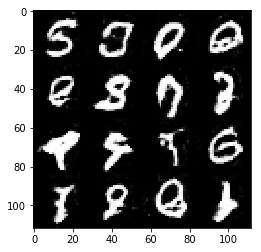

Epoch 5/10... Discriminator Loss: 0.4578... Generator Loss: 1.5731
Epoch 5/10... Discriminator Loss: 0.7690... Generator Loss: 0.9084
Epoch 5/10... Discriminator Loss: 0.3174... Generator Loss: 2.1138
Epoch 5/10... Discriminator Loss: 0.3922... Generator Loss: 1.7934
Epoch 5/10... Discriminator Loss: 0.2820... Generator Loss: 2.1458
Epoch 5/10... Discriminator Loss: 0.3609... Generator Loss: 1.8381
Epoch 5/10... Discriminator Loss: 0.6412... Generator Loss: 1.2450
Epoch 5/10... Discriminator Loss: 0.1533... Generator Loss: 3.5153
Epoch 5/10... Discriminator Loss: 0.4441... Generator Loss: 2.9499
Epoch 5/10... Discriminator Loss: 0.2888... Generator Loss: 3.3398


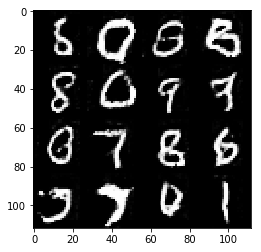

Epoch 5/10... Discriminator Loss: 0.3010... Generator Loss: 2.3958
Epoch 5/10... Discriminator Loss: 0.4459... Generator Loss: 1.7373
Epoch 5/10... Discriminator Loss: 0.7142... Generator Loss: 1.2775
Epoch 5/10... Discriminator Loss: 11.1949... Generator Loss: 13.1516
Epoch 5/10... Discriminator Loss: 1.1617... Generator Loss: 1.5391
Epoch 5/10... Discriminator Loss: 0.3706... Generator Loss: 2.7650
Epoch 5/10... Discriminator Loss: 0.9272... Generator Loss: 1.5990
Epoch 5/10... Discriminator Loss: 0.5801... Generator Loss: 2.1934
Epoch 5/10... Discriminator Loss: 0.4742... Generator Loss: 2.5421
Epoch 5/10... Discriminator Loss: 0.3278... Generator Loss: 2.4399


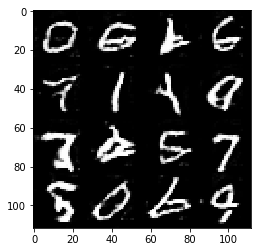

Epoch 5/10... Discriminator Loss: 0.9664... Generator Loss: 0.7445
Epoch 5/10... Discriminator Loss: 0.3774... Generator Loss: 2.1301
Epoch 5/10... Discriminator Loss: 0.5029... Generator Loss: 1.3258
Epoch 5/10... Discriminator Loss: 0.4010... Generator Loss: 2.2192
Epoch 5/10... Discriminator Loss: 0.3867... Generator Loss: 2.0941
Epoch 5/10... Discriminator Loss: 0.6599... Generator Loss: 2.6756
Epoch 5/10... Discriminator Loss: 0.3518... Generator Loss: 2.1853
Epoch 6/10... Discriminator Loss: 0.3620... Generator Loss: 1.6957
Epoch 6/10... Discriminator Loss: 0.4634... Generator Loss: 2.0138
Epoch 6/10... Discriminator Loss: 0.2661... Generator Loss: 2.1138


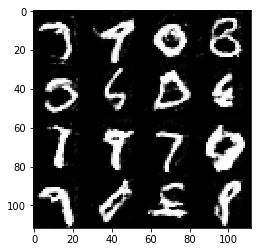

Epoch 6/10... Discriminator Loss: 0.5139... Generator Loss: 1.6543
Epoch 6/10... Discriminator Loss: 0.3852... Generator Loss: 2.3126
Epoch 6/10... Discriminator Loss: 0.5356... Generator Loss: 1.2898
Epoch 6/10... Discriminator Loss: 0.3460... Generator Loss: 2.0140
Epoch 6/10... Discriminator Loss: 0.4386... Generator Loss: 2.7492
Epoch 6/10... Discriminator Loss: 0.4055... Generator Loss: 1.7299
Epoch 6/10... Discriminator Loss: 0.4064... Generator Loss: 1.5077
Epoch 6/10... Discriminator Loss: 0.4819... Generator Loss: 1.6057
Epoch 6/10... Discriminator Loss: 0.4581... Generator Loss: 1.5490
Epoch 6/10... Discriminator Loss: 0.8132... Generator Loss: 0.8572


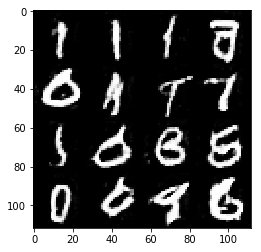

Epoch 6/10... Discriminator Loss: 0.3419... Generator Loss: 1.7111
Epoch 6/10... Discriminator Loss: 0.2986... Generator Loss: 2.9582
Epoch 6/10... Discriminator Loss: 0.5417... Generator Loss: 1.3770
Epoch 6/10... Discriminator Loss: 0.3128... Generator Loss: 1.8843
Epoch 6/10... Discriminator Loss: 0.4946... Generator Loss: 1.4077
Epoch 6/10... Discriminator Loss: 0.3529... Generator Loss: 1.8597
Epoch 6/10... Discriminator Loss: 0.4565... Generator Loss: 2.6809
Epoch 6/10... Discriminator Loss: 0.5695... Generator Loss: 1.1949
Epoch 6/10... Discriminator Loss: 0.4845... Generator Loss: 1.4031
Epoch 6/10... Discriminator Loss: 0.3611... Generator Loss: 2.1885


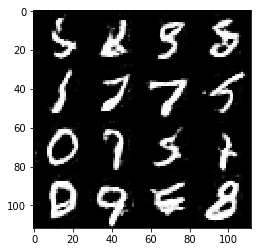

Epoch 6/10... Discriminator Loss: 0.6175... Generator Loss: 1.0353
Epoch 6/10... Discriminator Loss: 0.2975... Generator Loss: 2.2349
Epoch 6/10... Discriminator Loss: 0.4277... Generator Loss: 1.7680
Epoch 6/10... Discriminator Loss: 0.4023... Generator Loss: 1.6670
Epoch 6/10... Discriminator Loss: 0.3934... Generator Loss: 1.4877
Epoch 6/10... Discriminator Loss: 0.4686... Generator Loss: 1.4851
Epoch 6/10... Discriminator Loss: 0.3650... Generator Loss: 2.2146
Epoch 6/10... Discriminator Loss: 0.4284... Generator Loss: 1.9424
Epoch 6/10... Discriminator Loss: 0.2760... Generator Loss: 2.1195
Epoch 6/10... Discriminator Loss: 0.4745... Generator Loss: 1.7242


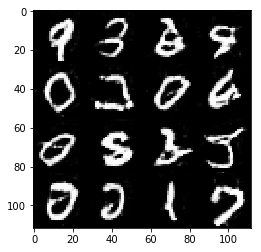

Epoch 6/10... Discriminator Loss: 0.4073... Generator Loss: 2.3542
Epoch 6/10... Discriminator Loss: 0.2471... Generator Loss: 2.2029
Epoch 6/10... Discriminator Loss: 0.4352... Generator Loss: 1.3042
Epoch 6/10... Discriminator Loss: 0.3126... Generator Loss: 2.3579
Epoch 6/10... Discriminator Loss: 0.5852... Generator Loss: 1.2945
Epoch 6/10... Discriminator Loss: 0.2731... Generator Loss: 2.0931
Epoch 6/10... Discriminator Loss: 0.5105... Generator Loss: 2.3251
Epoch 6/10... Discriminator Loss: 0.3725... Generator Loss: 1.5126
Epoch 6/10... Discriminator Loss: 0.3499... Generator Loss: 2.0550
Epoch 6/10... Discriminator Loss: 0.2996... Generator Loss: 2.2159


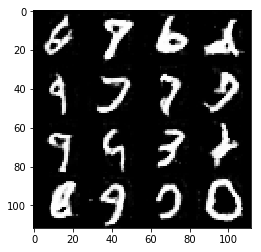

Epoch 6/10... Discriminator Loss: 0.4219... Generator Loss: 1.5636
Epoch 6/10... Discriminator Loss: 0.3040... Generator Loss: 2.1259
Epoch 6/10... Discriminator Loss: 0.5116... Generator Loss: 1.6288
Epoch 6/10... Discriminator Loss: 0.6446... Generator Loss: 1.0324
Epoch 6/10... Discriminator Loss: 0.1408... Generator Loss: 3.1432
Epoch 6/10... Discriminator Loss: 0.3928... Generator Loss: 1.6582
Epoch 6/10... Discriminator Loss: 0.4169... Generator Loss: 1.4848
Epoch 6/10... Discriminator Loss: 0.4229... Generator Loss: 1.5132
Epoch 6/10... Discriminator Loss: 0.4142... Generator Loss: 1.8134
Epoch 6/10... Discriminator Loss: 0.3750... Generator Loss: 1.6621


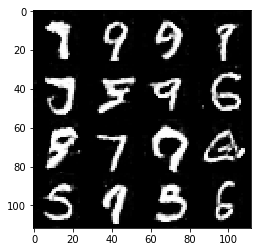

Epoch 6/10... Discriminator Loss: 0.6004... Generator Loss: 1.3637
Epoch 6/10... Discriminator Loss: 0.3535... Generator Loss: 2.0099
Epoch 6/10... Discriminator Loss: 0.2413... Generator Loss: 2.1492
Epoch 6/10... Discriminator Loss: 0.4070... Generator Loss: 2.4544
Epoch 6/10... Discriminator Loss: 0.3307... Generator Loss: 2.1198
Epoch 6/10... Discriminator Loss: 0.4941... Generator Loss: 1.3199
Epoch 6/10... Discriminator Loss: 0.5369... Generator Loss: 1.3517
Epoch 6/10... Discriminator Loss: 0.3275... Generator Loss: 1.9985
Epoch 6/10... Discriminator Loss: 0.3075... Generator Loss: 1.8891
Epoch 6/10... Discriminator Loss: 0.4964... Generator Loss: 1.5182


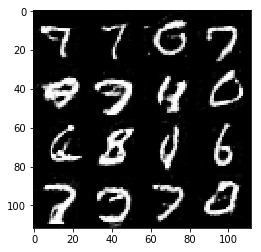

Epoch 6/10... Discriminator Loss: 0.8656... Generator Loss: 0.8102
Epoch 6/10... Discriminator Loss: 0.6000... Generator Loss: 2.2300
Epoch 6/10... Discriminator Loss: 0.4175... Generator Loss: 1.9728
Epoch 6/10... Discriminator Loss: 0.4193... Generator Loss: 1.6392
Epoch 6/10... Discriminator Loss: 0.5165... Generator Loss: 2.1075
Epoch 6/10... Discriminator Loss: 0.3339... Generator Loss: 2.4917
Epoch 6/10... Discriminator Loss: 0.2094... Generator Loss: 2.3009
Epoch 6/10... Discriminator Loss: 0.3387... Generator Loss: 1.9559
Epoch 6/10... Discriminator Loss: 0.4244... Generator Loss: 1.8607
Epoch 6/10... Discriminator Loss: 0.2889... Generator Loss: 2.5595


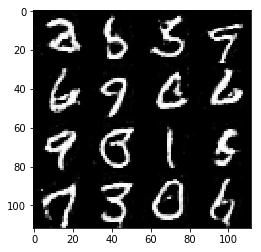

Epoch 6/10... Discriminator Loss: 0.4399... Generator Loss: 1.4292
Epoch 6/10... Discriminator Loss: 0.2843... Generator Loss: 2.2279
Epoch 6/10... Discriminator Loss: 0.3094... Generator Loss: 2.0351
Epoch 6/10... Discriminator Loss: 0.6356... Generator Loss: 1.3416
Epoch 6/10... Discriminator Loss: 0.3773... Generator Loss: 1.8997
Epoch 6/10... Discriminator Loss: 0.4181... Generator Loss: 1.8818
Epoch 6/10... Discriminator Loss: 0.4240... Generator Loss: 1.5846
Epoch 6/10... Discriminator Loss: 0.3574... Generator Loss: 2.1540
Epoch 6/10... Discriminator Loss: 0.2221... Generator Loss: 2.4124
Epoch 6/10... Discriminator Loss: 0.5229... Generator Loss: 1.3699


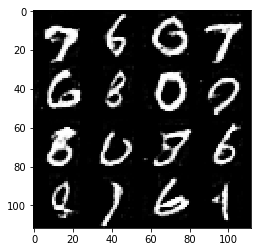

Epoch 6/10... Discriminator Loss: 0.2927... Generator Loss: 1.8274
Epoch 6/10... Discriminator Loss: 0.4005... Generator Loss: 1.6481
Epoch 6/10... Discriminator Loss: 0.3800... Generator Loss: 1.7308
Epoch 6/10... Discriminator Loss: 0.3483... Generator Loss: 1.8313
Epoch 6/10... Discriminator Loss: 0.3783... Generator Loss: 2.8788
Epoch 6/10... Discriminator Loss: 0.3205... Generator Loss: 2.0705
Epoch 6/10... Discriminator Loss: 0.4198... Generator Loss: 1.7490
Epoch 6/10... Discriminator Loss: 0.2877... Generator Loss: 1.8587
Epoch 6/10... Discriminator Loss: 0.5823... Generator Loss: 1.1717
Epoch 6/10... Discriminator Loss: 0.3514... Generator Loss: 1.7437


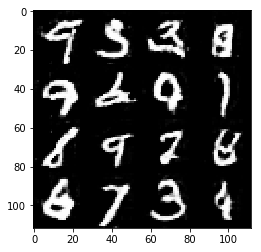

Epoch 6/10... Discriminator Loss: 0.3909... Generator Loss: 1.9021
Epoch 6/10... Discriminator Loss: 0.4683... Generator Loss: 1.6399
Epoch 6/10... Discriminator Loss: 0.3425... Generator Loss: 1.9056
Epoch 6/10... Discriminator Loss: 0.5381... Generator Loss: 2.1105
Epoch 6/10... Discriminator Loss: 0.4002... Generator Loss: 1.6332
Epoch 6/10... Discriminator Loss: 0.3322... Generator Loss: 1.8593
Epoch 6/10... Discriminator Loss: 0.2278... Generator Loss: 2.1842
Epoch 6/10... Discriminator Loss: 0.3137... Generator Loss: 2.2356
Epoch 6/10... Discriminator Loss: 0.4262... Generator Loss: 1.4288
Epoch 6/10... Discriminator Loss: 0.3953... Generator Loss: 1.5155


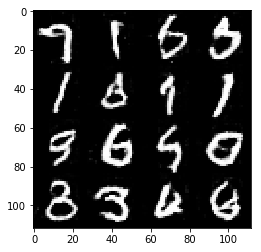

Epoch 6/10... Discriminator Loss: 0.2648... Generator Loss: 2.1406
Epoch 6/10... Discriminator Loss: 0.5984... Generator Loss: 1.1369
Epoch 6/10... Discriminator Loss: 0.1910... Generator Loss: 2.8843
Epoch 6/10... Discriminator Loss: 0.3977... Generator Loss: 1.6191
Epoch 6/10... Discriminator Loss: 0.3184... Generator Loss: 1.7549
Epoch 6/10... Discriminator Loss: 0.3488... Generator Loss: 2.0206
Epoch 6/10... Discriminator Loss: 0.3509... Generator Loss: 2.1060
Epoch 6/10... Discriminator Loss: 0.4713... Generator Loss: 1.4860
Epoch 6/10... Discriminator Loss: 0.3319... Generator Loss: 1.9344
Epoch 6/10... Discriminator Loss: 0.3513... Generator Loss: 1.9951


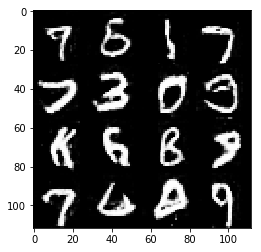

Epoch 6/10... Discriminator Loss: 0.5994... Generator Loss: 1.4451
Epoch 6/10... Discriminator Loss: 0.3439... Generator Loss: 1.9274
Epoch 6/10... Discriminator Loss: 0.3190... Generator Loss: 1.8135
Epoch 6/10... Discriminator Loss: 0.4379... Generator Loss: 1.5064
Epoch 6/10... Discriminator Loss: 0.2926... Generator Loss: 2.2260
Epoch 6/10... Discriminator Loss: 0.2723... Generator Loss: 2.1540
Epoch 6/10... Discriminator Loss: 0.2851... Generator Loss: 2.1709
Epoch 6/10... Discriminator Loss: 0.2648... Generator Loss: 2.0480
Epoch 6/10... Discriminator Loss: 0.4274... Generator Loss: 1.8257
Epoch 6/10... Discriminator Loss: 0.3109... Generator Loss: 2.0584


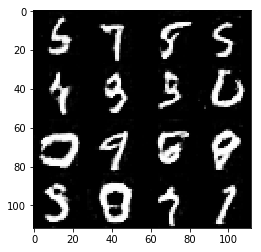

Epoch 6/10... Discriminator Loss: 0.3357... Generator Loss: 1.8353
Epoch 6/10... Discriminator Loss: 0.2715... Generator Loss: 2.0566
Epoch 6/10... Discriminator Loss: 0.4844... Generator Loss: 1.5046
Epoch 6/10... Discriminator Loss: 0.2498... Generator Loss: 2.7095
Epoch 6/10... Discriminator Loss: 0.2909... Generator Loss: 2.6079
Epoch 6/10... Discriminator Loss: 0.3305... Generator Loss: 1.9396
Epoch 6/10... Discriminator Loss: 0.3400... Generator Loss: 1.9841
Epoch 6/10... Discriminator Loss: 0.4994... Generator Loss: 2.3641
Epoch 6/10... Discriminator Loss: 0.6630... Generator Loss: 1.1943
Epoch 6/10... Discriminator Loss: 0.3926... Generator Loss: 1.9623


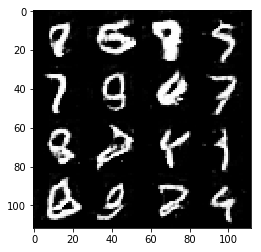

Epoch 6/10... Discriminator Loss: 0.2818... Generator Loss: 1.9254
Epoch 6/10... Discriminator Loss: 0.5492... Generator Loss: 1.4854
Epoch 6/10... Discriminator Loss: 0.5187... Generator Loss: 1.5198
Epoch 6/10... Discriminator Loss: 0.3530... Generator Loss: 2.4713
Epoch 6/10... Discriminator Loss: 0.3918... Generator Loss: 2.3507
Epoch 6/10... Discriminator Loss: 0.2479... Generator Loss: 2.5024
Epoch 6/10... Discriminator Loss: 0.2863... Generator Loss: 2.3484
Epoch 6/10... Discriminator Loss: 0.3211... Generator Loss: 2.4300
Epoch 6/10... Discriminator Loss: 0.7499... Generator Loss: 0.9521
Epoch 6/10... Discriminator Loss: 0.4462... Generator Loss: 1.8303


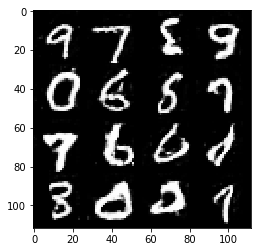

Epoch 6/10... Discriminator Loss: 1.2144... Generator Loss: 1.9522
Epoch 6/10... Discriminator Loss: 0.6333... Generator Loss: 2.3237
Epoch 6/10... Discriminator Loss: 0.8226... Generator Loss: 1.4432
Epoch 6/10... Discriminator Loss: 0.5376... Generator Loss: 2.4608
Epoch 6/10... Discriminator Loss: 0.4020... Generator Loss: 2.6279
Epoch 6/10... Discriminator Loss: 0.5919... Generator Loss: 1.7076
Epoch 6/10... Discriminator Loss: 0.6153... Generator Loss: 1.0820
Epoch 6/10... Discriminator Loss: 0.4458... Generator Loss: 1.8268
Epoch 6/10... Discriminator Loss: 0.5470... Generator Loss: 3.4662
Epoch 6/10... Discriminator Loss: 0.4847... Generator Loss: 1.5853


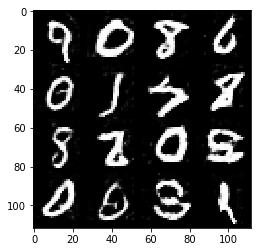

Epoch 6/10... Discriminator Loss: 0.4021... Generator Loss: 1.8101
Epoch 6/10... Discriminator Loss: 0.7268... Generator Loss: 2.7859
Epoch 6/10... Discriminator Loss: 0.5639... Generator Loss: 1.4317
Epoch 6/10... Discriminator Loss: 0.5920... Generator Loss: 1.3334
Epoch 6/10... Discriminator Loss: 0.5645... Generator Loss: 1.1243
Epoch 6/10... Discriminator Loss: 0.5191... Generator Loss: 2.4204
Epoch 6/10... Discriminator Loss: 0.8419... Generator Loss: 3.4757
Epoch 6/10... Discriminator Loss: 0.7533... Generator Loss: 3.2252
Epoch 6/10... Discriminator Loss: 0.5210... Generator Loss: 1.7629
Epoch 6/10... Discriminator Loss: 0.4004... Generator Loss: 1.7800


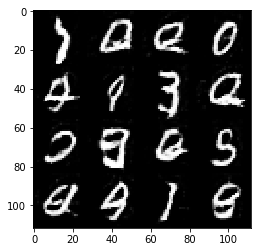

Epoch 6/10... Discriminator Loss: 0.3259... Generator Loss: 2.0604
Epoch 6/10... Discriminator Loss: 0.4222... Generator Loss: 1.6483
Epoch 6/10... Discriminator Loss: 0.5647... Generator Loss: 1.3200
Epoch 6/10... Discriminator Loss: 0.3005... Generator Loss: 1.9668
Epoch 6/10... Discriminator Loss: 0.2568... Generator Loss: 2.2529
Epoch 6/10... Discriminator Loss: 0.4965... Generator Loss: 1.5801
Epoch 6/10... Discriminator Loss: 0.2510... Generator Loss: 2.2424
Epoch 6/10... Discriminator Loss: 0.6031... Generator Loss: 1.1280
Epoch 6/10... Discriminator Loss: 0.3723... Generator Loss: 1.9577
Epoch 6/10... Discriminator Loss: 0.4326... Generator Loss: 2.2924


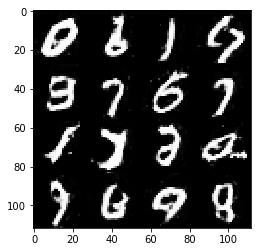

Epoch 6/10... Discriminator Loss: 0.1589... Generator Loss: 2.8264
Epoch 6/10... Discriminator Loss: 0.4027... Generator Loss: 2.0227
Epoch 6/10... Discriminator Loss: 0.3258... Generator Loss: 1.9271
Epoch 6/10... Discriminator Loss: 0.4358... Generator Loss: 1.6866
Epoch 6/10... Discriminator Loss: 0.3115... Generator Loss: 2.2470
Epoch 6/10... Discriminator Loss: 0.3533... Generator Loss: 1.7546
Epoch 6/10... Discriminator Loss: 0.4987... Generator Loss: 1.4082
Epoch 6/10... Discriminator Loss: 0.5497... Generator Loss: 1.3462
Epoch 6/10... Discriminator Loss: 0.4343... Generator Loss: 1.4409
Epoch 6/10... Discriminator Loss: 0.4794... Generator Loss: 2.0220


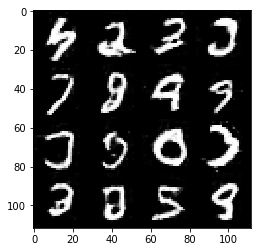

Epoch 6/10... Discriminator Loss: 0.3183... Generator Loss: 3.2762
Epoch 6/10... Discriminator Loss: 0.3859... Generator Loss: 1.7465
Epoch 6/10... Discriminator Loss: 0.3771... Generator Loss: 2.1821
Epoch 6/10... Discriminator Loss: 0.4803... Generator Loss: 1.4337
Epoch 6/10... Discriminator Loss: 0.3448... Generator Loss: 1.7715
Epoch 7/10... Discriminator Loss: 0.3531... Generator Loss: 3.1326
Epoch 7/10... Discriminator Loss: 0.4278... Generator Loss: 1.6027
Epoch 7/10... Discriminator Loss: 0.4524... Generator Loss: 1.6806
Epoch 7/10... Discriminator Loss: 0.3926... Generator Loss: 2.6480
Epoch 7/10... Discriminator Loss: 0.3999... Generator Loss: 2.4313


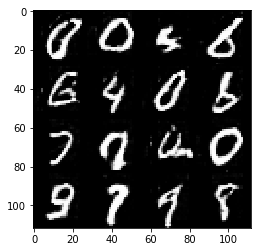

Epoch 7/10... Discriminator Loss: 0.6414... Generator Loss: 1.1543
Epoch 7/10... Discriminator Loss: 0.5399... Generator Loss: 1.2666
Epoch 7/10... Discriminator Loss: 0.4159... Generator Loss: 1.5479
Epoch 7/10... Discriminator Loss: 0.2206... Generator Loss: 2.6923
Epoch 7/10... Discriminator Loss: 0.3403... Generator Loss: 1.8591
Epoch 7/10... Discriminator Loss: 4.7926... Generator Loss: 8.7080
Epoch 7/10... Discriminator Loss: 1.2268... Generator Loss: 3.3551
Epoch 7/10... Discriminator Loss: 0.7144... Generator Loss: 1.3575
Epoch 7/10... Discriminator Loss: 1.1337... Generator Loss: 0.7493
Epoch 7/10... Discriminator Loss: 0.5045... Generator Loss: 1.9955


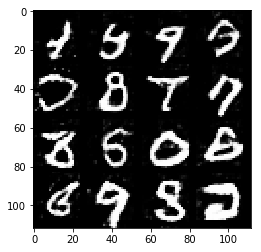

Epoch 7/10... Discriminator Loss: 0.3133... Generator Loss: 2.9194
Epoch 7/10... Discriminator Loss: 0.9124... Generator Loss: 0.8256
Epoch 7/10... Discriminator Loss: 0.3942... Generator Loss: 1.8538
Epoch 7/10... Discriminator Loss: 0.4626... Generator Loss: 1.4549
Epoch 7/10... Discriminator Loss: 0.6074... Generator Loss: 1.4294
Epoch 7/10... Discriminator Loss: 0.7398... Generator Loss: 1.1243
Epoch 7/10... Discriminator Loss: 0.3509... Generator Loss: 1.8915
Epoch 7/10... Discriminator Loss: 0.2208... Generator Loss: 2.7249
Epoch 7/10... Discriminator Loss: 0.3602... Generator Loss: 2.2855
Epoch 7/10... Discriminator Loss: 0.5463... Generator Loss: 1.3271


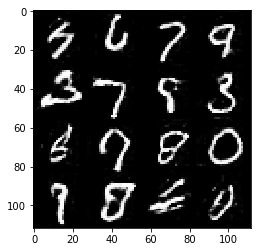

Epoch 7/10... Discriminator Loss: 0.3043... Generator Loss: 2.4194
Epoch 7/10... Discriminator Loss: 0.5246... Generator Loss: 1.9132
Epoch 7/10... Discriminator Loss: 0.4150... Generator Loss: 2.5196
Epoch 7/10... Discriminator Loss: 0.7359... Generator Loss: 0.9768
Epoch 7/10... Discriminator Loss: 1.0302... Generator Loss: 0.6039
Epoch 7/10... Discriminator Loss: 0.2875... Generator Loss: 2.0116
Epoch 7/10... Discriminator Loss: 0.5975... Generator Loss: 1.1101
Epoch 7/10... Discriminator Loss: 0.3955... Generator Loss: 2.0844
Epoch 7/10... Discriminator Loss: 0.4305... Generator Loss: 1.5499
Epoch 7/10... Discriminator Loss: 0.3215... Generator Loss: 2.0723


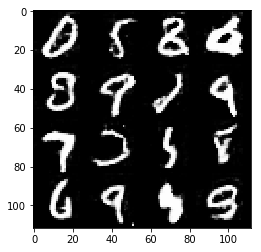

Epoch 7/10... Discriminator Loss: 0.4896... Generator Loss: 1.5799
Epoch 7/10... Discriminator Loss: 0.5445... Generator Loss: 1.2385
Epoch 7/10... Discriminator Loss: 0.5059... Generator Loss: 1.4492
Epoch 7/10... Discriminator Loss: 0.3303... Generator Loss: 1.9667
Epoch 7/10... Discriminator Loss: 0.3763... Generator Loss: 1.6339
Epoch 7/10... Discriminator Loss: 0.7042... Generator Loss: 1.1686
Epoch 7/10... Discriminator Loss: 0.2268... Generator Loss: 2.4608
Epoch 7/10... Discriminator Loss: 0.4607... Generator Loss: 1.4319
Epoch 7/10... Discriminator Loss: 0.7386... Generator Loss: 1.0258
Epoch 7/10... Discriminator Loss: 0.4243... Generator Loss: 1.5278


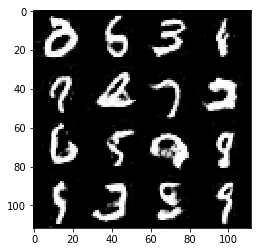

Epoch 7/10... Discriminator Loss: 0.4636... Generator Loss: 1.4044
Epoch 7/10... Discriminator Loss: 0.4947... Generator Loss: 1.5447
Epoch 7/10... Discriminator Loss: 0.9235... Generator Loss: 0.8704
Epoch 7/10... Discriminator Loss: 0.5823... Generator Loss: 2.4106
Epoch 7/10... Discriminator Loss: 0.3897... Generator Loss: 1.9799
Epoch 7/10... Discriminator Loss: 0.5069... Generator Loss: 1.2686
Epoch 7/10... Discriminator Loss: 0.4135... Generator Loss: 1.5709
Epoch 7/10... Discriminator Loss: 0.4233... Generator Loss: 1.6026
Epoch 7/10... Discriminator Loss: 0.5836... Generator Loss: 1.6247
Epoch 7/10... Discriminator Loss: 0.3417... Generator Loss: 1.6389


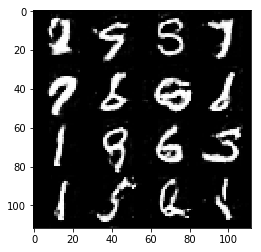

Epoch 7/10... Discriminator Loss: 0.5993... Generator Loss: 1.1953
Epoch 7/10... Discriminator Loss: 0.3657... Generator Loss: 2.4211
Epoch 7/10... Discriminator Loss: 0.4142... Generator Loss: 1.6437
Epoch 7/10... Discriminator Loss: 0.3700... Generator Loss: 2.1142
Epoch 7/10... Discriminator Loss: 0.5450... Generator Loss: 1.4625
Epoch 7/10... Discriminator Loss: 0.4077... Generator Loss: 1.7525
Epoch 7/10... Discriminator Loss: 0.7091... Generator Loss: 0.8604
Epoch 7/10... Discriminator Loss: 0.3915... Generator Loss: 1.6637
Epoch 7/10... Discriminator Loss: 0.3984... Generator Loss: 1.9798
Epoch 7/10... Discriminator Loss: 0.3409... Generator Loss: 1.7711


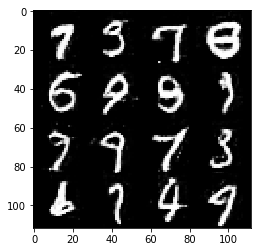

Epoch 7/10... Discriminator Loss: 0.5410... Generator Loss: 1.4495
Epoch 7/10... Discriminator Loss: 0.9328... Generator Loss: 0.9645
Epoch 7/10... Discriminator Loss: 0.4323... Generator Loss: 1.5317
Epoch 7/10... Discriminator Loss: 0.2695... Generator Loss: 2.2066
Epoch 7/10... Discriminator Loss: 0.3509... Generator Loss: 2.2502
Epoch 7/10... Discriminator Loss: 0.4272... Generator Loss: 1.8549
Epoch 7/10... Discriminator Loss: 0.4391... Generator Loss: 1.6452
Epoch 7/10... Discriminator Loss: 0.4449... Generator Loss: 1.5772
Epoch 7/10... Discriminator Loss: 0.4270... Generator Loss: 2.7724
Epoch 7/10... Discriminator Loss: 0.4405... Generator Loss: 1.4968


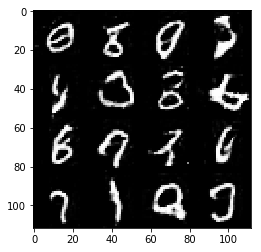

Epoch 7/10... Discriminator Loss: 0.2919... Generator Loss: 1.8967
Epoch 7/10... Discriminator Loss: 0.3160... Generator Loss: 2.1623
Epoch 7/10... Discriminator Loss: 0.3458... Generator Loss: 2.0314
Epoch 7/10... Discriminator Loss: 0.4071... Generator Loss: 1.9043
Epoch 7/10... Discriminator Loss: 1.3034... Generator Loss: 0.4508
Epoch 7/10... Discriminator Loss: 0.2644... Generator Loss: 2.0121
Epoch 7/10... Discriminator Loss: 0.3424... Generator Loss: 1.9264
Epoch 7/10... Discriminator Loss: 0.4370... Generator Loss: 2.4712
Epoch 7/10... Discriminator Loss: 0.3138... Generator Loss: 2.6176
Epoch 7/10... Discriminator Loss: 0.3174... Generator Loss: 2.0103


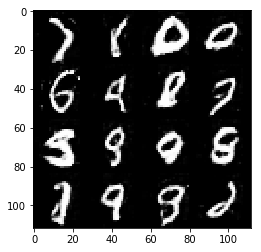

Epoch 7/10... Discriminator Loss: 0.4673... Generator Loss: 2.5053
Epoch 7/10... Discriminator Loss: 0.5202... Generator Loss: 1.2135
Epoch 7/10... Discriminator Loss: 0.7734... Generator Loss: 0.9099
Epoch 7/10... Discriminator Loss: 0.3688... Generator Loss: 1.8790
Epoch 7/10... Discriminator Loss: 0.2484... Generator Loss: 2.6005
Epoch 7/10... Discriminator Loss: 0.4711... Generator Loss: 1.7495
Epoch 7/10... Discriminator Loss: 0.3130... Generator Loss: 2.4613
Epoch 7/10... Discriminator Loss: 0.5326... Generator Loss: 1.6744
Epoch 7/10... Discriminator Loss: 0.7444... Generator Loss: 3.3640
Epoch 7/10... Discriminator Loss: 2.6083... Generator Loss: 0.1956


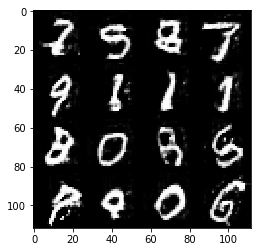

Epoch 7/10... Discriminator Loss: 0.9353... Generator Loss: 3.1437
Epoch 7/10... Discriminator Loss: 0.8108... Generator Loss: 1.3150
Epoch 7/10... Discriminator Loss: 0.7582... Generator Loss: 1.6502
Epoch 7/10... Discriminator Loss: 0.8246... Generator Loss: 0.8695
Epoch 7/10... Discriminator Loss: 0.5632... Generator Loss: 1.4884
Epoch 7/10... Discriminator Loss: 0.6088... Generator Loss: 2.4026
Epoch 7/10... Discriminator Loss: 0.4455... Generator Loss: 1.8368
Epoch 7/10... Discriminator Loss: 0.5428... Generator Loss: 1.5869
Epoch 7/10... Discriminator Loss: 0.5341... Generator Loss: 1.6978
Epoch 7/10... Discriminator Loss: 0.4542... Generator Loss: 1.6889


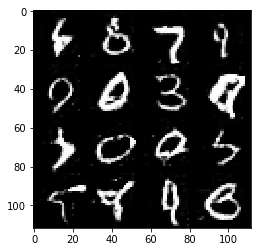

Epoch 7/10... Discriminator Loss: 0.5039... Generator Loss: 1.5760
Epoch 7/10... Discriminator Loss: 0.4315... Generator Loss: 2.3123
Epoch 7/10... Discriminator Loss: 0.3890... Generator Loss: 2.0886
Epoch 7/10... Discriminator Loss: 0.5938... Generator Loss: 1.3905
Epoch 7/10... Discriminator Loss: 0.4912... Generator Loss: 1.5555
Epoch 7/10... Discriminator Loss: 0.4976... Generator Loss: 2.2623
Epoch 7/10... Discriminator Loss: 0.5228... Generator Loss: 1.5747
Epoch 7/10... Discriminator Loss: 0.3331... Generator Loss: 1.7979
Epoch 7/10... Discriminator Loss: 0.5136... Generator Loss: 1.6419
Epoch 7/10... Discriminator Loss: 0.4984... Generator Loss: 1.5045


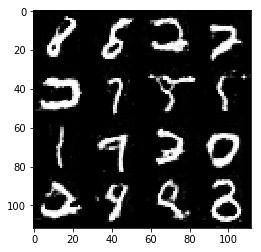

Epoch 7/10... Discriminator Loss: 0.4502... Generator Loss: 1.6887
Epoch 7/10... Discriminator Loss: 0.4415... Generator Loss: 1.7022
Epoch 7/10... Discriminator Loss: 0.3943... Generator Loss: 2.0605
Epoch 7/10... Discriminator Loss: 0.3214... Generator Loss: 2.0352
Epoch 7/10... Discriminator Loss: 0.5650... Generator Loss: 1.3161
Epoch 7/10... Discriminator Loss: 0.4652... Generator Loss: 1.8910
Epoch 7/10... Discriminator Loss: 0.4980... Generator Loss: 1.4284
Epoch 7/10... Discriminator Loss: 0.4463... Generator Loss: 1.9946
Epoch 7/10... Discriminator Loss: 0.4090... Generator Loss: 1.7019
Epoch 7/10... Discriminator Loss: 0.4655... Generator Loss: 2.4590


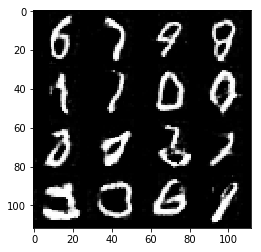

Epoch 7/10... Discriminator Loss: 0.3964... Generator Loss: 1.7977
Epoch 7/10... Discriminator Loss: 0.5645... Generator Loss: 1.1501
Epoch 7/10... Discriminator Loss: 0.2831... Generator Loss: 2.0551
Epoch 7/10... Discriminator Loss: 0.5748... Generator Loss: 1.1435
Epoch 7/10... Discriminator Loss: 0.6203... Generator Loss: 1.2549
Epoch 7/10... Discriminator Loss: 0.3575... Generator Loss: 1.7007
Epoch 7/10... Discriminator Loss: 0.5306... Generator Loss: 1.4759
Epoch 7/10... Discriminator Loss: 0.5169... Generator Loss: 1.3810
Epoch 7/10... Discriminator Loss: 0.3229... Generator Loss: 1.9849
Epoch 7/10... Discriminator Loss: 0.3826... Generator Loss: 2.0575


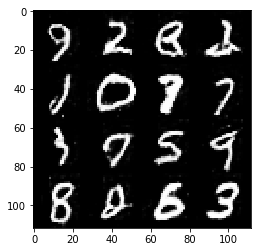

Epoch 7/10... Discriminator Loss: 1.0401... Generator Loss: 0.8175
Epoch 7/10... Discriminator Loss: 0.5062... Generator Loss: 1.5783
Epoch 7/10... Discriminator Loss: 0.3535... Generator Loss: 1.7795
Epoch 7/10... Discriminator Loss: 0.4407... Generator Loss: 1.6359
Epoch 7/10... Discriminator Loss: 0.5103... Generator Loss: 1.3695
Epoch 7/10... Discriminator Loss: 0.2914... Generator Loss: 1.9536
Epoch 7/10... Discriminator Loss: 0.5929... Generator Loss: 1.3741
Epoch 7/10... Discriminator Loss: 0.3549... Generator Loss: 1.9172
Epoch 7/10... Discriminator Loss: 0.5675... Generator Loss: 1.2865
Epoch 7/10... Discriminator Loss: 0.3988... Generator Loss: 1.6648


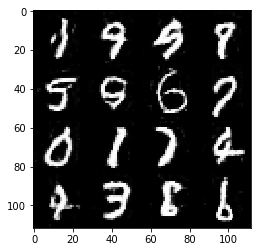

Epoch 7/10... Discriminator Loss: 0.3239... Generator Loss: 1.8730
Epoch 7/10... Discriminator Loss: 0.5972... Generator Loss: 1.4682
Epoch 7/10... Discriminator Loss: 0.5768... Generator Loss: 1.1924
Epoch 7/10... Discriminator Loss: 1.0186... Generator Loss: 0.6229
Epoch 7/10... Discriminator Loss: 0.3987... Generator Loss: 1.5923
Epoch 7/10... Discriminator Loss: 0.8852... Generator Loss: 0.8179
Epoch 7/10... Discriminator Loss: 0.3031... Generator Loss: 1.8880
Epoch 7/10... Discriminator Loss: 0.4239... Generator Loss: 1.8525
Epoch 7/10... Discriminator Loss: 0.4087... Generator Loss: 1.7753
Epoch 7/10... Discriminator Loss: 0.3546... Generator Loss: 1.6872


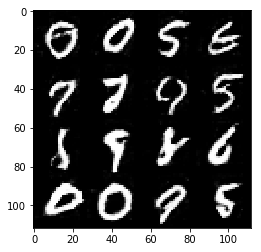

Epoch 7/10... Discriminator Loss: 0.4873... Generator Loss: 1.7314
Epoch 7/10... Discriminator Loss: 0.3933... Generator Loss: 1.8089
Epoch 7/10... Discriminator Loss: 1.0712... Generator Loss: 2.8842
Epoch 7/10... Discriminator Loss: 0.7587... Generator Loss: 2.0504
Epoch 7/10... Discriminator Loss: 0.5113... Generator Loss: 2.1166
Epoch 7/10... Discriminator Loss: 0.5361... Generator Loss: 1.6484
Epoch 7/10... Discriminator Loss: 0.4849... Generator Loss: 1.7068
Epoch 7/10... Discriminator Loss: 0.3056... Generator Loss: 2.1176
Epoch 7/10... Discriminator Loss: 0.3302... Generator Loss: 1.8646
Epoch 7/10... Discriminator Loss: 0.4566... Generator Loss: 1.7342


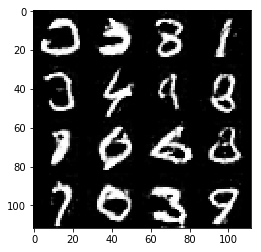

Epoch 7/10... Discriminator Loss: 0.3258... Generator Loss: 1.8625
Epoch 7/10... Discriminator Loss: 0.9555... Generator Loss: 0.6819
Epoch 7/10... Discriminator Loss: 0.2362... Generator Loss: 2.7137
Epoch 7/10... Discriminator Loss: 0.3961... Generator Loss: 2.0203
Epoch 7/10... Discriminator Loss: 0.3676... Generator Loss: 1.8645
Epoch 7/10... Discriminator Loss: 0.4371... Generator Loss: 1.5591
Epoch 7/10... Discriminator Loss: 0.5678... Generator Loss: 1.3872
Epoch 7/10... Discriminator Loss: 0.6787... Generator Loss: 1.4439
Epoch 7/10... Discriminator Loss: 0.6467... Generator Loss: 1.1853
Epoch 7/10... Discriminator Loss: 0.4303... Generator Loss: 1.7166


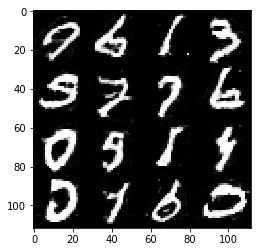

Epoch 7/10... Discriminator Loss: 0.5337... Generator Loss: 1.4328
Epoch 7/10... Discriminator Loss: 1.2819... Generator Loss: 0.4967
Epoch 7/10... Discriminator Loss: 0.4919... Generator Loss: 1.5449
Epoch 7/10... Discriminator Loss: 0.4360... Generator Loss: 1.7575
Epoch 7/10... Discriminator Loss: 0.2667... Generator Loss: 2.4438
Epoch 7/10... Discriminator Loss: 0.4160... Generator Loss: 1.7034
Epoch 7/10... Discriminator Loss: 0.3814... Generator Loss: 2.1361
Epoch 7/10... Discriminator Loss: 0.5120... Generator Loss: 1.7075
Epoch 7/10... Discriminator Loss: 0.2928... Generator Loss: 2.0020
Epoch 7/10... Discriminator Loss: 0.5481... Generator Loss: 1.4485


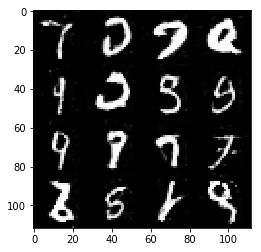

Epoch 7/10... Discriminator Loss: 0.5109... Generator Loss: 1.5861
Epoch 7/10... Discriminator Loss: 0.3719... Generator Loss: 1.9252
Epoch 8/10... Discriminator Loss: 0.3238... Generator Loss: 1.7288
Epoch 8/10... Discriminator Loss: 0.4690... Generator Loss: 1.5579
Epoch 8/10... Discriminator Loss: 0.2846... Generator Loss: 1.8381
Epoch 8/10... Discriminator Loss: 0.4672... Generator Loss: 2.0400
Epoch 8/10... Discriminator Loss: 0.3624... Generator Loss: 1.9952
Epoch 8/10... Discriminator Loss: 0.3953... Generator Loss: 1.7596
Epoch 8/10... Discriminator Loss: 0.5142... Generator Loss: 2.5244
Epoch 8/10... Discriminator Loss: 0.3086... Generator Loss: 2.1871


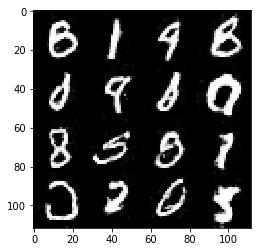

Epoch 8/10... Discriminator Loss: 0.4867... Generator Loss: 1.4930
Epoch 8/10... Discriminator Loss: 0.6593... Generator Loss: 1.1393
Epoch 8/10... Discriminator Loss: 0.4160... Generator Loss: 1.7341
Epoch 8/10... Discriminator Loss: 0.3100... Generator Loss: 1.9829
Epoch 8/10... Discriminator Loss: 0.7716... Generator Loss: 0.9118
Epoch 8/10... Discriminator Loss: 0.4318... Generator Loss: 1.5900
Epoch 8/10... Discriminator Loss: 1.1022... Generator Loss: 0.7649
Epoch 8/10... Discriminator Loss: 0.4456... Generator Loss: 1.4475
Epoch 8/10... Discriminator Loss: 0.3883... Generator Loss: 1.9387
Epoch 8/10... Discriminator Loss: 0.5104... Generator Loss: 1.6984


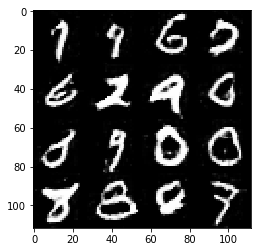

Epoch 8/10... Discriminator Loss: 0.4439... Generator Loss: 1.5509
Epoch 8/10... Discriminator Loss: 0.3860... Generator Loss: 1.7411
Epoch 8/10... Discriminator Loss: 0.6483... Generator Loss: 1.0983
Epoch 8/10... Discriminator Loss: 0.4782... Generator Loss: 1.4165
Epoch 8/10... Discriminator Loss: 0.3299... Generator Loss: 2.1025
Epoch 8/10... Discriminator Loss: 0.4973... Generator Loss: 1.5322
Epoch 8/10... Discriminator Loss: 0.4236... Generator Loss: 1.6954
Epoch 8/10... Discriminator Loss: 0.4512... Generator Loss: 1.6423
Epoch 8/10... Discriminator Loss: 0.4472... Generator Loss: 1.6319
Epoch 8/10... Discriminator Loss: 0.7678... Generator Loss: 0.7899


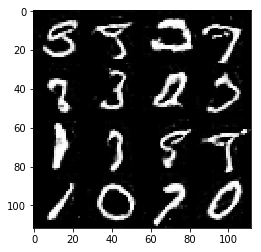

Epoch 8/10... Discriminator Loss: 0.5324... Generator Loss: 1.4546
Epoch 8/10... Discriminator Loss: 0.4161... Generator Loss: 2.0218
Epoch 8/10... Discriminator Loss: 0.4593... Generator Loss: 1.7148
Epoch 8/10... Discriminator Loss: 0.3112... Generator Loss: 1.9244
Epoch 8/10... Discriminator Loss: 0.5031... Generator Loss: 1.4539
Epoch 8/10... Discriminator Loss: 0.5574... Generator Loss: 1.1887
Epoch 8/10... Discriminator Loss: 0.2926... Generator Loss: 2.2357
Epoch 8/10... Discriminator Loss: 0.4685... Generator Loss: 1.3920
Epoch 8/10... Discriminator Loss: 0.3712... Generator Loss: 2.0787
Epoch 8/10... Discriminator Loss: 0.5145... Generator Loss: 1.5398


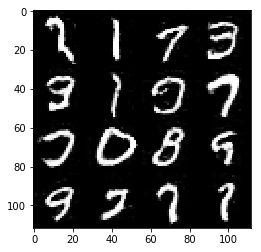

Epoch 8/10... Discriminator Loss: 0.2427... Generator Loss: 2.3557
Epoch 8/10... Discriminator Loss: 0.3425... Generator Loss: 1.9809
Epoch 8/10... Discriminator Loss: 0.3891... Generator Loss: 1.7949
Epoch 8/10... Discriminator Loss: 0.4378... Generator Loss: 1.5831
Epoch 8/10... Discriminator Loss: 0.3466... Generator Loss: 1.9022
Epoch 8/10... Discriminator Loss: 0.4014... Generator Loss: 1.4743
Epoch 8/10... Discriminator Loss: 0.2992... Generator Loss: 2.3700
Epoch 8/10... Discriminator Loss: 0.5326... Generator Loss: 1.9332
Epoch 8/10... Discriminator Loss: 0.5222... Generator Loss: 1.4140
Epoch 8/10... Discriminator Loss: 0.2421... Generator Loss: 2.5611


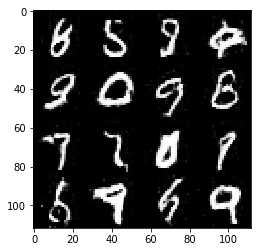

Epoch 8/10... Discriminator Loss: 0.4079... Generator Loss: 1.9145
Epoch 8/10... Discriminator Loss: 0.3748... Generator Loss: 2.1622
Epoch 8/10... Discriminator Loss: 0.3144... Generator Loss: 2.1137
Epoch 8/10... Discriminator Loss: 0.6650... Generator Loss: 1.3138
Epoch 8/10... Discriminator Loss: 0.4811... Generator Loss: 1.4906
Epoch 8/10... Discriminator Loss: 0.4339... Generator Loss: 2.0910
Epoch 8/10... Discriminator Loss: 0.5440... Generator Loss: 1.5872
Epoch 8/10... Discriminator Loss: 0.2681... Generator Loss: 2.5608
Epoch 8/10... Discriminator Loss: 0.4560... Generator Loss: 1.5049
Epoch 8/10... Discriminator Loss: 0.4796... Generator Loss: 2.1018


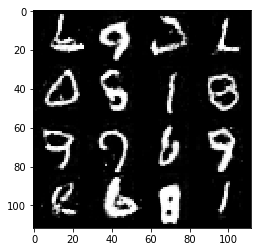

Epoch 8/10... Discriminator Loss: 0.4849... Generator Loss: 1.8569
Epoch 8/10... Discriminator Loss: 0.5207... Generator Loss: 1.4117
Epoch 8/10... Discriminator Loss: 0.6693... Generator Loss: 1.3317
Epoch 8/10... Discriminator Loss: 0.3360... Generator Loss: 1.7825
Epoch 8/10... Discriminator Loss: 0.4498... Generator Loss: 2.0736
Epoch 8/10... Discriminator Loss: 0.4408... Generator Loss: 1.4921
Epoch 8/10... Discriminator Loss: 0.2973... Generator Loss: 2.9241
Epoch 8/10... Discriminator Loss: 0.4095... Generator Loss: 1.5651
Epoch 8/10... Discriminator Loss: 0.3683... Generator Loss: 1.8455
Epoch 8/10... Discriminator Loss: 0.3716... Generator Loss: 1.9823


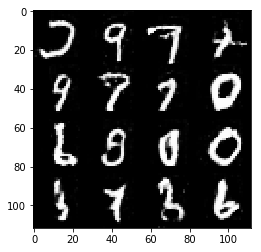

Epoch 8/10... Discriminator Loss: 0.4090... Generator Loss: 2.2446
Epoch 8/10... Discriminator Loss: 0.3629... Generator Loss: 1.5631
Epoch 8/10... Discriminator Loss: 0.5111... Generator Loss: 1.3658
Epoch 8/10... Discriminator Loss: 0.3035... Generator Loss: 2.2994
Epoch 8/10... Discriminator Loss: 0.3227... Generator Loss: 2.0611
Epoch 8/10... Discriminator Loss: 0.4479... Generator Loss: 1.3504
Epoch 8/10... Discriminator Loss: 0.3554... Generator Loss: 1.8356
Epoch 8/10... Discriminator Loss: 0.3454... Generator Loss: 1.7513
Epoch 8/10... Discriminator Loss: 0.5829... Generator Loss: 1.4127
Epoch 8/10... Discriminator Loss: 0.4204... Generator Loss: 1.5917


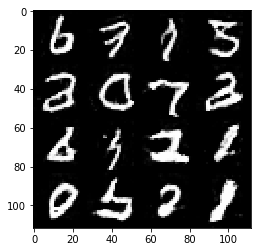

Epoch 8/10... Discriminator Loss: 0.4552... Generator Loss: 1.7687
Epoch 8/10... Discriminator Loss: 0.3561... Generator Loss: 2.0644
Epoch 8/10... Discriminator Loss: 3.0530... Generator Loss: 0.1200
Epoch 8/10... Discriminator Loss: 0.3430... Generator Loss: 1.9163
Epoch 8/10... Discriminator Loss: 0.5487... Generator Loss: 1.4289
Epoch 8/10... Discriminator Loss: 0.2556... Generator Loss: 2.3470
Epoch 8/10... Discriminator Loss: 0.3935... Generator Loss: 2.0181
Epoch 8/10... Discriminator Loss: 0.5873... Generator Loss: 1.1481
Epoch 8/10... Discriminator Loss: 0.4037... Generator Loss: 1.7328
Epoch 8/10... Discriminator Loss: 0.4923... Generator Loss: 1.8524


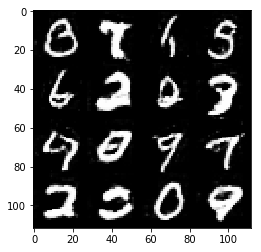

Epoch 8/10... Discriminator Loss: 0.3606... Generator Loss: 1.9703
Epoch 8/10... Discriminator Loss: 0.3775... Generator Loss: 2.2072
Epoch 8/10... Discriminator Loss: 0.1808... Generator Loss: 2.5537
Epoch 8/10... Discriminator Loss: 0.7558... Generator Loss: 1.2663
Epoch 8/10... Discriminator Loss: 0.4894... Generator Loss: 1.8812
Epoch 8/10... Discriminator Loss: 0.4346... Generator Loss: 3.1106
Epoch 8/10... Discriminator Loss: 0.6400... Generator Loss: 1.3505
Epoch 8/10... Discriminator Loss: 0.2411... Generator Loss: 2.4565
Epoch 8/10... Discriminator Loss: 0.4984... Generator Loss: 1.8001
Epoch 8/10... Discriminator Loss: 0.6205... Generator Loss: 1.1457


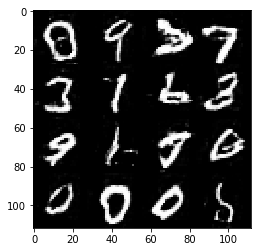

Epoch 8/10... Discriminator Loss: 0.5120... Generator Loss: 1.5123
Epoch 8/10... Discriminator Loss: 0.2409... Generator Loss: 2.4725
Epoch 8/10... Discriminator Loss: 0.2747... Generator Loss: 2.2933
Epoch 8/10... Discriminator Loss: 0.4393... Generator Loss: 1.5003
Epoch 8/10... Discriminator Loss: 0.6462... Generator Loss: 1.1205
Epoch 8/10... Discriminator Loss: 0.4057... Generator Loss: 1.5574
Epoch 8/10... Discriminator Loss: 0.7869... Generator Loss: 0.8957
Epoch 8/10... Discriminator Loss: 0.2234... Generator Loss: 2.6530
Epoch 8/10... Discriminator Loss: 0.5368... Generator Loss: 1.3457
Epoch 8/10... Discriminator Loss: 0.3177... Generator Loss: 2.0139


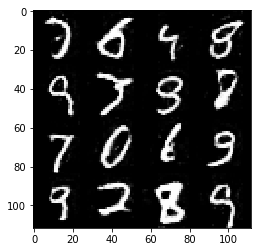

Epoch 8/10... Discriminator Loss: 0.2910... Generator Loss: 2.0925
Epoch 8/10... Discriminator Loss: 0.3122... Generator Loss: 2.0047
Epoch 8/10... Discriminator Loss: 0.5333... Generator Loss: 1.7059
Epoch 8/10... Discriminator Loss: 6.4993... Generator Loss: 9.2497
Epoch 8/10... Discriminator Loss: 0.6400... Generator Loss: 1.1932
Epoch 8/10... Discriminator Loss: 0.7773... Generator Loss: 2.8979
Epoch 8/10... Discriminator Loss: 0.3277... Generator Loss: 2.3515
Epoch 8/10... Discriminator Loss: 0.5440... Generator Loss: 1.4072
Epoch 8/10... Discriminator Loss: 0.5473... Generator Loss: 1.3691
Epoch 8/10... Discriminator Loss: 0.2935... Generator Loss: 2.2684


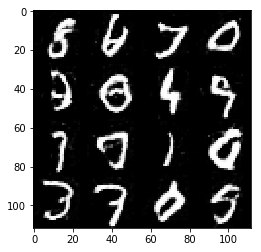

Epoch 8/10... Discriminator Loss: 0.2637... Generator Loss: 2.1023
Epoch 8/10... Discriminator Loss: 0.2936... Generator Loss: 1.8427
Epoch 8/10... Discriminator Loss: 0.2922... Generator Loss: 2.0614
Epoch 8/10... Discriminator Loss: 0.5096... Generator Loss: 1.7805
Epoch 8/10... Discriminator Loss: 0.4925... Generator Loss: 1.6811
Epoch 8/10... Discriminator Loss: 0.4203... Generator Loss: 2.1075
Epoch 8/10... Discriminator Loss: 0.5001... Generator Loss: 1.4093
Epoch 8/10... Discriminator Loss: 0.7441... Generator Loss: 0.9318
Epoch 8/10... Discriminator Loss: 0.3443... Generator Loss: 1.8573
Epoch 8/10... Discriminator Loss: 0.3029... Generator Loss: 2.2132


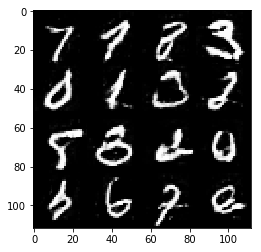

Epoch 8/10... Discriminator Loss: 0.3806... Generator Loss: 1.6309
Epoch 8/10... Discriminator Loss: 0.4847... Generator Loss: 1.5787
Epoch 8/10... Discriminator Loss: 0.6040... Generator Loss: 1.9322
Epoch 8/10... Discriminator Loss: 0.7074... Generator Loss: 0.9764
Epoch 8/10... Discriminator Loss: 0.4653... Generator Loss: 2.6313
Epoch 8/10... Discriminator Loss: 0.3504... Generator Loss: 1.9506
Epoch 8/10... Discriminator Loss: 0.6721... Generator Loss: 1.1840
Epoch 8/10... Discriminator Loss: 0.5850... Generator Loss: 1.2541
Epoch 8/10... Discriminator Loss: 1.2965... Generator Loss: 3.1390
Epoch 8/10... Discriminator Loss: 0.4369... Generator Loss: 1.6958


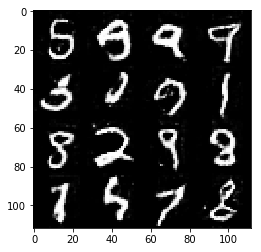

Epoch 8/10... Discriminator Loss: 0.2950... Generator Loss: 1.8718
Epoch 8/10... Discriminator Loss: 0.4077... Generator Loss: 2.2905
Epoch 8/10... Discriminator Loss: 0.4200... Generator Loss: 2.4520
Epoch 8/10... Discriminator Loss: 0.6803... Generator Loss: 1.0495
Epoch 8/10... Discriminator Loss: 0.4695... Generator Loss: 2.0410
Epoch 8/10... Discriminator Loss: 0.2685... Generator Loss: 2.1517
Epoch 8/10... Discriminator Loss: 0.4097... Generator Loss: 1.4957
Epoch 8/10... Discriminator Loss: 0.5052... Generator Loss: 1.4012
Epoch 8/10... Discriminator Loss: 0.4229... Generator Loss: 1.6379
Epoch 8/10... Discriminator Loss: 0.5244... Generator Loss: 1.3377


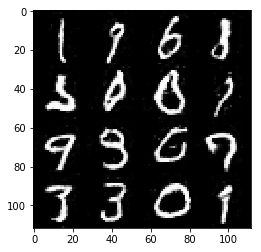

Epoch 8/10... Discriminator Loss: 0.3373... Generator Loss: 1.9876
Epoch 8/10... Discriminator Loss: 0.4501... Generator Loss: 1.9640
Epoch 8/10... Discriminator Loss: 0.4164... Generator Loss: 1.5022
Epoch 8/10... Discriminator Loss: 0.2051... Generator Loss: 2.1141
Epoch 8/10... Discriminator Loss: 0.6111... Generator Loss: 1.1729
Epoch 8/10... Discriminator Loss: 0.4248... Generator Loss: 1.4799
Epoch 8/10... Discriminator Loss: 0.5209... Generator Loss: 1.4599
Epoch 8/10... Discriminator Loss: 0.5100... Generator Loss: 1.7633
Epoch 8/10... Discriminator Loss: 0.4546... Generator Loss: 1.5139
Epoch 8/10... Discriminator Loss: 0.6134... Generator Loss: 1.1633


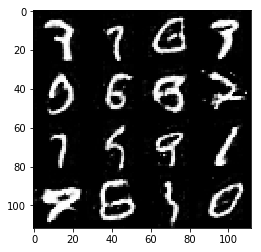

Epoch 8/10... Discriminator Loss: 0.4668... Generator Loss: 1.5881
Epoch 8/10... Discriminator Loss: 0.3713... Generator Loss: 2.0129
Epoch 8/10... Discriminator Loss: 0.2071... Generator Loss: 2.4888
Epoch 8/10... Discriminator Loss: 0.4547... Generator Loss: 1.8619
Epoch 8/10... Discriminator Loss: 0.3541... Generator Loss: 2.1802
Epoch 8/10... Discriminator Loss: 0.3376... Generator Loss: 2.3476
Epoch 8/10... Discriminator Loss: 0.3305... Generator Loss: 2.3429
Epoch 8/10... Discriminator Loss: 0.4065... Generator Loss: 1.7176
Epoch 8/10... Discriminator Loss: 0.3377... Generator Loss: 1.9895
Epoch 8/10... Discriminator Loss: 0.2862... Generator Loss: 2.0187


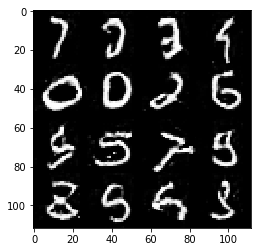

Epoch 8/10... Discriminator Loss: 0.6455... Generator Loss: 1.1246
Epoch 8/10... Discriminator Loss: 0.3623... Generator Loss: 2.3381
Epoch 8/10... Discriminator Loss: 0.5699... Generator Loss: 1.3281
Epoch 8/10... Discriminator Loss: 0.3158... Generator Loss: 1.9112
Epoch 8/10... Discriminator Loss: 0.4878... Generator Loss: 2.2826
Epoch 8/10... Discriminator Loss: 0.1455... Generator Loss: 3.0501
Epoch 8/10... Discriminator Loss: 0.4634... Generator Loss: 1.3969
Epoch 8/10... Discriminator Loss: 0.3824... Generator Loss: 1.9766
Epoch 8/10... Discriminator Loss: 0.4191... Generator Loss: 1.5636
Epoch 8/10... Discriminator Loss: 0.3662... Generator Loss: 1.7748


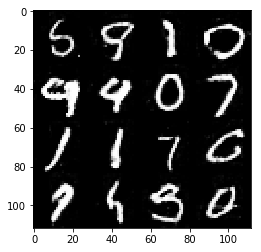

Epoch 8/10... Discriminator Loss: 0.5042... Generator Loss: 1.4946
Epoch 8/10... Discriminator Loss: 0.3913... Generator Loss: 1.6766
Epoch 8/10... Discriminator Loss: 0.7245... Generator Loss: 0.9708
Epoch 8/10... Discriminator Loss: 0.3696... Generator Loss: 2.7660
Epoch 8/10... Discriminator Loss: 0.4189... Generator Loss: 2.0674
Epoch 8/10... Discriminator Loss: 1.1381... Generator Loss: 4.4075
Epoch 8/10... Discriminator Loss: 1.0909... Generator Loss: 0.7648
Epoch 8/10... Discriminator Loss: 0.4491... Generator Loss: 1.6644
Epoch 8/10... Discriminator Loss: 0.4718... Generator Loss: 1.8216
Epoch 8/10... Discriminator Loss: 0.3074... Generator Loss: 2.2819


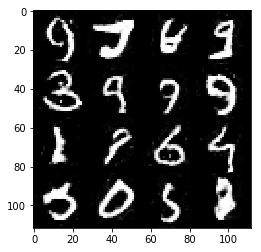

Epoch 9/10... Discriminator Loss: 0.3166... Generator Loss: 2.3663
Epoch 9/10... Discriminator Loss: 0.4719... Generator Loss: 1.6992
Epoch 9/10... Discriminator Loss: 0.4572... Generator Loss: 1.8407
Epoch 9/10... Discriminator Loss: 0.4494... Generator Loss: 3.0267
Epoch 9/10... Discriminator Loss: 0.4313... Generator Loss: 1.9354
Epoch 9/10... Discriminator Loss: 0.5457... Generator Loss: 1.4729
Epoch 9/10... Discriminator Loss: 0.6185... Generator Loss: 1.2105
Epoch 9/10... Discriminator Loss: 0.4848... Generator Loss: 1.5514
Epoch 9/10... Discriminator Loss: 0.2655... Generator Loss: 2.2020
Epoch 9/10... Discriminator Loss: 0.3099... Generator Loss: 2.6832


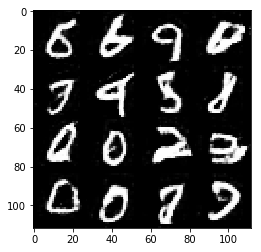

Epoch 9/10... Discriminator Loss: 0.3420... Generator Loss: 2.6446
Epoch 9/10... Discriminator Loss: 0.5971... Generator Loss: 1.1332
Epoch 9/10... Discriminator Loss: 0.5415... Generator Loss: 1.4007
Epoch 9/10... Discriminator Loss: 0.5965... Generator Loss: 1.2089
Epoch 9/10... Discriminator Loss: 0.4493... Generator Loss: 1.6549
Epoch 9/10... Discriminator Loss: 0.2828... Generator Loss: 2.0565
Epoch 9/10... Discriminator Loss: 0.7511... Generator Loss: 1.0378
Epoch 9/10... Discriminator Loss: 0.3710... Generator Loss: 2.0365
Epoch 9/10... Discriminator Loss: 0.2513... Generator Loss: 2.2632
Epoch 9/10... Discriminator Loss: 0.5235... Generator Loss: 2.0357


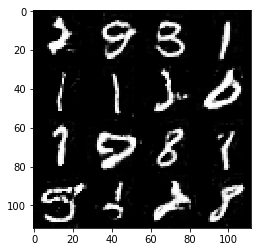

Epoch 9/10... Discriminator Loss: 0.8072... Generator Loss: 1.1604
Epoch 9/10... Discriminator Loss: 0.3461... Generator Loss: 1.8605
Epoch 9/10... Discriminator Loss: 0.3243... Generator Loss: 1.7537
Epoch 9/10... Discriminator Loss: 0.4212... Generator Loss: 1.4783
Epoch 9/10... Discriminator Loss: 0.5479... Generator Loss: 1.3663
Epoch 9/10... Discriminator Loss: 0.3079... Generator Loss: 2.2933
Epoch 9/10... Discriminator Loss: 0.4006... Generator Loss: 1.6583
Epoch 9/10... Discriminator Loss: 0.4151... Generator Loss: 1.6499
Epoch 9/10... Discriminator Loss: 0.7694... Generator Loss: 0.9759
Epoch 9/10... Discriminator Loss: 0.4056... Generator Loss: 1.8743


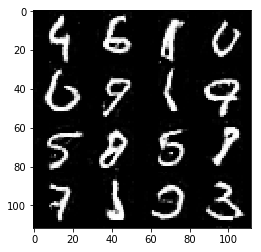

Epoch 9/10... Discriminator Loss: 0.2908... Generator Loss: 2.1370
Epoch 9/10... Discriminator Loss: 0.4722... Generator Loss: 1.3596
Epoch 9/10... Discriminator Loss: 0.4666... Generator Loss: 1.4740
Epoch 9/10... Discriminator Loss: 0.3952... Generator Loss: 1.9842
Epoch 9/10... Discriminator Loss: 0.5687... Generator Loss: 1.5071
Epoch 9/10... Discriminator Loss: 0.4978... Generator Loss: 1.4861
Epoch 9/10... Discriminator Loss: 0.3961... Generator Loss: 1.9876
Epoch 9/10... Discriminator Loss: 0.5027... Generator Loss: 2.1408
Epoch 9/10... Discriminator Loss: 0.2669... Generator Loss: 2.5374
Epoch 9/10... Discriminator Loss: 0.3046... Generator Loss: 2.4035


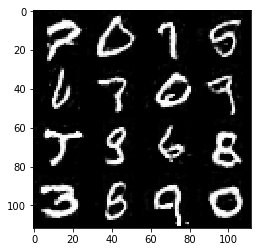

Epoch 9/10... Discriminator Loss: 0.8436... Generator Loss: 0.8477
Epoch 9/10... Discriminator Loss: 0.2570... Generator Loss: 2.2945
Epoch 9/10... Discriminator Loss: 0.5104... Generator Loss: 1.5846
Epoch 9/10... Discriminator Loss: 0.4787... Generator Loss: 1.8474
Epoch 9/10... Discriminator Loss: 0.4162... Generator Loss: 1.7819
Epoch 9/10... Discriminator Loss: 0.4558... Generator Loss: 1.6006
Epoch 9/10... Discriminator Loss: 0.3286... Generator Loss: 2.1484
Epoch 9/10... Discriminator Loss: 0.8494... Generator Loss: 0.8869
Epoch 9/10... Discriminator Loss: 0.5581... Generator Loss: 1.3005
Epoch 9/10... Discriminator Loss: 0.3426... Generator Loss: 1.7815


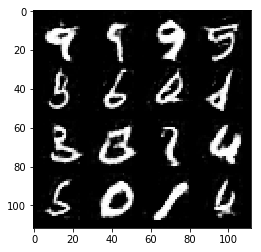

Epoch 9/10... Discriminator Loss: 0.4372... Generator Loss: 1.7725
Epoch 9/10... Discriminator Loss: 0.3037... Generator Loss: 2.1285
Epoch 9/10... Discriminator Loss: 0.3793... Generator Loss: 1.9772
Epoch 9/10... Discriminator Loss: 0.6555... Generator Loss: 1.0761
Epoch 9/10... Discriminator Loss: 0.2891... Generator Loss: 2.1551
Epoch 9/10... Discriminator Loss: 0.5645... Generator Loss: 1.2378
Epoch 9/10... Discriminator Loss: 0.5152... Generator Loss: 1.2582
Epoch 9/10... Discriminator Loss: 0.5399... Generator Loss: 1.8604
Epoch 9/10... Discriminator Loss: 0.4670... Generator Loss: 1.5567
Epoch 9/10... Discriminator Loss: 0.7455... Generator Loss: 1.1418


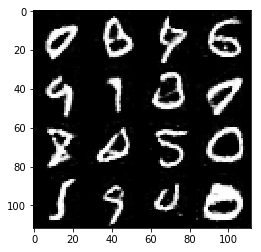

Epoch 9/10... Discriminator Loss: 0.5605... Generator Loss: 1.2789
Epoch 9/10... Discriminator Loss: 0.4950... Generator Loss: 1.4519
Epoch 9/10... Discriminator Loss: 0.2516... Generator Loss: 2.1488
Epoch 9/10... Discriminator Loss: 0.4217... Generator Loss: 2.7047
Epoch 9/10... Discriminator Loss: 0.5071... Generator Loss: 3.3358
Epoch 9/10... Discriminator Loss: 0.3118... Generator Loss: 2.2157
Epoch 9/10... Discriminator Loss: 5.4490... Generator Loss: 6.0290
Epoch 9/10... Discriminator Loss: 1.0502... Generator Loss: 1.0617
Epoch 9/10... Discriminator Loss: 0.5642... Generator Loss: 1.5838
Epoch 9/10... Discriminator Loss: 0.4919... Generator Loss: 1.9864


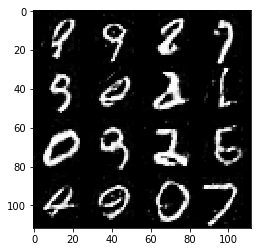

Epoch 9/10... Discriminator Loss: 0.4863... Generator Loss: 1.9979
Epoch 9/10... Discriminator Loss: 0.3437... Generator Loss: 1.9448
Epoch 9/10... Discriminator Loss: 0.3720... Generator Loss: 2.2827
Epoch 9/10... Discriminator Loss: 0.4234... Generator Loss: 1.5737
Epoch 9/10... Discriminator Loss: 0.4002... Generator Loss: 1.7730
Epoch 9/10... Discriminator Loss: 0.2335... Generator Loss: 2.4357
Epoch 9/10... Discriminator Loss: 0.3699... Generator Loss: 2.0100
Epoch 9/10... Discriminator Loss: 0.3123... Generator Loss: 3.1285
Epoch 9/10... Discriminator Loss: 0.3381... Generator Loss: 1.9992
Epoch 9/10... Discriminator Loss: 0.5766... Generator Loss: 1.1735


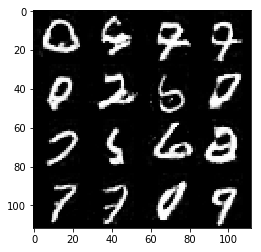

Epoch 9/10... Discriminator Loss: 0.2187... Generator Loss: 2.5122
Epoch 9/10... Discriminator Loss: 0.4109... Generator Loss: 1.8730
Epoch 9/10... Discriminator Loss: 0.4006... Generator Loss: 1.7033
Epoch 9/10... Discriminator Loss: 0.2813... Generator Loss: 1.9917
Epoch 9/10... Discriminator Loss: 0.3543... Generator Loss: 2.4515
Epoch 9/10... Discriminator Loss: 0.4981... Generator Loss: 1.4575
Epoch 9/10... Discriminator Loss: 0.5356... Generator Loss: 1.4980
Epoch 9/10... Discriminator Loss: 0.6115... Generator Loss: 1.3083
Epoch 9/10... Discriminator Loss: 0.3001... Generator Loss: 1.8343
Epoch 9/10... Discriminator Loss: 0.3526... Generator Loss: 2.1420


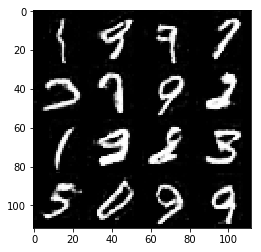

Epoch 9/10... Discriminator Loss: 0.4796... Generator Loss: 1.5301
Epoch 9/10... Discriminator Loss: 0.4197... Generator Loss: 2.2111
Epoch 9/10... Discriminator Loss: 0.5667... Generator Loss: 1.2126
Epoch 9/10... Discriminator Loss: 0.3673... Generator Loss: 2.0585
Epoch 9/10... Discriminator Loss: 0.4346... Generator Loss: 1.5723
Epoch 9/10... Discriminator Loss: 0.4259... Generator Loss: 2.0181
Epoch 9/10... Discriminator Loss: 0.3953... Generator Loss: 1.8962
Epoch 9/10... Discriminator Loss: 0.3885... Generator Loss: 2.4654
Epoch 9/10... Discriminator Loss: 0.4666... Generator Loss: 1.5325
Epoch 9/10... Discriminator Loss: 0.4085... Generator Loss: 1.8398


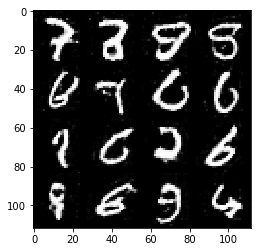

Epoch 9/10... Discriminator Loss: 0.3912... Generator Loss: 1.8174
Epoch 9/10... Discriminator Loss: 0.4728... Generator Loss: 1.5951
Epoch 9/10... Discriminator Loss: 0.3065... Generator Loss: 2.1768
Epoch 9/10... Discriminator Loss: 0.3923... Generator Loss: 1.9447
Epoch 9/10... Discriminator Loss: 0.2493... Generator Loss: 2.2836
Epoch 9/10... Discriminator Loss: 0.4999... Generator Loss: 1.5235
Epoch 9/10... Discriminator Loss: 0.3470... Generator Loss: 2.0252
Epoch 9/10... Discriminator Loss: 0.5937... Generator Loss: 1.1323
Epoch 9/10... Discriminator Loss: 0.7717... Generator Loss: 0.8546
Epoch 9/10... Discriminator Loss: 0.2760... Generator Loss: 2.5109


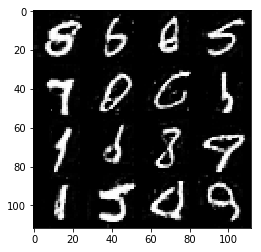

Epoch 9/10... Discriminator Loss: 1.0117... Generator Loss: 0.8880
Epoch 9/10... Discriminator Loss: 0.4647... Generator Loss: 1.9931
Epoch 9/10... Discriminator Loss: 1.4572... Generator Loss: 0.6575
Epoch 9/10... Discriminator Loss: 0.8468... Generator Loss: 1.0928
Epoch 9/10... Discriminator Loss: 0.4327... Generator Loss: 2.1238
Epoch 9/10... Discriminator Loss: 0.4271... Generator Loss: 1.7124
Epoch 9/10... Discriminator Loss: 0.4300... Generator Loss: 1.7444
Epoch 9/10... Discriminator Loss: 0.4333... Generator Loss: 1.6195
Epoch 9/10... Discriminator Loss: 0.3710... Generator Loss: 2.0759
Epoch 9/10... Discriminator Loss: 0.4208... Generator Loss: 1.7008


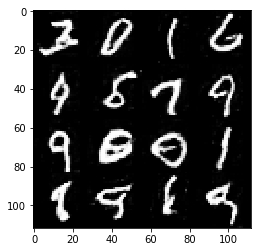

Epoch 9/10... Discriminator Loss: 0.3627... Generator Loss: 1.8505
Epoch 9/10... Discriminator Loss: 0.5685... Generator Loss: 1.1467
Epoch 9/10... Discriminator Loss: 0.3086... Generator Loss: 2.1428
Epoch 9/10... Discriminator Loss: 0.4324... Generator Loss: 1.5909
Epoch 9/10... Discriminator Loss: 0.3590... Generator Loss: 1.9942
Epoch 9/10... Discriminator Loss: 0.4286... Generator Loss: 1.5317
Epoch 9/10... Discriminator Loss: 0.3825... Generator Loss: 2.2191
Epoch 9/10... Discriminator Loss: 0.2972... Generator Loss: 2.1691
Epoch 9/10... Discriminator Loss: 0.5719... Generator Loss: 1.1401
Epoch 9/10... Discriminator Loss: 0.4765... Generator Loss: 2.3257


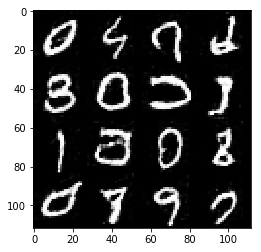

Epoch 9/10... Discriminator Loss: 0.3232... Generator Loss: 1.8372
Epoch 9/10... Discriminator Loss: 0.5009... Generator Loss: 1.6354
Epoch 9/10... Discriminator Loss: 0.3656... Generator Loss: 1.9611
Epoch 9/10... Discriminator Loss: 0.3774... Generator Loss: 1.7842
Epoch 9/10... Discriminator Loss: 0.4272... Generator Loss: 2.8302
Epoch 9/10... Discriminator Loss: 1.2039... Generator Loss: 0.6011
Epoch 9/10... Discriminator Loss: 0.4984... Generator Loss: 1.2790
Epoch 9/10... Discriminator Loss: 0.2463... Generator Loss: 2.3336
Epoch 9/10... Discriminator Loss: 0.3090... Generator Loss: 2.0884
Epoch 9/10... Discriminator Loss: 0.4952... Generator Loss: 1.3868


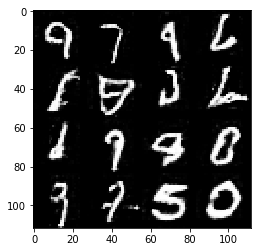

Epoch 9/10... Discriminator Loss: 0.3941... Generator Loss: 1.9374
Epoch 9/10... Discriminator Loss: 0.3718... Generator Loss: 2.2413
Epoch 9/10... Discriminator Loss: 0.4218... Generator Loss: 1.6607
Epoch 9/10... Discriminator Loss: 0.6618... Generator Loss: 1.2690
Epoch 9/10... Discriminator Loss: 0.4597... Generator Loss: 1.4166
Epoch 9/10... Discriminator Loss: 0.4023... Generator Loss: 1.7839
Epoch 9/10... Discriminator Loss: 0.7338... Generator Loss: 1.0428
Epoch 9/10... Discriminator Loss: 0.5907... Generator Loss: 1.2170
Epoch 9/10... Discriminator Loss: 0.6839... Generator Loss: 1.1301
Epoch 9/10... Discriminator Loss: 0.4538... Generator Loss: 1.6181


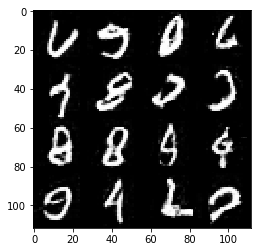

Epoch 9/10... Discriminator Loss: 0.6580... Generator Loss: 1.2458
Epoch 9/10... Discriminator Loss: 0.2497... Generator Loss: 2.4230
Epoch 9/10... Discriminator Loss: 0.3486... Generator Loss: 1.9904
Epoch 9/10... Discriminator Loss: 0.2724... Generator Loss: 2.0609
Epoch 9/10... Discriminator Loss: 0.3968... Generator Loss: 1.8419
Epoch 9/10... Discriminator Loss: 0.4138... Generator Loss: 2.0764
Epoch 9/10... Discriminator Loss: 0.4450... Generator Loss: 1.8833
Epoch 9/10... Discriminator Loss: 0.4378... Generator Loss: 1.5859
Epoch 9/10... Discriminator Loss: 0.3338... Generator Loss: 1.9586
Epoch 9/10... Discriminator Loss: 0.2970... Generator Loss: 2.1058


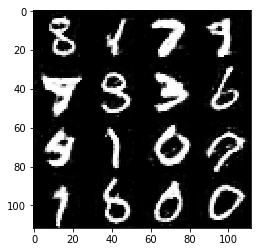

Epoch 9/10... Discriminator Loss: 0.4222... Generator Loss: 1.6371
Epoch 9/10... Discriminator Loss: 0.8765... Generator Loss: 0.8278
Epoch 9/10... Discriminator Loss: 0.4618... Generator Loss: 1.3740
Epoch 9/10... Discriminator Loss: 0.3093... Generator Loss: 2.1821
Epoch 9/10... Discriminator Loss: 0.3713... Generator Loss: 1.7206
Epoch 9/10... Discriminator Loss: 0.2770... Generator Loss: 2.5461
Epoch 9/10... Discriminator Loss: 0.6583... Generator Loss: 1.0568
Epoch 9/10... Discriminator Loss: 0.1637... Generator Loss: 3.6058
Epoch 9/10... Discriminator Loss: 0.6087... Generator Loss: 1.3257
Epoch 9/10... Discriminator Loss: 0.6916... Generator Loss: 1.1932


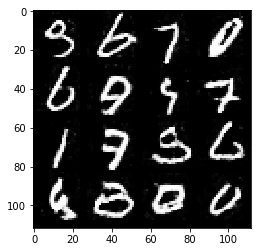

Epoch 9/10... Discriminator Loss: 0.5568... Generator Loss: 1.7382
Epoch 9/10... Discriminator Loss: 0.8244... Generator Loss: 3.5080
Epoch 9/10... Discriminator Loss: 0.3341... Generator Loss: 2.5934
Epoch 9/10... Discriminator Loss: 0.5672... Generator Loss: 1.6997
Epoch 9/10... Discriminator Loss: 0.6037... Generator Loss: 1.4821
Epoch 9/10... Discriminator Loss: 0.6066... Generator Loss: 1.5126
Epoch 9/10... Discriminator Loss: 0.7320... Generator Loss: 0.9725
Epoch 9/10... Discriminator Loss: 0.3814... Generator Loss: 1.7164
Epoch 9/10... Discriminator Loss: 0.4781... Generator Loss: 1.7010
Epoch 9/10... Discriminator Loss: 0.3101... Generator Loss: 2.2225


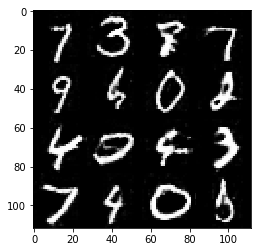

Epoch 9/10... Discriminator Loss: 0.5005... Generator Loss: 1.5014
Epoch 9/10... Discriminator Loss: 0.3140... Generator Loss: 2.1176
Epoch 9/10... Discriminator Loss: 0.5626... Generator Loss: 1.2007
Epoch 9/10... Discriminator Loss: 0.2970... Generator Loss: 2.1674
Epoch 9/10... Discriminator Loss: 0.5832... Generator Loss: 1.5720
Epoch 9/10... Discriminator Loss: 0.4032... Generator Loss: 1.9401
Epoch 9/10... Discriminator Loss: 0.3111... Generator Loss: 2.0130
Epoch 10/10... Discriminator Loss: 0.3819... Generator Loss: 1.7787
Epoch 10/10... Discriminator Loss: 0.3043... Generator Loss: 2.0690
Epoch 10/10... Discriminator Loss: 0.3048... Generator Loss: 2.8723


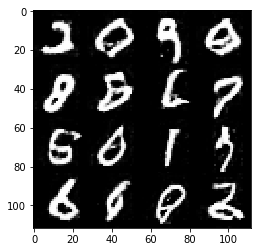

Epoch 10/10... Discriminator Loss: 0.5724... Generator Loss: 1.3078
Epoch 10/10... Discriminator Loss: 0.3646... Generator Loss: 2.2104
Epoch 10/10... Discriminator Loss: 0.3978... Generator Loss: 1.8636
Epoch 10/10... Discriminator Loss: 0.4064... Generator Loss: 2.0776
Epoch 10/10... Discriminator Loss: 0.2257... Generator Loss: 2.1180
Epoch 10/10... Discriminator Loss: 0.4399... Generator Loss: 1.6167
Epoch 10/10... Discriminator Loss: 0.6128... Generator Loss: 1.2692
Epoch 10/10... Discriminator Loss: 0.4640... Generator Loss: 1.9520
Epoch 10/10... Discriminator Loss: 0.4362... Generator Loss: 1.7576
Epoch 10/10... Discriminator Loss: 0.5992... Generator Loss: 1.4022


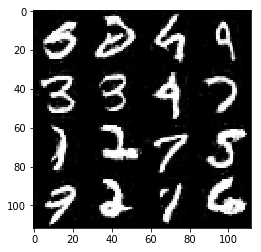

Epoch 10/10... Discriminator Loss: 0.4283... Generator Loss: 1.6722
Epoch 10/10... Discriminator Loss: 3.8307... Generator Loss: 0.0477
Epoch 10/10... Discriminator Loss: 0.3190... Generator Loss: 2.2749
Epoch 10/10... Discriminator Loss: 0.3751... Generator Loss: 1.9821
Epoch 10/10... Discriminator Loss: 0.6662... Generator Loss: 2.8375
Epoch 10/10... Discriminator Loss: 0.3205... Generator Loss: 1.9741
Epoch 10/10... Discriminator Loss: 0.4518... Generator Loss: 1.6273
Epoch 10/10... Discriminator Loss: 0.5870... Generator Loss: 1.5125
Epoch 10/10... Discriminator Loss: 0.3719... Generator Loss: 2.6241
Epoch 10/10... Discriminator Loss: 0.3790... Generator Loss: 2.7445


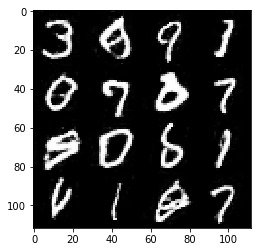

Epoch 10/10... Discriminator Loss: 0.4443... Generator Loss: 1.6043
Epoch 10/10... Discriminator Loss: 0.4142... Generator Loss: 1.5415
Epoch 10/10... Discriminator Loss: 0.4685... Generator Loss: 1.4643
Epoch 10/10... Discriminator Loss: 0.3484... Generator Loss: 2.2879
Epoch 10/10... Discriminator Loss: 1.1821... Generator Loss: 0.5474
Epoch 10/10... Discriminator Loss: 0.3489... Generator Loss: 2.2767
Epoch 10/10... Discriminator Loss: 0.4653... Generator Loss: 1.9794
Epoch 10/10... Discriminator Loss: 0.4483... Generator Loss: 1.5858
Epoch 10/10... Discriminator Loss: 0.3840... Generator Loss: 2.4242
Epoch 10/10... Discriminator Loss: 0.4301... Generator Loss: 1.7278


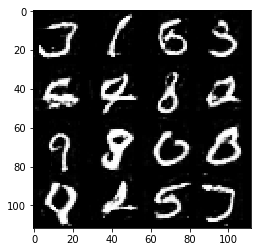

Epoch 10/10... Discriminator Loss: 0.3470... Generator Loss: 1.8793
Epoch 10/10... Discriminator Loss: 0.4304... Generator Loss: 1.7207
Epoch 10/10... Discriminator Loss: 0.4739... Generator Loss: 1.5744
Epoch 10/10... Discriminator Loss: 0.6014... Generator Loss: 1.0839
Epoch 10/10... Discriminator Loss: 0.3850... Generator Loss: 2.2347
Epoch 10/10... Discriminator Loss: 0.2790... Generator Loss: 2.1223
Epoch 10/10... Discriminator Loss: 0.3784... Generator Loss: 1.6620
Epoch 10/10... Discriminator Loss: 0.3129... Generator Loss: 1.9296
Epoch 10/10... Discriminator Loss: 0.1669... Generator Loss: 2.6991
Epoch 10/10... Discriminator Loss: 0.3781... Generator Loss: 1.7944


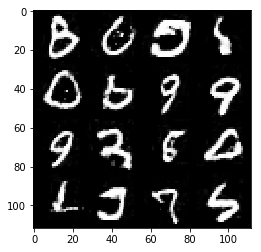

Epoch 10/10... Discriminator Loss: 0.4527... Generator Loss: 2.4071
Epoch 10/10... Discriminator Loss: 0.5155... Generator Loss: 1.5616
Epoch 10/10... Discriminator Loss: 0.7509... Generator Loss: 2.0899
Epoch 10/10... Discriminator Loss: 0.3658... Generator Loss: 2.2423
Epoch 10/10... Discriminator Loss: 0.1783... Generator Loss: 2.9545
Epoch 10/10... Discriminator Loss: 0.4921... Generator Loss: 1.4308
Epoch 10/10... Discriminator Loss: 0.4056... Generator Loss: 1.8523
Epoch 10/10... Discriminator Loss: 0.3979... Generator Loss: 1.6292
Epoch 10/10... Discriminator Loss: 0.4095... Generator Loss: 2.0493
Epoch 10/10... Discriminator Loss: 0.4148... Generator Loss: 1.5644


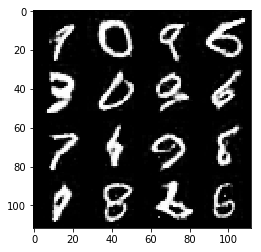

Epoch 10/10... Discriminator Loss: 1.8006... Generator Loss: 0.4646
Epoch 10/10... Discriminator Loss: 0.5400... Generator Loss: 2.3114
Epoch 10/10... Discriminator Loss: 0.2386... Generator Loss: 2.4785
Epoch 10/10... Discriminator Loss: 0.3574... Generator Loss: 1.8462
Epoch 10/10... Discriminator Loss: 0.3641... Generator Loss: 2.6582
Epoch 10/10... Discriminator Loss: 0.6705... Generator Loss: 1.2073
Epoch 10/10... Discriminator Loss: 0.4024... Generator Loss: 2.0396
Epoch 10/10... Discriminator Loss: 0.4354... Generator Loss: 1.5468
Epoch 10/10... Discriminator Loss: 0.4068... Generator Loss: 1.8322
Epoch 10/10... Discriminator Loss: 0.4676... Generator Loss: 1.6595


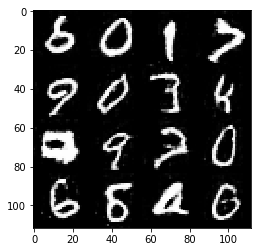

Epoch 10/10... Discriminator Loss: 0.4216... Generator Loss: 1.7487
Epoch 10/10... Discriminator Loss: 0.2644... Generator Loss: 2.0235
Epoch 10/10... Discriminator Loss: 0.4875... Generator Loss: 1.4754
Epoch 10/10... Discriminator Loss: 0.4543... Generator Loss: 1.9896
Epoch 10/10... Discriminator Loss: 0.4128... Generator Loss: 2.7922
Epoch 10/10... Discriminator Loss: 0.5936... Generator Loss: 1.4324
Epoch 10/10... Discriminator Loss: 0.2666... Generator Loss: 2.1825
Epoch 10/10... Discriminator Loss: 0.2635... Generator Loss: 2.3817
Epoch 10/10... Discriminator Loss: 0.4104... Generator Loss: 2.3058
Epoch 10/10... Discriminator Loss: 0.4270... Generator Loss: 2.1425


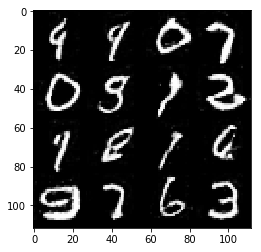

Epoch 10/10... Discriminator Loss: 0.4232... Generator Loss: 1.6488
Epoch 10/10... Discriminator Loss: 0.2945... Generator Loss: 2.1734
Epoch 10/10... Discriminator Loss: 0.3492... Generator Loss: 2.2373
Epoch 10/10... Discriminator Loss: 0.6582... Generator Loss: 1.4358
Epoch 10/10... Discriminator Loss: 0.3049... Generator Loss: 1.9030
Epoch 10/10... Discriminator Loss: 0.3481... Generator Loss: 2.7156
Epoch 10/10... Discriminator Loss: 0.5540... Generator Loss: 2.5857
Epoch 10/10... Discriminator Loss: 0.6607... Generator Loss: 3.1579
Epoch 10/10... Discriminator Loss: 0.3188... Generator Loss: 2.0787
Epoch 10/10... Discriminator Loss: 0.8812... Generator Loss: 1.1075


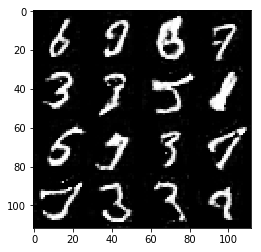

Epoch 10/10... Discriminator Loss: 0.3157... Generator Loss: 1.9774
Epoch 10/10... Discriminator Loss: 0.3133... Generator Loss: 2.0619
Epoch 10/10... Discriminator Loss: 0.4855... Generator Loss: 1.7508
Epoch 10/10... Discriminator Loss: 0.2832... Generator Loss: 2.4524
Epoch 10/10... Discriminator Loss: 0.5383... Generator Loss: 1.3219
Epoch 10/10... Discriminator Loss: 0.3685... Generator Loss: 1.9507
Epoch 10/10... Discriminator Loss: 0.5563... Generator Loss: 1.4408
Epoch 10/10... Discriminator Loss: 0.3032... Generator Loss: 2.6312
Epoch 10/10... Discriminator Loss: 0.5722... Generator Loss: 1.2757
Epoch 10/10... Discriminator Loss: 0.4565... Generator Loss: 1.8886


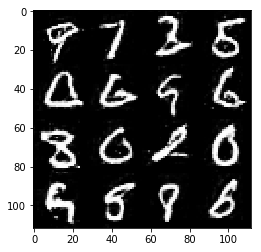

Epoch 10/10... Discriminator Loss: 0.4509... Generator Loss: 1.7393
Epoch 10/10... Discriminator Loss: 0.3750... Generator Loss: 2.1768
Epoch 10/10... Discriminator Loss: 0.2650... Generator Loss: 2.0114
Epoch 10/10... Discriminator Loss: 0.7044... Generator Loss: 1.1826
Epoch 10/10... Discriminator Loss: 0.5465... Generator Loss: 1.4941
Epoch 10/10... Discriminator Loss: 0.4382... Generator Loss: 1.8600
Epoch 10/10... Discriminator Loss: 0.2961... Generator Loss: 2.0040
Epoch 10/10... Discriminator Loss: 0.4746... Generator Loss: 1.7555
Epoch 10/10... Discriminator Loss: 0.3785... Generator Loss: 1.6634
Epoch 10/10... Discriminator Loss: 0.4180... Generator Loss: 1.7113


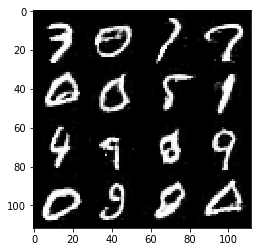

Epoch 10/10... Discriminator Loss: 0.3594... Generator Loss: 2.0023
Epoch 10/10... Discriminator Loss: 1.0046... Generator Loss: 0.9648
Epoch 10/10... Discriminator Loss: 0.4712... Generator Loss: 1.9157
Epoch 10/10... Discriminator Loss: 0.5201... Generator Loss: 1.5912
Epoch 10/10... Discriminator Loss: 0.3038... Generator Loss: 2.0525
Epoch 10/10... Discriminator Loss: 0.3804... Generator Loss: 1.8513
Epoch 10/10... Discriminator Loss: 0.5060... Generator Loss: 1.3190
Epoch 10/10... Discriminator Loss: 0.4059... Generator Loss: 1.6712
Epoch 10/10... Discriminator Loss: 0.3333... Generator Loss: 1.9034
Epoch 10/10... Discriminator Loss: 0.4598... Generator Loss: 1.9432


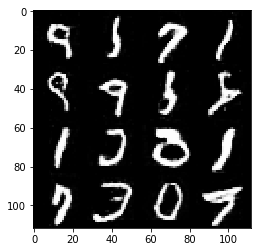

Epoch 10/10... Discriminator Loss: 3.2371... Generator Loss: 4.6053
Epoch 10/10... Discriminator Loss: 0.9042... Generator Loss: 3.4060
Epoch 10/10... Discriminator Loss: 1.0435... Generator Loss: 1.7186
Epoch 10/10... Discriminator Loss: 0.7915... Generator Loss: 0.8954
Epoch 10/10... Discriminator Loss: 0.8251... Generator Loss: 0.9110
Epoch 10/10... Discriminator Loss: 0.3785... Generator Loss: 2.5481
Epoch 10/10... Discriminator Loss: 0.4253... Generator Loss: 1.8614
Epoch 10/10... Discriminator Loss: 0.4679... Generator Loss: 1.7078
Epoch 10/10... Discriminator Loss: 0.6340... Generator Loss: 1.5779
Epoch 10/10... Discriminator Loss: 0.7341... Generator Loss: 1.1685


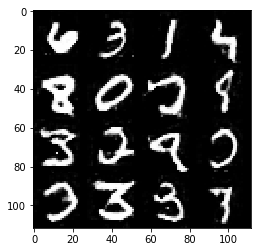

Epoch 10/10... Discriminator Loss: 0.6770... Generator Loss: 3.7144
Epoch 10/10... Discriminator Loss: 0.4810... Generator Loss: 1.6616
Epoch 10/10... Discriminator Loss: 0.4508... Generator Loss: 1.7150
Epoch 10/10... Discriminator Loss: 0.4163... Generator Loss: 1.9884
Epoch 10/10... Discriminator Loss: 0.5606... Generator Loss: 1.5166
Epoch 10/10... Discriminator Loss: 0.3918... Generator Loss: 2.0225
Epoch 10/10... Discriminator Loss: 0.4174... Generator Loss: 1.7305
Epoch 10/10... Discriminator Loss: 0.5928... Generator Loss: 1.7355
Epoch 10/10... Discriminator Loss: 0.5950... Generator Loss: 1.3536
Epoch 10/10... Discriminator Loss: 0.4225... Generator Loss: 2.3685


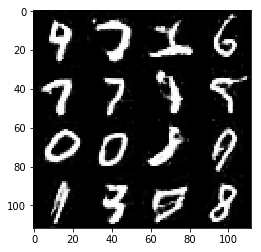

Epoch 10/10... Discriminator Loss: 0.5208... Generator Loss: 1.4402
Epoch 10/10... Discriminator Loss: 0.5730... Generator Loss: 1.2808
Epoch 10/10... Discriminator Loss: 0.5644... Generator Loss: 1.3461
Epoch 10/10... Discriminator Loss: 0.5194... Generator Loss: 2.9095
Epoch 10/10... Discriminator Loss: 0.4361... Generator Loss: 2.2923
Epoch 10/10... Discriminator Loss: 0.3880... Generator Loss: 3.1348
Epoch 10/10... Discriminator Loss: 0.4591... Generator Loss: 1.7428
Epoch 10/10... Discriminator Loss: 0.4294... Generator Loss: 2.4477
Epoch 10/10... Discriminator Loss: 0.9293... Generator Loss: 0.9151
Epoch 10/10... Discriminator Loss: 0.3793... Generator Loss: 1.8454


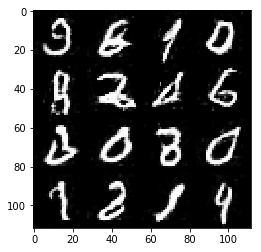

Epoch 10/10... Discriminator Loss: 0.4307... Generator Loss: 1.7934
Epoch 10/10... Discriminator Loss: 0.3214... Generator Loss: 1.9819
Epoch 10/10... Discriminator Loss: 0.5924... Generator Loss: 1.3610
Epoch 10/10... Discriminator Loss: 0.3896... Generator Loss: 2.1824
Epoch 10/10... Discriminator Loss: 0.4960... Generator Loss: 1.6671
Epoch 10/10... Discriminator Loss: 0.4088... Generator Loss: 2.5571
Epoch 10/10... Discriminator Loss: 0.5218... Generator Loss: 1.6605
Epoch 10/10... Discriminator Loss: 0.6026... Generator Loss: 1.2915
Epoch 10/10... Discriminator Loss: 0.2062... Generator Loss: 2.5505
Epoch 10/10... Discriminator Loss: 0.4917... Generator Loss: 1.5650


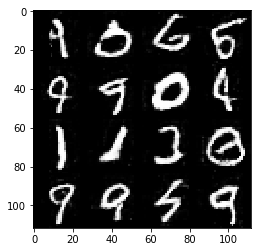

Epoch 10/10... Discriminator Loss: 0.5521... Generator Loss: 1.5991
Epoch 10/10... Discriminator Loss: 0.5450... Generator Loss: 1.4592
Epoch 10/10... Discriminator Loss: 0.5833... Generator Loss: 1.1608
Epoch 10/10... Discriminator Loss: 0.4232... Generator Loss: 1.5361
Epoch 10/10... Discriminator Loss: 0.8065... Generator Loss: 0.7835
Epoch 10/10... Discriminator Loss: 0.5323... Generator Loss: 1.7081
Epoch 10/10... Discriminator Loss: 0.4068... Generator Loss: 1.7898
Epoch 10/10... Discriminator Loss: 0.3849... Generator Loss: 2.4823
Epoch 10/10... Discriminator Loss: 0.5230... Generator Loss: 1.3480
Epoch 10/10... Discriminator Loss: 0.4965... Generator Loss: 2.3809


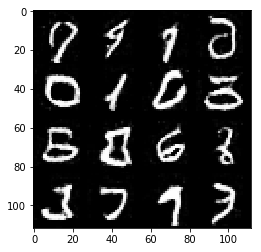

Epoch 10/10... Discriminator Loss: 0.5394... Generator Loss: 1.6704
Epoch 10/10... Discriminator Loss: 0.3667... Generator Loss: 2.4500
Epoch 10/10... Discriminator Loss: 0.4067... Generator Loss: 1.5139
Epoch 10/10... Discriminator Loss: 0.3946... Generator Loss: 2.0119
Epoch 10/10... Discriminator Loss: 0.4646... Generator Loss: 1.5859
Epoch 10/10... Discriminator Loss: 0.5670... Generator Loss: 1.3106
Epoch 10/10... Discriminator Loss: 0.2193... Generator Loss: 2.7698
Epoch 10/10... Discriminator Loss: 0.6965... Generator Loss: 1.1016
Epoch 10/10... Discriminator Loss: 0.5876... Generator Loss: 1.1278
Epoch 10/10... Discriminator Loss: 0.3046... Generator Loss: 2.2534


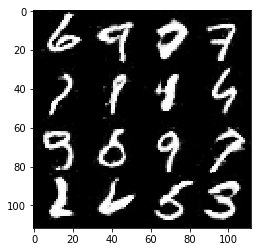

Epoch 10/10... Discriminator Loss: 0.2238... Generator Loss: 2.5647
Epoch 10/10... Discriminator Loss: 0.4300... Generator Loss: 2.5670
Epoch 10/10... Discriminator Loss: 0.4315... Generator Loss: 1.6719
Epoch 10/10... Discriminator Loss: 0.6531... Generator Loss: 1.3085
Epoch 10/10... Discriminator Loss: 0.4737... Generator Loss: 1.4773
Epoch 10/10... Discriminator Loss: 0.6597... Generator Loss: 1.0790
Epoch 10/10... Discriminator Loss: 0.5062... Generator Loss: 1.4650
Epoch 10/10... Discriminator Loss: 0.6996... Generator Loss: 1.2667
Epoch 10/10... Discriminator Loss: 0.5737... Generator Loss: 1.2087
Epoch 10/10... Discriminator Loss: 0.4731... Generator Loss: 1.6034


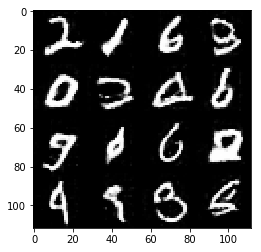

Epoch 10/10... Discriminator Loss: 0.2999... Generator Loss: 1.9831
Epoch 10/10... Discriminator Loss: 0.6447... Generator Loss: 1.1866
Epoch 10/10... Discriminator Loss: 0.4985... Generator Loss: 1.6386
Epoch 10/10... Discriminator Loss: 0.5873... Generator Loss: 1.3261
Epoch 10/10... Discriminator Loss: 0.3689... Generator Loss: 2.0793


In [16]:
import time

batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

start_time = time.time()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [22]:
import time
start_time = time.time()
time.sleep(2)
execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

00:00:02


Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 1.6211
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 0.3069... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 0.2494... Generator Loss: 2.1082
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.2559... Generator Loss: 2.0204
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 2.1579
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 2.0235


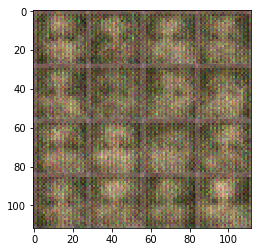

Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 2.0880


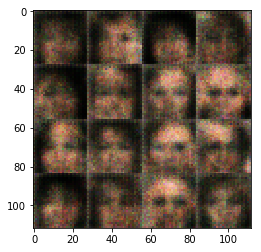

Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 2.4879
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.8191
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.7672


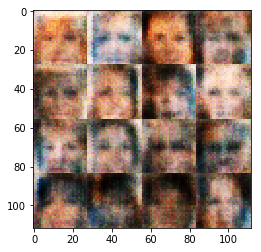

Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.3591


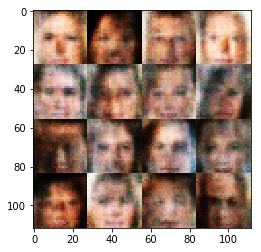

Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.9101


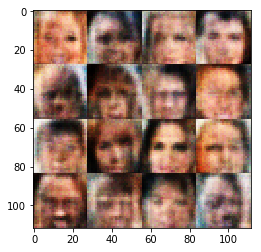

Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 0.8994


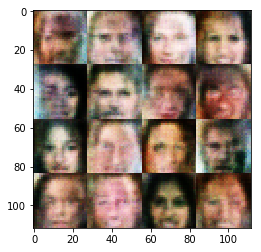

Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.5611
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.2538


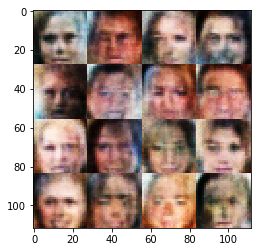

Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.0918


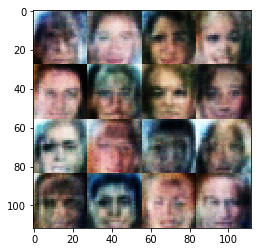

Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.1337


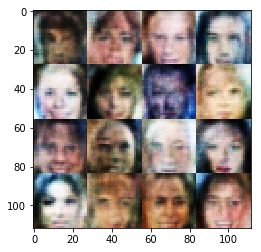

Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 0.9473


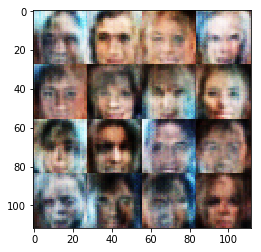

Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.7825


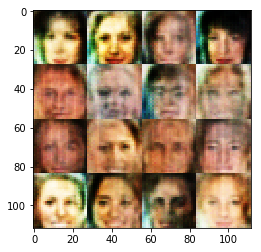

Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.7883


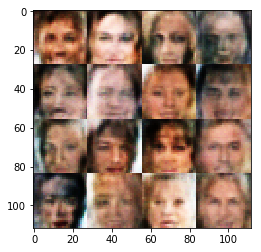

Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0271


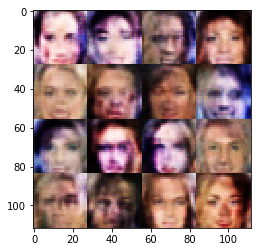

Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.0281


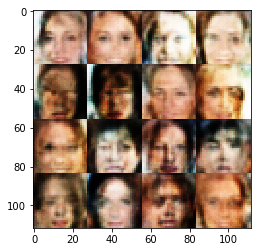

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.0240


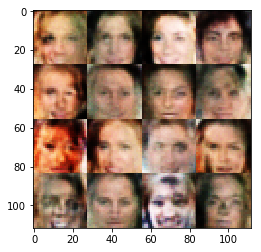

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8338


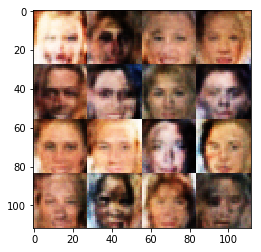

Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 0.9080


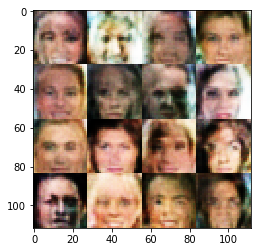

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.0459


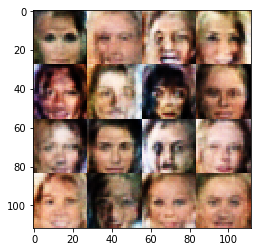

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1749


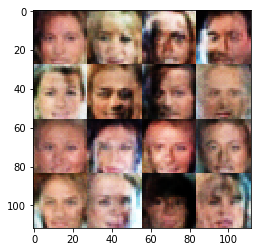

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1801


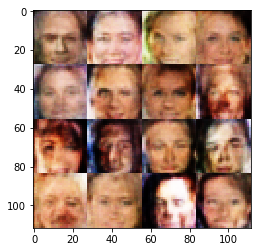

Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6027


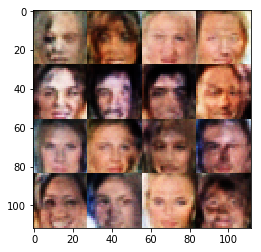

Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.1562


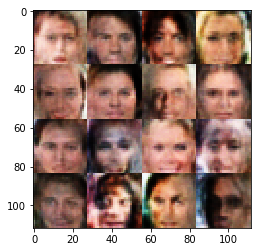

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9923


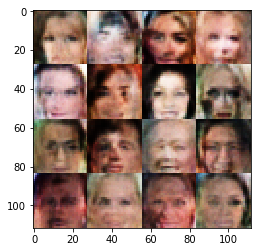

Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.1601


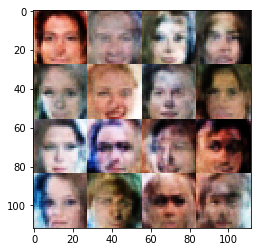

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.0048


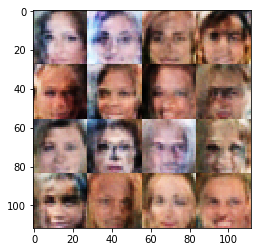

Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.7478


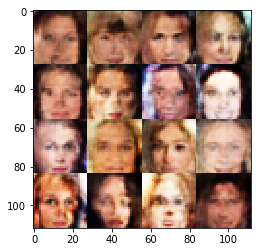

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.0255


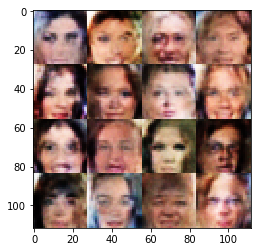

Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 0.8127


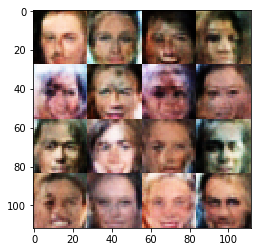

Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.9020
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.8184


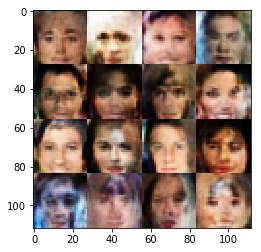

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3631
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0800


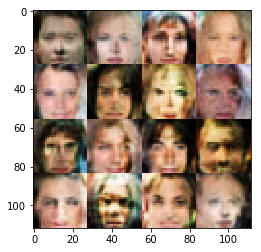

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5903


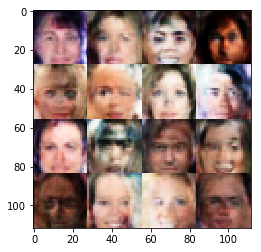

Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6859


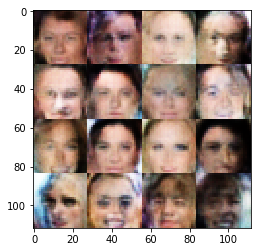

Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.1117


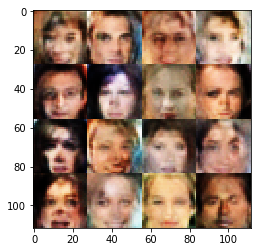

Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.0494


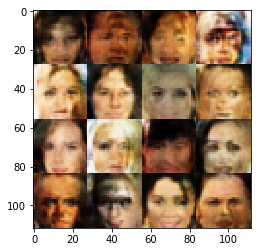

Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.0726


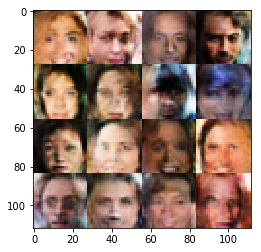

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.0476


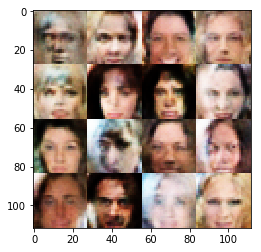

Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7863


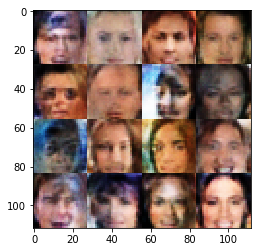

Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8912


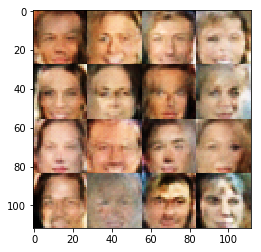

Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0825


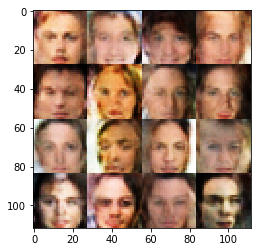

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.3525


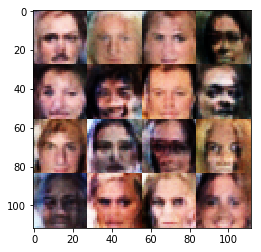

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7357


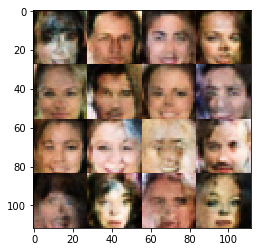

Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.1192


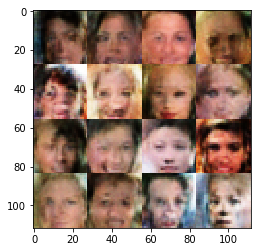

Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.5617


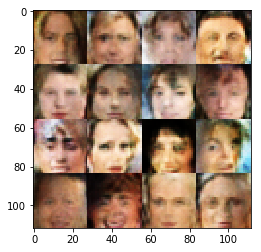

Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.7830


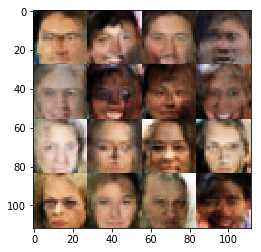

Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7687


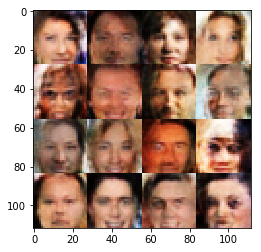

Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.5232
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.7701


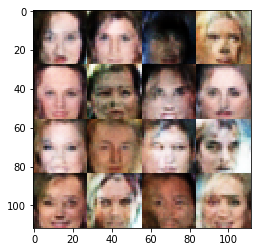

Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.2027


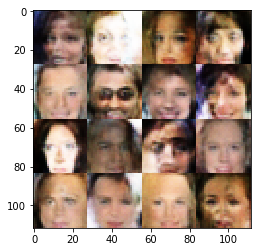

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.1877


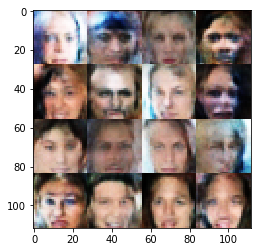

Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.7520


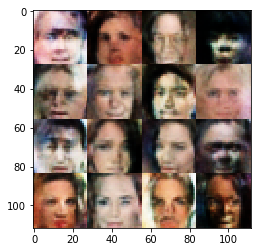

Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.0239


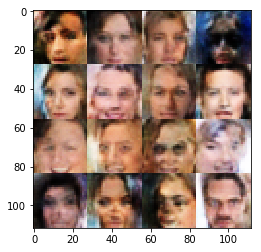

Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9965


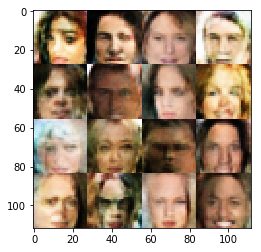

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.2843


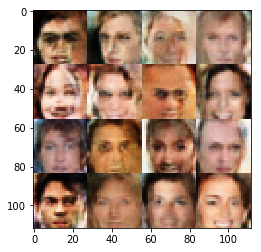

Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2171


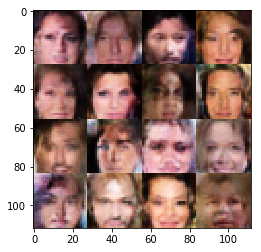

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 0.9471


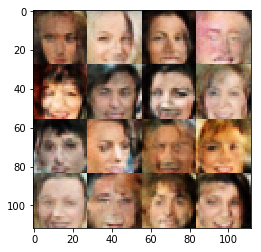

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.8248


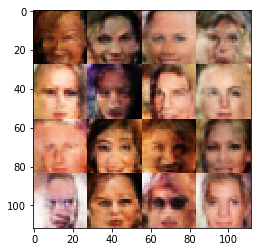

Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.4857


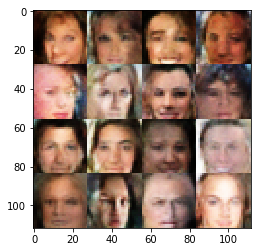

Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.4196


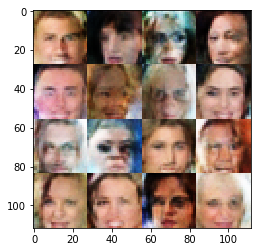

Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.4998


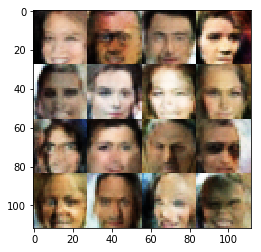

Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0646


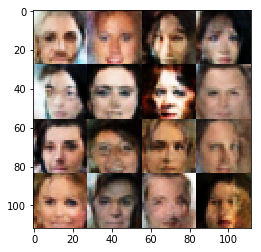

Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6865


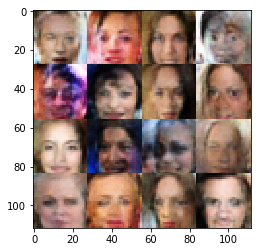

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.6965


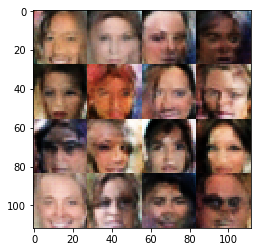

Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8053


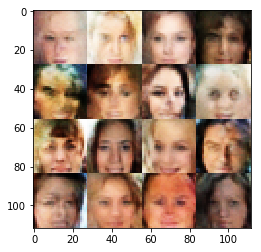

Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.9479


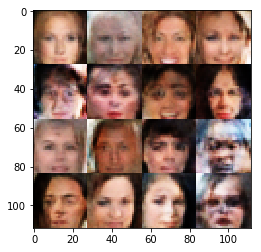

Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 0.9103
00:13:34


In [24]:
import time


batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

start_time = time.time()

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.